# Preamble

In [2]:
import healpy as hp
import numpy as np
import math
import pandas as pd
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from scipy.special import erf

import copy
import sys
from my_units import * 

from angular_fn import *
from template_fn import *
from cov_matrix_fn import *

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


'''plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors

rcParams['mathtext.rm'] = 'Computer Modern'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
'''

HomeDir = './'
#DataDir = HomeDir #+ 'code/'
DataDir = './'#'/Users/crimondino/Dropbox (PI)/LensVelocity2/data/pairs_ruwe_dist/'#HomeDir #+ 'code/'

### Set this to the directory where you store your data files (see below how to download them)
ListDir = HomeDir+'lists/hist_stats/'
FigDir = '../../../figures/'

In [2]:
from IPython.core.display import display, HTML
from IPython.display import display, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(edgeitems=3, linewidth=200) 
pd.set_option('display.max_columns', None)
pd.set_option('max_rows',200) and pandas.set_option('max_columns',20)

/tmp/ipykernel_2100880/1921462837.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


OptionError: 'Pattern matched multiple keys'

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'

font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

# Read in Files

In [2]:
df_back = pd.read_csv(DataDir+'bg_subtracted.csv') 
print('Backgrounds read in.')

df_fore = pd.read_csv(DataDir+'fg_subtracted.csv') #discrepancy in parameters?
print('Foregrounds read in.')
len(df_back)

Backgrounds read in.
Foregrounds read in.


11375859

In [3]:
df_fore.columns

Index(['source_id', 'ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error',
       'parallax', 'parallax_error', 'phot_g_mean_mag', 'l', 'b', 'ruwe',
       'dist_50', 'dist_14', 'dist_86'],
      dtype='object')

In [4]:
### Select only foreground stars that have mass measurement
with_params = ~np.isnan(df_fore['lum'])
#df_fore = df_fore[with_params]
#df_back = df_back[with_params]
len(df_back[with_params])

KeyError: 'lum'

In [5]:
### Select only the closest foreground stars
#df_back = df_back.iloc[df_fore['dist_50'].to_numpy()<500]
#df_fore = df_fore.iloc[df_fore['dist_50'].to_numpy()<500]
len(df_fore)

11375859

In [6]:
len(df_back[df_fore['dist_50'].to_numpy()<500])/len(df_back)

0.18000143989126446

In [7]:
len(df_back[((df_fore['dist_50'].to_numpy()<500) & (with_params))])/len(df_back[with_params])

NameError: name 'with_params' is not defined

## old code

In [3]:
df_back = pd.read_csv(DataDir+'pairs_background_ruwe_w_st.csv', usecols = ['ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'pmra_eff_error', 'pmdec_eff_error', 'pmra_pmdec_eff_corr', 'parallax', 'parallax_error', 'parallax_eff_error', 'pmra_sub', 'pmdec_sub', 'ecl_lon', 'ecl_lat', 'l', 'b', 'ruwe'])
print('Backgrounds read in.')

df_fore = pd.read_csv(DataDir+'pairs_foreground_ruwe_w_st.csv', usecols = ['ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'ecl_lon', 'ecl_lat', 'l', 'b', 'ruwe'])
print('Foregrounds read in.')

back_dist = pd.read_csv('bg_dist.csv', header=None)
fore_dist = pd.read_csv('fg_dist.csv', header=None)

In [3]:
### load in indices of stars that "survived" the subtraction process (ruwe < 1.4, not outlier) 

bg_sub_ind = np.load('tmu_ind.npy')

df_back = df_back.loc[bg_sub_ind]
df_fore = df_fore.loc[bg_sub_ind]
back_dist = back_dist.loc[bg_sub_ind]
fore_dist = fore_dist.loc[bg_sub_ind]

df_back.shape

(8763142, 20)

In [4]:
df_back = df_back.reset_index()
df_fore = df_fore.reset_index()
back_dist = back_dist.reset_index()
fore_dist = fore_dist.reset_index()

In [5]:
### load in new subtractions
new_sub = pd.read_csv('new_sub.csv', usecols=['pmra_sub_new', 'pmdec_sub_new', 'pmra_eff_error_new',
       'pmdec_eff_error_new', 'pmra_pmdec_eff_corr_new'])

In [6]:
new_sub

pmra_sub_new  pmdec_sub_new  pmra_eff_error_new  pmdec_eff_error_new  \
0           -0.265639      -1.433541            1.048995             1.464768   
1            0.639632      -0.388836            1.048995             1.464768   
2            0.342923      -3.928524            1.048995             1.464768   
3            0.125175       0.612223            1.048995             1.464768   
4           -1.488503      -1.430796            1.048995             1.464768   
...               ...            ...                 ...                  ...   
8763137      0.267562       3.744027            3.028023             2.787486   
8763138      5.876851      -1.506965            3.055063             2.788147   
8763139      4.819424       1.742081            3.430736             3.214288   
8763140     -2.938167      -1.353771            3.118294             3.411297   
8763141     -2.689983      -4.334627            2.830146             2.890214   

         pmra_pmdec_eff_corr_new  
0                      -0.037695  
1                      -0.074210  
2                      -0.053853  
3                      -0.039847  
4                      -0.055005  
...                          ...  
8763137                 0.148879  
8763138                 0.136006  
8763139                -0.006314  
8763140                 0.304556  
8763141                 0.237604  

[8763142 rows x 5 columns]

In [7]:
df_back = df_back.join(new_sub)
df_back['dist'] = back_dist[1]
df_fore['dist'] = fore_dist[1]

# Density plot

In [8]:
eq_to_gal_rot_matrix = np.array([[-0.0548755604162154, -0.8734370902348850, -0.4838350155487132], 
                                 [0.4941094278755837, -0.4448296299600112, 0.7469822444972189], 
                                 [-0.8676661490190047, -0.1980763734312015, 0.4559837761750669]])

def fn_eq_to_gal_array(ra, dec):
    """
    Function to convert the equatorial coordinates (ra, dec) to galactic coordinates according to the Gaia reference frame.
    Works only if ra and dec are numpy arrays. Takes angles in degree and returns in degree.
    Refs.: https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html 
    and section 1.5.3 of https://www.cosmos.esa.int/documents/532822/552851/vol1_all.pdf
    """
    
    ra_s, dec_s = ra*degree, dec*degree
    
    x_vec_eq = np.array([np.cos(dec_s)*np.cos(ra_s), np.cos(dec_s)*np.sin(ra_s), np.sin(dec_s)])
    x_vec_gal = (eq_to_gal_rot_matrix @ x_vec_eq).T
    
    gal_lon, gal_lat = (np.arctan2(x_vec_gal[:, 1], x_vec_gal[:, 0])), np.arctan2(x_vec_gal[:, 2], np.sqrt(x_vec_gal[:, 0]**2 + x_vec_gal[:, 1]**2))
    gal_lon = gal_lon + 2*np.pi*np.heaviside(-gal_lon, 0) ### shift the interval from [-pi, pi] to [0, 2*pi]

    return gal_lon/degree, gal_lat/degree

In [9]:
nside = 2**7
npix = hp.nside2npix(nside)
print('nside =',nside,', npix =',npix)
print('linear pixel size =',str(np.sqrt(4*np.pi / npix) / degree)[0:7],' degree')

nside = 128 , npix = 196608
linear pixel size = 0.45806  degree


In [10]:
fore_l, fore_b = fn_eq_to_gal_array(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy())
back_l, back_b = fn_eq_to_gal_array(df_back['ra'].to_numpy(), df_back['dec'].to_numpy())

In [11]:
q_pix_1 = hp.ang2pix(nside,fore_l,fore_b,lonlat=True)
q_pix_2 = hp.ang2pix(nside,back_l, back_b,lonlat=True)
pix_coords = np.asarray(hp.pixelfunc.pix2ang(nside,np.arange(npix))).transpose()

In [12]:
map_count_1 = np.zeros(hp.nside2npix(nside));
map_count_2 = np.zeros(hp.nside2npix(nside));
for idx, ipix in tqdm(enumerate(q_pix_1)):
    map_count_1[ipix] += 1
#for idx, ipix in tqdm(enumerate(q_pix_2)):
#    map_count_2[ipix] += 1

11375859it [00:05, 1994765.98it/s]


In [13]:
np.max(map_count_1)

7629.0

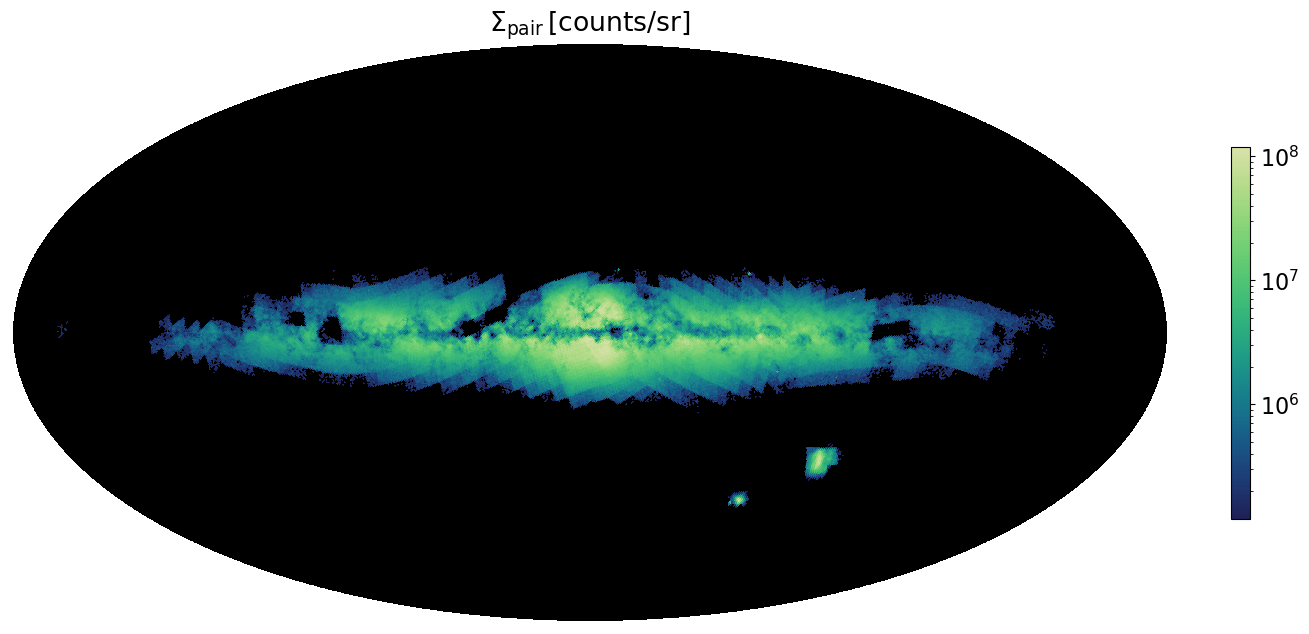

In [15]:
map = 1e-10 + map_count_1 / (hp.pixelfunc.nside2resol(nside))**2 
map_min = 1e-3 * np.max(map); map_max = np.max(map); 
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
cmap = sns.cubehelix_palette(start = 0.25, hue = 1.5, rot = -2/3, reverse = True, as_cmap=True)
#cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
cmap.set_under(cmap(0)); cmap.set_bad(cmap(0)); cmap.set_over(cmap(1));
#cmap.set_under('white'); cmap.set_over('black')
plt.subplots(1,1,figsize=(16,8))
hp.mollview(map, title=r'$\Sigma_\mathrm{pair} \, [\mathrm{counts/sr}]$', 
            cmap=cmap,cbar=None, 
            bgcolor='black',badcolor='white',
            min=map_min,max=map_max,
            xsize=5000,hold=True,
            norm=mpl.colors.LogNorm(vmin=map_min,vmax=map_max))
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.015);
#cbar.set_label(r'$\Sigma_\mathrm{pair} \, [\mathrm{counts/sr}]$', fontsize=16)

mpl.rcParams.update({'font.size': 16})

#fig.savefig(FigDir+'pairs_map_2.pdf',figsize=(8,6),bbox_inches='tight')#,bbox_extra_artists=(image,)',dpi=300,)

# Template functions - pm

In [16]:
## redefine cov matrix
def fn_cov_pm_eff(df):
    """
    Given a panda data frame df, returns the effective covariance matrix for (pmra, pmdec).
    """
    return np.array([[df['pmra_eff_error_new']**2, df['pmra_pmdec_eff_corr_new']*df['pmra_eff_error_new']*df['pmdec_eff_error_new']], 
                     [df['pmra_pmdec_eff_corr_new']*df['pmra_eff_error_new']*df['pmdec_eff_error_new'], df['pmdec_eff_error_new']**2]]).T
    #return np.array([[df['pmra_eff_error_new']**2, np.zeros(len(df))], 
    #                 [np.zeros(len(df)), df['pmdec_eff_error_new']**2]]).T

In [17]:
### Functions for the lens-induced proper motion, parallax and acceleration.

### !!!!! NOTICE that the functions below take into account the finite distance of the background source as well (in the magnitude of the lensing and in the relative velocity between the source and the lens). 
### For background stars that have a negative parallax measurement and or compatible with zero at 2-3*sigma, the coefficient (1-bg_parallax/fg_parallax) should probably be discrded.

def fn_lensing_pm(fg_ra, fg_dec, fg_pmra, fg_pmdec, fg_dist, bg_ra, bg_dec, bg_pmra, bg_pmdec, bg_dist, tau_obs, matched_filter=fn_dipole_mf):
    """
    Computes the lens-induced proper motion on background stars due to the foreground stars. In the template regime, the impact parameter must be larger than the distance travelled by the lens during the observation time tau_obs.    
    Output: list of 2d proper motion vectors (in mas/y) and indices of pairs with impact parameter in the template regime (the other pairs should be discarded).
    """
    l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
    l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
    l_bilhat = np.array([l_bilvec[:, 0]/np.sqrt(l_bilnormsq), l_bilvec[:, 1]/np.sqrt(l_bilnormsq)]).T 
    l_muvec = np.array([fg_pmra - bg_pmra, fg_pmdec - bg_pmdec]).T*mas/Year
    #l_muvec = np.array([fg_pmra, fg_pmdec]).T*mas/Year
    l_munorm = np.sqrt(l_muvec[:, 0]**2 + l_muvec[:, 1]**2)
    l_muhat = np.array([l_muvec[:, 0]/l_munorm, l_muvec[:, 1]/l_munorm]).T 
    l_Dl = fg_dist * pc
    ### Evaluating the matched filter
    l_dipole_vec = matched_filter(l_muhat, l_bilhat)
    
    '''pm_list = np.array([-4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 0], 
                        -4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 1]]).T'''
    
    pm_list = np.array([-(1-fg_dist / bg_dist)*4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 0], 
                        -(1-fg_dist / bg_dist)*4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 1]]).T
#    pm_list = np.array([-(1-fg_dist / bg_dist)*4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 0], 
#                        -(1-fg_dist / bg_dist)*4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 1]]).T
    
    return pm_list[l_bilnormsq > (l_munorm*tau_obs)**2]/(mas/Year), np.arange(len(fg_ra))[l_bilnormsq > (l_munorm*tau_obs)**2]

In [18]:
def fn_tau_mu(df_fore, df_back, weights, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=True):
    """
    For a given data frame of foreground and background stars, return the proper motion tau test statistic and its normalization.
    Weights must be an array of 2x2 matrices of the same lenght of df_fore and df_back, e.g. the pm inverse covariance matrix for each background star.
    If tau_max!=False, only the values of tau < tau_max are kept in the sum over all pairs. 
    """
    
    if not quiet: print('Computing the expected velocity.'); sys.stdout.flush()
    lensing_pm, good_bil_ind = fn_lensing_pm(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy(),
                                             df_fore['pmra'].to_numpy(),  df_fore['pmdec'].to_numpy(), df_fore['dist_50'].to_numpy(),
                                             #df_fore['mass'].to_numpy(),
                                             #df_fore['lum'].to_numpy()**(1/4),
                                             df_back['ra'].to_numpy(), df_back['dec'].to_numpy(),
                                             df_back['pmra'].to_numpy(), df_back['pmdec'].to_numpy(), df_back['dist_50'].to_numpy(), tau_obs, matched_filter)

    if(len(lensing_pm) < len(df_back)):
        if not quiet: print((len(df_back)-len(lensing_pm)), 'star pairs have too small impact parameter. Selecting only the good pairs.'); sys.stdout.flush()
        df_back = df_back.iloc[good_bil_ind]; weights = weights[good_bil_ind]
    
    if rot_angle:
        if not quiet: print('Rotating the dipole profile by', rot_angle/degree, 'deg'); sys.stdout.flush()
        costh, sinth = np.cos(rot_angle), np.sin(rot_angle)
        lensing_pm = np.array([lensing_pm[:,0]*costh-lensing_pm[:,1]*sinth, lensing_pm[:,1]*costh+lensing_pm[:,0]*sinth]).T


    if not quiet: print('Computing the tau lists.'); sys.stdout.flush()
    ### Observed background stars' proper motion (after subtraction)
    observed_pm = np.array([df_back['pmra_sub_new'].to_numpy(), df_back['pmdec_sub_new'].to_numpy()]).T
    #tau_norm_sq = weights[:, 0, 0]*lensing_pm[:, 0]**2 + weights[:, 1, 1]*lensing_pm[:, 1]**2 + 2*weights[:, 0, 1]*lensing_pm[:, 0]*lensing_pm[:, 1]
    tau_norm_sq = (lensing_pm[:, 0]**2 + lensing_pm[:, 1]**2)/(1/weights[:, 0, 0] + 1/weights[:, 1, 1]) 
    tau_mu = (weights[:, 0, 0]*lensing_pm[:, 0]*observed_pm[:, 0] + weights[:, 1, 1]*lensing_pm[:, 1]*observed_pm[:, 1] + 
              weights[:, 0, 1]*(lensing_pm[:, 0]*observed_pm[:, 1] + lensing_pm[:, 1]*observed_pm[:, 0]))

    if not quiet: print('Computing the sum.'); sys.stdout.flush()
    if tau_max!=0:
        small_tau_mu = tau_mu[np.abs(tau_mu) < tau_max]
        if not quiet: print(str((1-len(small_tau_mu)/len(tau_mu))*100)+'% of taus removed')
        return sum(small_tau_mu), np.sqrt(sum(tau_norm_sq[np.abs(tau_mu) < tau_max]))
    else:
        return tau_mu, tau_norm_sq, good_bil_ind # sum(tau_mu), np.sqrt(sum(tau_norm_sq))    

# Evaluation

In [19]:
tau_obs = 2.833*Year

In [20]:
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back))

In [21]:
tau_mu_list, tau_norm_sq_list, good_bil_ind = fn_tau_mu(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=False)
tau_mu, tau_norm = sum(tau_mu_list), np.sqrt(sum(tau_norm_sq_list))  

Computing the expected velocity.
15 star pairs have too small impact parameter. Selecting only the good pairs.
Computing the tau lists.
Computing the sum.


In [22]:
tau_mu_list_90deg, tau_norm_sq_list_90deg, good_bil_ind = fn_tau_mu(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=np.pi/4, quiet=True)
tau_mu_90deg, tau_norm_90deg = sum(tau_mu_list_90deg), np.sqrt(sum(tau_norm_sq_list_90deg))  

In [23]:
tau_mu_list_mon, tau_norm_sq_list_mon, good_bil_ind = fn_tau_mu(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_monopole_mf, rot_angle=np.pi/4, quiet=True)
tau_mu_mon, tau_norm_mon = sum(tau_mu_list_mon), np.sqrt(sum(tau_norm_sq_list_mon))  

In [24]:
print('T   : ' + str(tau_mu))
print('N   : ' + str(tau_norm))
print('T/N : ' + str(tau_mu/tau_norm))

T   : 1.1529473515334538
N   : 0.23855303932444596
T/N : 4.833085987076353


In [25]:
print('Dipole rotated by 90 degrees')
print('T   : ' + str(tau_mu_90deg))
print('N   : ' + str(tau_norm_90deg))
print('T/N : ' + str(tau_mu_90deg/tau_norm_90deg))

Dipole rotated by 90 degrees
T   : 1.0172365122974851
N   : 0.238553039324446
T/N : 4.264194307388322


In [26]:
print('Monopole')
print('T   : ' + str(tau_mu_mon))
print('N   : ' + str(tau_norm_mon))
print('T/N : ' + str(tau_mu_mon/tau_norm_mon))

Monopole
T   : 1.1096964262588718
N   : 0.238553039324446
T/N : 4.651780708396761


In [27]:
from scipy.stats import norm
  
# Fit a normal distribution to the distribution of T/N
mu, std = norm.fit(tau_mu_list/np.sqrt(tau_norm_sq_list)) 

In [28]:
max(norm.pdf(np.linspace(-3.1, 3.1, 70), mu, std))

0.2767510290466438

In [29]:
mu, std

(0.006269527720465006, 1.4410018591842135)

In [30]:
df_fore.iloc[np.argmax(tau_mu_list/np.sqrt(tau_norm_sq_list))][['dist_50', 'mass']]

KeyError: "['mass'] not in index"

In [ ]:
tau_mu_list[np.argmax(tau_mu_list/np.sqrt(tau_norm_sq_list))], np.sqrt(tau_norm_sq_list)[np.argmax(tau_mu_list/np.sqrt(tau_norm_sq_list))]

(8.469727868502337e-07, 8.569716946223567e-08)

In [ ]:
np.sqrt(l_bilnormsq[np.argmax(tau_mu_list/np.sqrt(tau_norm_sq_list))])/arcsec

2.661147077716536

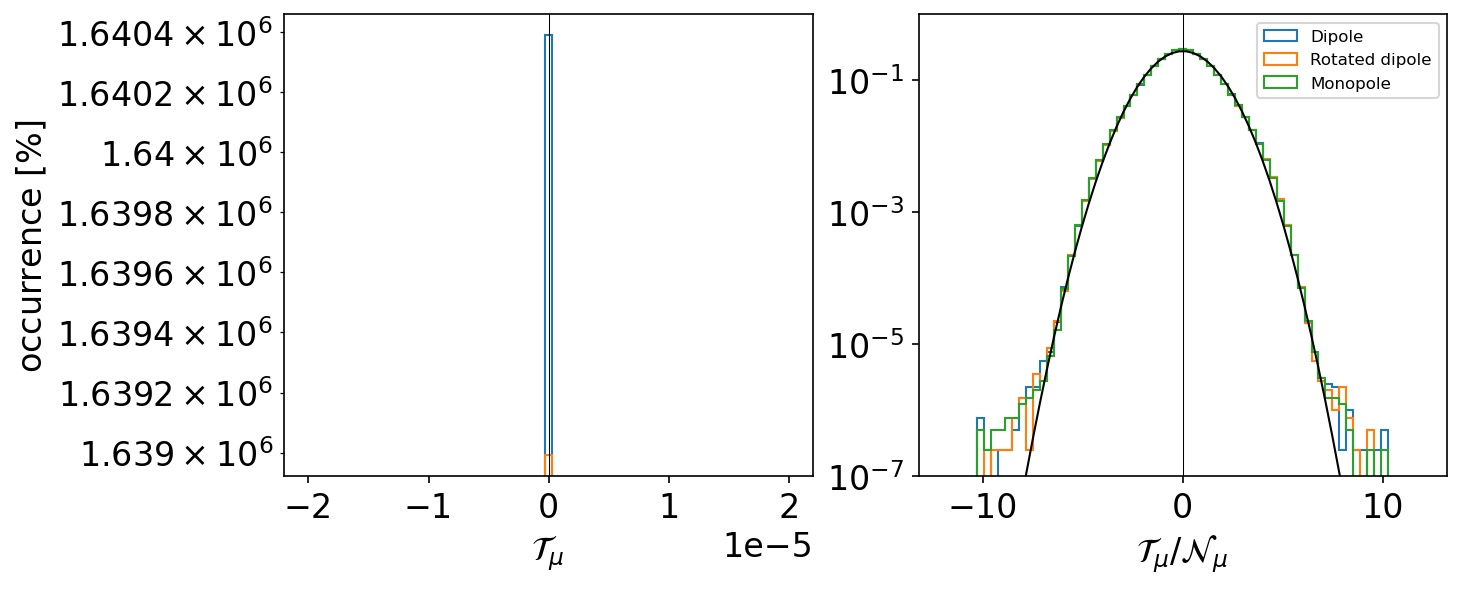

In [31]:
fig,ax = plt.subplots(1,2,figsize=(10,4), dpi = 150)

ax[0].hist(tau_mu_list, bins=np.linspace(-0.00002, 0.00002, 70), log=False, density=False, histtype='step');
ax[0].hist(tau_mu_list_90deg, bins=np.linspace(-0.00002, 0.00002, 70), log=False, density=False, histtype='step');
ax[0].set_xlabel(r'$\mathcal{T}_{\mu}$ '); ax[0].set_ylabel(r'occurrence [$\%$]');
ax[0].axvline(0, color='k', linewidth=0.5)
ax[0].set_yscale('log')  

bins = np.linspace(-12, 12, 70)

h = ax[1].hist(tau_mu_list/np.sqrt(tau_norm_sq_list), bins=bins, log=False, density=True, histtype='step');
ax[1].hist(tau_mu_list_90deg/np.sqrt(tau_norm_sq_list_90deg), bins=bins, log=False, density=True, histtype='step');
ax[1].hist(tau_mu_list_mon/np.sqrt(tau_norm_sq_list_mon), bins=bins, log=False, density=True, histtype='step');
ax[1].legend(['Dipole', 'Rotated dipole', 'Monopole'], loc='upper right', frameon=True, fontsize=8)
ax[1].set_xlabel(r'$\mathcal{T}_{\mu}/\mathcal{N}_{\mu}$ ');
ax[1].axvline(0, color='k', linewidth=0.5)
ax[1].plot(bins,  norm.pdf(bins, mu, std), 'k', linewidth=1)
ax[1].set_yscale('log')  
ax[1].set_ylim(1e-7, 1);  


# With and without mass weighting

In [121]:
df_back

source_id          ra        dec      pmra     pmdec  \
0         407652079258216832   26.833258  51.855765 -4.064927 -1.565365   
1         407670053694081536   26.529999  52.070850 -2.963004 -0.583585   
2         407745301525056256   28.135469  52.558146 -1.199981 -1.201087   
3         407818041090608384   27.248774  52.956444 -0.443197 -0.612761   
4         407870164811431552   26.579393  52.453189 -0.758300 -0.242869   
...                      ...         ...        ...       ...       ...   
7339092  6764395645195995008  286.702925 -24.943808 -6.547409 -4.257561   
7339093  6764400459856491904  286.959903 -24.814410  0.726159 -6.218973   
7339094  6764403792752241536  286.750590 -24.768030  0.947705 -4.734969   
7339095  6764403792752241664  286.749851 -24.768231 -1.230452 -6.258204   
7339096  6764404205068135168  286.776797 -24.739748 -4.345762 -5.209335   

         pmra_error  pmdec_error  pmra_pmdec_corr  parallax  parallax_error  \
0          0.126139     0.116540         0.012693  0.406816        0.124430   
1          0.075206     0.069984         0.045255  0.351316        0.075596   
2          0.088220     0.075072        -0.079274  0.324604        0.076862   
3          0.097763     0.084193        -0.033119  0.162303        0.086288   
4          0.131261     0.101988        -0.218260  0.151688        0.119610   
...             ...          ...              ...       ...             ...   
7339092    0.435546     0.345680        -0.025354 -0.632005        0.367965   
7339093    0.333150     0.304717         0.349956  0.266297        0.286263   
7339094    0.214560     0.177042         0.157865 -0.067881        0.190301   
7339095    0.258761     0.218863         0.186150  0.121720        0.229431   
7339096    0.197926     0.170472         0.340317  0.198237        0.177872   

         ...  pmdec_sub_new  parallax_sub_new  pmra_eff_error_new  \
0        ...      -1.160469          0.093985            1.910270   
1        ...      -0.191498          0.031630            1.937944   
2        ...      -0.760469          0.030890            1.830878   
3        ...      -0.107121         -0.096613            1.676750   
4        ...       0.252752         -0.112590            1.701408   
...      ...            ...               ...                 ...   
7339092  ...       0.700850         -0.350562            2.329336   
7339093  ...      -1.682934          0.546917            2.767953   
7339094  ...      -0.220999         -0.077797            2.465034   
7339095  ...      -1.973859          0.157605            2.539053   
7339096  ...      -0.923851          0.235687            2.536410   

         pmdec_eff_error_new  pmra_pmdec_eff_corr_new  parallax_eff_error_new  \
0                   1.552029                -0.151126                0.080468   
1                   1.571456                -0.157471                0.081716   
2                   1.496515                -0.131461                0.076881   
3                   1.389788                -0.085938                0.069880   
4                   1.406761                -0.093967                0.071004   
...                      ...                      ...                     ...   
7339092             2.878635                 0.236486                0.315528   
7339093             2.761677                 0.117668                0.303018   
7339094             2.690545                 0.052801                0.154764   
7339095             2.654047                 0.117623                0.193855   
7339096             2.653745                 0.118038                0.194135   

         dotprod_bil  dotperp_bil    mu_par   mu_perp  
0          -1.647418     2.151870 -1.267772 -2.657519  
1          -2.934179     0.413362  1.257928 -0.991460  
2           2.878804    -0.706541  0.469551 -0.610080  
3           1.869554    -2.099088  0.091140  0.807599  
4          -2.845591     0.924399  0.398633  0.395536  
...              ...          .

In [16]:
tau_obs = 2.833*Year

In [87]:
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back))

In [89]:
with_params = ~np.isnan(df_fore['lum'])
with_mass = ~np.isnan(df_fore['mass'])

In [18]:
tau_mu_list, tau_norm_sq_list, good_bil_ind = fn_tau_mu(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=False)
tau_mu, tau_norm = sum(tau_mu_list), np.sqrt(sum(tau_norm_sq_list))  

Computing the expected velocity.
13 star pairs have too small impact parameter. Selecting only the good pairs.
Computing the tau lists.
Computing the sum.


In [112]:
print('All the stars, without the mass weights:')
print('T   : ' + str(tau_mu))
print('N   : ' + str(tau_norm))
print('T/N : ' + str(tau_mu/tau_norm))

All the stars, without the mass weights:
T   : 0.5712459604231644
N   : 0.20165475814568373
T/N : 2.8327918749651957


In [114]:
len(tau_mu_list), len(tau_mu_list[with_mass]), np.sqrt(len(tau_mu_list[with_mass]))/np.sqrt(len(tau_mu_list))

(7339084, 1863789, 0.5039383885198278)

In [117]:
print('Stars with mass measurement, no weights:')
print('T   : ' + str(np.sum(tau_mu_list[with_mass])))
print('N   : ' + str(np.sqrt(np.sum(tau_norm_sq_list[with_mass]))))
print('T/N : ' + str(np.sum(tau_mu_list[with_mass])/np.sqrt(np.sum(tau_norm_sq_list[with_mass]))))

Stars with mass measurement, no weights:
T   : 0.05110289294675527
N   : 0.027854186488092673
T/N : 1.8346575287201847


In [120]:
print('Stars with mass measurement, WITH weights:')
print('T   : ' + str(np.sum(tau_mu_list[with_mass])))
print('N   : ' + str(np.sqrt(np.sum(tau_norm_sq_list[with_mass]))))
print('T/N : ' + str(np.sum(tau_mu_list[with_mass])/np.sqrt(np.sum(tau_norm_sq_list[with_mass]))))

Stars with mass measurement, WITH weights:
T   : 0.05513756584359299
N   : 0.01879913549340386
T/N : 2.932984118495202


# Dependence on foreground distance and impact parameter

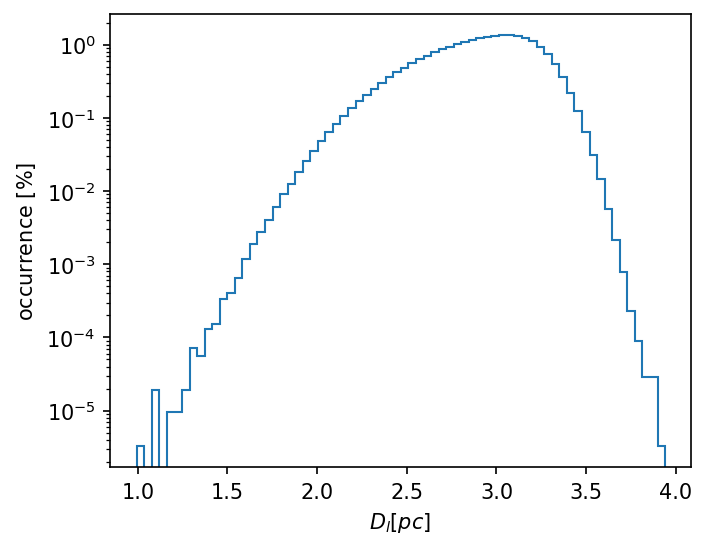

In [19]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.hist(np.log10(df_fore['dist_50'].to_numpy()), bins=70, log=True, density=True, histtype='step');
ax.set_xlabel(r'$D_l [pc]$ '); ax.set_ylabel(r'occurrence [$\%$]');

In [168]:
sigma_mu = np.sqrt(df_back['pmra_eff_error_new'].to_numpy()**2 + df_back['pmdec_eff_error_new'].to_numpy()**2 + 
                   2*df_back['pmra_pmdec_eff_corr_new'].to_numpy()*df_back['pmra_eff_error_new'].to_numpy()*df_back['pmdec_eff_error_new'].to_numpy() )
sigma_mu = sigma_mu[good_bil_ind]

In [140]:
np.min(df_fore['dist_50'].to_numpy()), np.max(df_fore['dist_50'].to_numpy())

(9.854347, 8717.23)

In [206]:
fore_dist = df_fore.iloc[good_bil_ind]['dist_50'].to_numpy()
dist_bins = np.logspace(0.99, 4, num=15)
dist_bins

array([9.77237221e+00, 1.60324539e+01, 2.63026799e+01, 4.31519077e+01, 7.07945784e+01, 1.16144861e+02, 1.90546072e+02, 3.12607937e+02, 5.12861384e+02, 8.41395142e+02, 1.38038426e+03, 2.26464431e+03,
       3.71535229e+03, 6.09536897e+03, 1.00000000e+04])

In [207]:
dist_counts = np.histogram(fore_dist, bins=dist_bins)[0]

tau_hist = np.histogram(fore_dist, bins=dist_bins, weights=tau_mu_list )[0]
nsq_hist = np.histogram(fore_dist, bins=dist_bins, weights=tau_norm_sq_list )[0]
sigmamu_dist_hist = np.histogram(fore_dist, bins=dist_bins, weights=sigma_mu )[0]
sigmamu_dist_hist = np.divide(sigmamu_dist_hist, dist_counts, out=np.zeros(len(dist_counts)), where=(dist_counts>0)) 

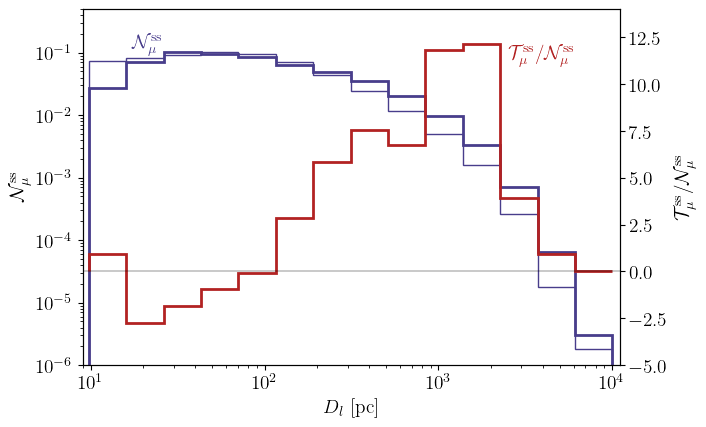

In [208]:
goldenratio = 1.61803
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5*goldenratio, 4.5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
fonts = 14
ax.minorticks_on()

ax.hist(dist_bins[:-1], bins=dist_bins, log=True, density=False, histtype='step', weights=np.sqrt(nsq_hist), color=colorlist[0], linewidth=2);
#ax.hist(dist_bins[:-1], bins=dist_bins, log=True, density=False, histtype='step', weights=2*np.sqrt(dist_counts)/dist_bins[:-1]**2, color=colorlist[0], linewidth=1);
ax.hist(dist_bins[:-1], bins=dist_bins, log=True, density=False, histtype='step', weights=8*np.sqrt(dist_counts)/dist_bins[:-1]**2/sigmamu_dist_hist, color=colorlist[0], linewidth=1);
ax.set_xlim(9, 11000); ax.set_ylim(1E-6,0.5)

ax2 = ax.twinx()    
ax2.hist(dist_bins[:-1], bins=dist_bins, log=False, density=False, histtype='step', weights=tau_hist/np.sqrt(nsq_hist), color=colorlist[1], linewidth=2)
#ax2.hist(dist_bins[:-1], bins=dist_bins, log=True, density=False, histtype='step', weights=tau_hist, color=colorlist[1], linewidth=2)
ax2.axhline(0, 0,1, linewidth=0.3, color='k')
ax2.set_ylim(-5,14)

ax2.set_ylabel(r'$\mathcal{T}^{\rm{ss}}_{\mu}/\mathcal{N}^{\rm{ss}}_{\mu}$', fontsize = fonts)
ax.set_ylabel(r'$\mathcal{N}^{\rm{ss}}_{\mu}$', fontsize = fonts)
ax.set_xlabel(r'$D_l$ [pc]', fontsize = fonts)

#ax.set_title('Proper motion dispersion of the background stars ', fontsize = 18, pad=12)
ax.text(2500, 0.08, r'$\mathcal{T}^{\rm{ss}}_{\mu}/\mathcal{N}^{\rm{ss}}_{\mu}$', color=colorlist[1], fontsize = fonts)
ax.text(17, 0.12, r'$\mathcal{N}^{\rm{ss}}_{\mu}$', color=colorlist[0], fontsize = fonts)
#ax.text(17, 0.03, r'$\frac{\sqrt{N_{\rm{s}}}}{D_l^2}$', color=colorlist[0], alpha=0.3, fontsize = 12)

ax.set_xscale('log')

fig.tight_layout()
#fig.savefig(FigDir+'starstar_histo.pdf')

In [117]:
### Impact parameter and unit vector in the direction of the impact parameter
bil = fn_angular_sep(df_back['ra'].to_numpy()*degree, df_back['dec'].to_numpy()*degree,
                     df_fore['ra'].to_numpy()*degree, df_fore['dec'].to_numpy()*degree)
bil_norm = np.sqrt(bil[:, 0]**2+bil[:, 1]**2)/arcsec
bil_norm = bil_norm[good_bil_ind]

np.min(bil_norm), np.max(bil_norm)

(0.6000153125570444, 2.9999999422979227)

In [216]:
bins_bil = np.arange(0.6, 3.2, 0.2)
bins_bil

array([0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ])

In [217]:
bil_counts = np.histogram(bil_norm, bins=bins_bil)[0]

tau_bil_hist = np.histogram(bil_norm, bins=bins_bil, weights=tau_mu_list )[0]
nsq_bil_hist = np.histogram(bil_norm, bins=bins_bil, weights=tau_norm_sq_list )[0]
sigmamu_bil_hist = np.histogram(bil_norm, bins=bins_bil, weights=sigma_mu )[0]
sigmamu_bil_hist = np.divide(sigmamu_bil_hist, bil_counts, out=np.zeros(len(bil_counts)), where=(bil_counts>0)) 

In [218]:
bil_counts

array([   9776,   43871,  108280,  249649,  440668,  611975,  718492,  837356,  942489, 1037773, 1123766, 1214989])

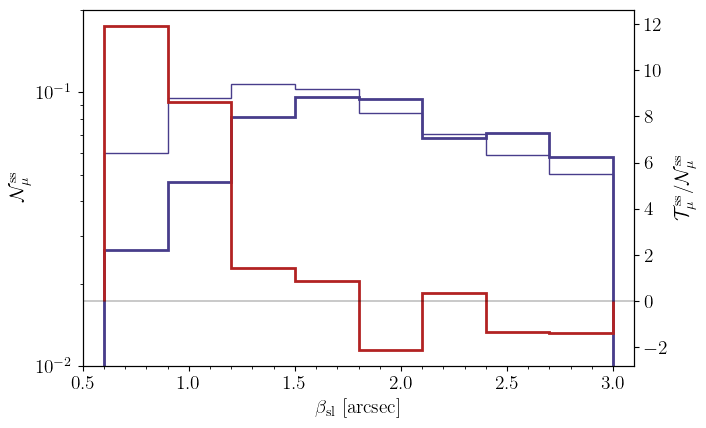

In [192]:
goldenratio = 1.61803
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5*goldenratio, 4.5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
fonts = 14
ax.minorticks_on()

ax.hist(bins_bil[:-1], bins=bins_bil, log=True, density=False, histtype='step', weights=np.sqrt(nsq_bil_hist), color=colorlist[0], linewidth=2);
ax.hist(bins_bil[:-1], bins=bins_bil, log=True, density=False, histtype='step', weights=1E-3*np.sqrt(bil_counts)/(bins_bil[:-1]*bins_bil[1:])/sigmamu_bil_hist, color=colorlist[0], linewidth=1);
ax.set_xlim(0.5, 3.1); ax.set_ylim(1E-2,0.2)

ax2 = ax.twinx()    
ax2.hist(bins_bil[:-1], bins=bins_bil, log=False, density=False, histtype='step', weights=tau_bil_hist/np.sqrt(nsq_bil_hist), color=colorlist[1], linewidth=2)
#ax2.hist(bins_bil[:-1], bins=bins_bil, log=True, density=False, histtype='step', weights=tau_hist, color=colorlist[1], linewidth=2)
ax2.axhline(0, 0,1, linewidth=0.3, color='k')
#ax2.set_ylim(-5,14)

ax2.set_ylabel(r'$\mathcal{T}^{\rm{ss}}_{\mu}/\mathcal{N}^{\rm{ss}}_{\mu}$', fontsize = fonts)
ax.set_ylabel(r'$\mathcal{N}^{\rm{ss}}_{\mu}$', fontsize = fonts)
ax.set_xlabel(r'$\beta_{\rm{sl}}$ [arcsec]', fontsize = fonts)

#ax.set_title('Proper motion dispersion of the background stars ', fontsize = 18, pad=12)
#ax.text(2500, 0.08, r'$\mathcal{T}^{\rm{ss}}_{\mu}/\mathcal{N}^{\rm{ss}}_{\mu}$', color=colorlist[1], fontsize = fonts)
#ax.text(17, 0.12, r'$\mathcal{N}^{\rm{ss}}_{\mu}$', color=colorlist[0], fontsize = fonts)
#ax.text(17, 0.03, r'$\frac{\sqrt{N_{\rm{s}}}}{D_l^2}$', color=colorlist[0], alpha=0.3, fontsize = 12)

#ax.set_xscale('log')

fig.tight_layout()
#fig.savefig(FigDir+'starstar_histo.pdf')

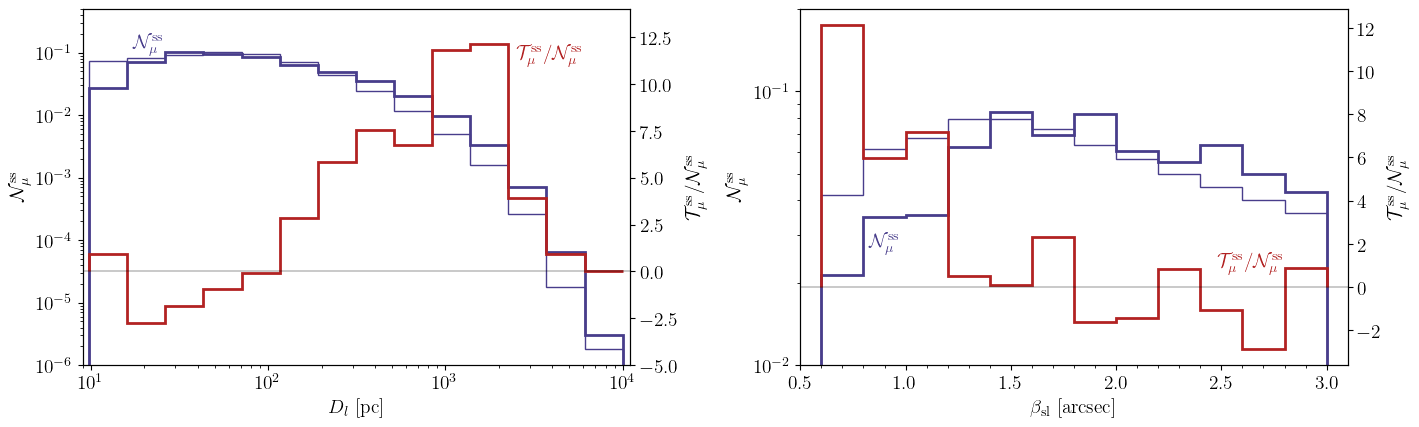

In [255]:
goldenratio = 1.61803
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9*goldenratio, 4.5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
fonts = 14

ax[0].minorticks_on()
ax[0].hist(dist_bins[:-1], bins=dist_bins, log=True, density=False, histtype='step', weights=np.sqrt(nsq_hist), color=colorlist[0], linewidth=2);
ax[0].hist(dist_bins[:-1], bins=dist_bins, log=True, density=False, histtype='step', weights=8*np.sqrt(dist_counts)/dist_bins[:-1]**2/sigmamu_dist_hist, color=colorlist[0], linewidth=1);
ax[0].set_xlim(9, 11000); ax[0].set_ylim(1E-6,0.5)

ax2 = ax[0].twinx()    
ax2.hist(dist_bins[:-1], bins=dist_bins, log=False, density=False, histtype='step', weights=tau_hist/np.sqrt(nsq_hist), color=colorlist[1], linewidth=2)
ax2.axhline(0, 0,1, linewidth=0.3, color='k')
ax2.set_ylim(-5,14)

ax2.set_ylabel(r'$\mathcal{T}^{\rm{ss}}_{\mu}/\mathcal{N}^{\rm{ss}}_{\mu}$', fontsize = fonts)
ax[0].set_ylabel(r'$\mathcal{N}^{\rm{ss}}_{\mu}$', fontsize = fonts)
ax[0].set_xlabel(r'$D_l$ [pc]', fontsize = fonts)

ax[0].text(2500, 0.08, r'$\mathcal{T}^{\rm{ss}}_{\mu}/\mathcal{N}^{\rm{ss}}_{\mu}$', color=colorlist[1], fontsize = fonts)
ax[0].text(17, 0.12, r'$\mathcal{N}^{\rm{ss}}_{\mu}$', color=colorlist[0], fontsize = fonts)

ax[0].set_xscale('log')

ax[1].minorticks_on()
ax[1].hist(bins_bil[:-1], bins=bins_bil, log=True, density=False, histtype='step', weights=np.sqrt(nsq_bil_hist), color=colorlist[0], linewidth=2);
ax[1].hist(bins_bil[:-1], bins=bins_bil, log=True, density=False, histtype='step', weights=0.9E-3*np.sqrt(bil_counts)/(bins_bil[:-1]*bins_bil[1:])/sigmamu_bil_hist, color=colorlist[0], linewidth=1);
ax[1].set_xlim(0.5, 3.1); ax[1].set_ylim(1E-2,0.2)

ax2 = ax[1].twinx()    
ax2.hist(bins_bil[:-1], bins=bins_bil, log=False, density=False, histtype='step', weights=tau_bil_hist/np.sqrt(nsq_bil_hist), color=colorlist[1], linewidth=2)
ax2.axhline(0, 0,1, linewidth=0.3, color='k')

ax2.set_ylabel(r'$\mathcal{T}^{\rm{ss}}_{\mu}/\mathcal{N}^{\rm{ss}}_{\mu}$', fontsize = fonts)
ax[1].set_ylabel(r'$\mathcal{N}^{\rm{ss}}_{\mu}$', fontsize = fonts)
ax[1].set_xlabel(r'$\beta_{\rm{sl}}$ [arcsec]', fontsize = fonts)

ax[1].text(2.48, 0.023, r'$\mathcal{T}^{\rm{ss}}_{\mu}/\mathcal{N}^{\rm{ss}}_{\mu}$', color=colorlist[1], fontsize = fonts)
ax[1].text(0.82, 0.027, r'$\mathcal{N}^{\rm{ss}}_{\mu}$', color=colorlist[0], fontsize = fonts)

fig.tight_layout()
fig.savefig(FigDir+'starstar_tau_histo.pdf')

# Astrophysical parameters

In [4]:
df_fore_params = pd.read_csv(DataDir+'fg_params.csv') 
df_fore_params

Unnamed: 0            source_id      mass  mass_lower  mass_upper  \
0                 0        8250632981888       NaN         NaN         NaN   
1                 1       17390323414528       NaN         NaN         NaN   
2                 2       44362718023680       NaN         NaN         NaN   
3                 3      116479515230592       NaN         NaN         NaN   
4                 4      250658586976512       NaN         NaN         NaN   
...             ...                  ...       ...         ...         ...   
8117464     8117464  6917468043401298944  1.490971    1.447693    1.535409   
8117465     8117465  6917478145164462592       NaN         NaN         NaN   
8117466     8117466  6917488998547840384       NaN         NaN         NaN   
8117467     8117467  6917516250114305920       NaN         NaN         NaN   
8117468     8117468  6917527966785173248       NaN         NaN         NaN   

              lum  lum_lower  lum_upper       teff  teff_lower  teff_upper  \
0             NaN        NaN        NaN  5562.0205   5548.3700   5584.4165   
1             NaN        NaN        NaN        NaN         NaN         NaN   
2             NaN        NaN        NaN        NaN         NaN         NaN   
3             NaN        NaN        NaN        NaN         NaN         NaN   
4        1.039218   0.999042   1.080230  5161.6987   5141.6187   5196.9756   
...           ...        ...        ...        ...         ...         ...   
8117464  7.296951   6.766074   7.726905  5176.8555   5162.7075   5191.8600   
8117465  0.026552   0.021525   0.031566  3481.4102   3471.9243   3491.8958   
8117466       NaN        NaN        NaN        NaN         NaN         NaN   
8117467  0.046483   0.040498   0.052167  3636.0720   3617.5810   3654.6210   
8117468  0.010502   0.010000   0.015518  3325.8748   3321.3718   3329.6802   

              mg  mg_lower  mg_upper  
0         6.0129    5.8658    6.0980  
1            NaN       NaN       NaN  
2            NaN       NaN       NaN  
3            NaN       NaN       NaN  
4         4.8155    4.7505    4.8430  
...          ...       ...       ...  
8117464   2.6001    2.5298    2.6619  
8117465   9.3582    9.3366    9.3774  
8117466      NaN       NaN       NaN  
8117467   8.1707    7.8149    8.6353  
8117468  10.4002   10.3498   10.4486  

[8117469 rows x 14 columns]

In [5]:
### Check how many stars have a measurement
len(df_fore_params[~np.isnan(df_fore_params['teff'])]), len(df_fore_params[~np.isnan(df_fore_params['lum'])]), len(df_fore_params[~np.isnan(df_fore_params['mass'])])

(4354156, 3831306, 2705730)

In [6]:
### Take only the stars that have a measurement and remove repeated entries
df_fore_params = df_fore_params[~np.isnan(df_fore_params['teff'])]

### Remove duplicates
aa, params_unique = np.unique(df_fore_params['source_id'].to_numpy(), return_index=True)
df_fore_params = df_fore_params.iloc[params_unique]
print(len(df_fore_params))
id_params = df_fore_params['source_id'].to_numpy()

4078217


In [7]:
### Take source id of our sample and remove repeated entries
id_sub = df_fore['source_id'].to_numpy()
id_sub_unique, index_unique, inverse, count = np.unique(id_sub, return_index=True, return_inverse=True, return_counts=True)

In [8]:
### Data frame with the unique entries
df_fore_unique = pd.DataFrame(data={'source_id': id_sub_unique})

In [9]:
### Find intersection between the two lists
id_inter, index_sub, index_params = np.intersect1d(id_sub_unique, id_params, assume_unique=True, return_indices=True)
len(id_inter)

2739318

In [10]:
columns_to_add = ['source_id', 'mass', 'lum']

In [11]:
temp_param_list = np.zeros((len(id_sub_unique), len(columns_to_add)))*np.nan

for i_col, col in enumerate(columns_to_add):
    print(col)
    temp_param_list[:, i_col][index_sub] = df_fore_params.iloc[index_params][col]
    df_fore_unique[col] = temp_param_list[:, i_col]
    
#temp_param_list[index_sub] = df_fore_params.iloc[index_params][['source_id', 'mass', 'mass_lower', 'mass_upper', 'lum', 'lum_lower', 'lum_upper', 'teff', 'teff_lower', 'teff_upper', 'mg', 'mg_lower', 'mg_upper']]
#len(temp_param_list[:, 0][~np.isnan(temp_param_list[:, 0])])

source_id
mass
lum


In [13]:
len(df_fore_unique[~np.isnan(df_fore_unique['mass'])])

1742211

In [14]:
for col in columns_to_add:
    df_fore[col] = df_fore_unique.iloc[inverse][col].to_numpy()

In [195]:
#df_fore['mass'] = df_fore_unique.iloc[inverse]['mass'].to_numpy()

In [200]:
#df_fore['source_id_2'] = df_fore_unique.iloc[inverse]['source_id'].to_numpy()
#aa = df_fore['source_id_2']/df_fore['source_id']
#aa[np.abs(aa-1)>0.0001]

In [27]:
len(df_fore[~np.isnan(df_fore['mass'])])/len(df_fore)

0.25395344958650906

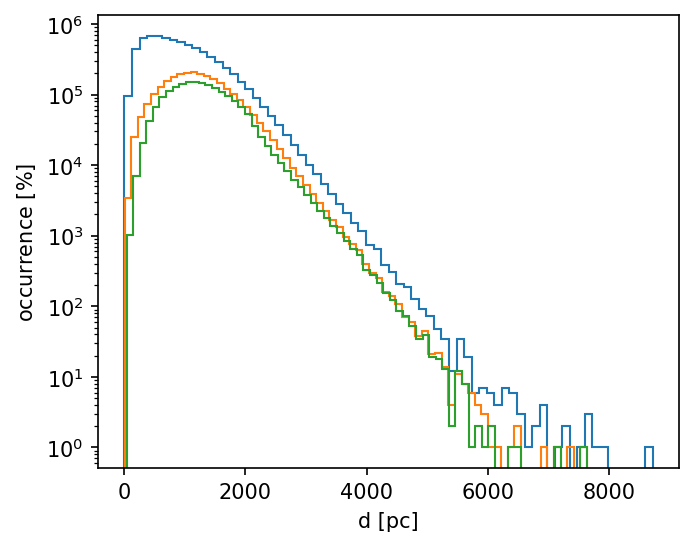

In [16]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.hist(df_fore['dist_50'].to_numpy(), bins=70, log=True, density=False, histtype='step');
ax.hist(df_fore[~np.isnan(df_fore['lum'])]['dist_50'].to_numpy(), bins=70, log=True, density=False, histtype='step');
ax.hist(df_fore[~np.isnan(df_fore['mass'])]['dist_50'].to_numpy(), bins=70, log=True, density=False, histtype='step');
ax.set_xlabel(r'd [pc]'); ax.set_ylabel(r'occurrence [$\%$]');

In [17]:
df_fore.to_csv(DataDir+'fg_subtracted_params.csv', index=False, chunksize=100000)

# Plots

In [68]:
df_back = df_back.iloc[good_bil_ind]
df_fore = df_fore.iloc[good_bil_ind]

In [70]:
fg_ra = df_fore['ra'] 
fg_dec = df_fore['dec']
fg_pmra= df_fore['pmra'] 
fg_pmdec= df_fore['pmdec']

bg_ra = df_back['ra']
bg_dec = df_back['dec'] 
bg_pmra= df_back['pmra_sub_new'] 
bg_pmdec= df_back['pmdec_sub_new'] 

#bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2

l_bilhat = np.array([l_bilvec[:, 0]/np.sqrt(l_bilnormsq), l_bilvec[:, 1]/np.sqrt(l_bilnormsq)]).T 
l_bilhatperp = np.array([-l_bilhat[:, 1], l_bilhat[:, 0]]).T

#foreground mu vectors
l_muvec = np.array([fg_pmra, fg_pmdec]).T*mas/Year
#l_muvec = np.array([fg_pmra - bg_pmra, fg_pmdec - bg_pmdec]).T*mas/Year

l_munormsq = l_muvec[:, 0]**2 + l_muvec[:, 1]**2
l_muhat = np.array([l_muvec[:, 0]/np.sqrt(l_munormsq), l_muvec[:, 1]/np.sqrt(l_munormsq)]).T 
l_muhatperp = np.array([-l_muhat[:, 1], l_muhat[:, 0]]).T

# project bil onto fg mu
df_back['dotprod_bil'] = (l_bilvec[:,0]*l_muhat[:,0] + l_bilvec[:,1]*l_muhat[:,1])/arcsec
df_back['dotperp_bil'] = (l_bilvec[:,0]*l_muhatperp[:,0] + l_bilvec[:,1]*l_muhatperp[:,1])/arcsec

# bg's motion parallel to and perpendicular to fg's motion
df_back['mu_par'] = (bg_pmra*l_muhat[:,0] + bg_pmdec*l_muhat[:,1])
df_back['mu_perp'] = (bg_pmra*l_muhatperp[:,0] + bg_pmdec*l_muhatperp[:,1])

In [75]:
with_params = ~np.isnan(df_fore['lum'])
with_mass = ~np.isnan(df_fore['mass'])

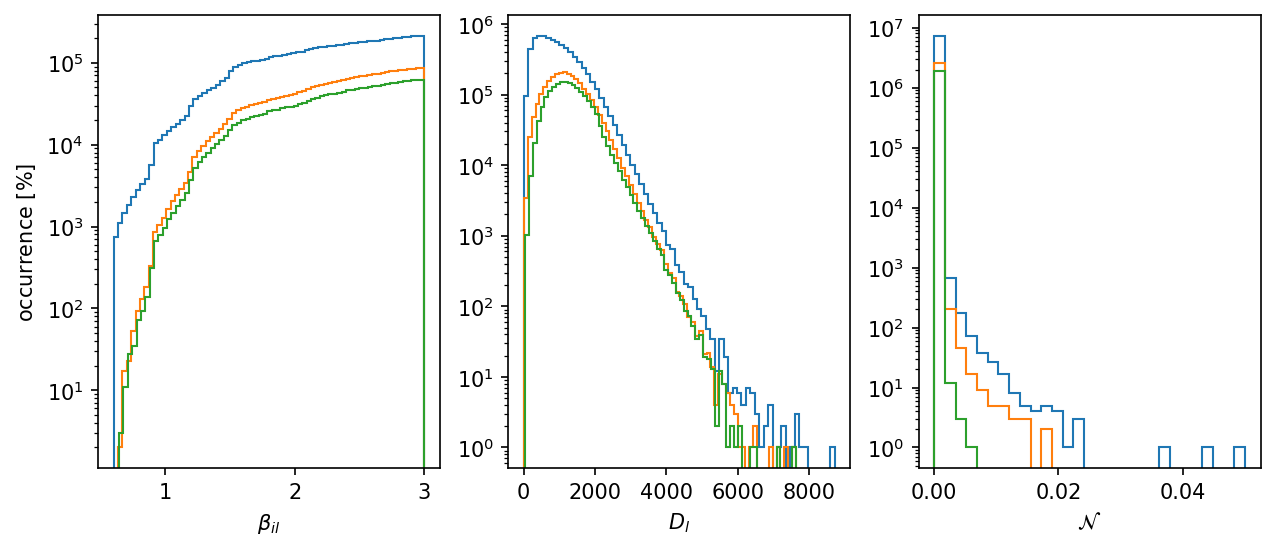

In [79]:
fig,ax = plt.subplots(1,3,figsize=(10,4), dpi = 150)

ax[0].hist(np.sqrt(l_bilnormsq)/arcsec, bins=70, log=True, density=False, histtype='step');
ax[0].hist(np.sqrt(l_bilnormsq[with_params])/arcsec, bins=70, log=True, density=False, histtype='step');
ax[0].hist(np.sqrt(l_bilnormsq[with_mass])/arcsec, bins=70, log=True, density=False, histtype='step');
ax[0].set_xlabel(r'$\beta_{il}$ '); ax[0].set_ylabel(r'occurrence [$\%$]');

ax[1].hist(df_fore['dist_50'].to_numpy(), bins=70, log=True, density=False, histtype='step');
ax[1].hist(df_fore['dist_50'][with_params].to_numpy(), bins=70, log=True, density=False, histtype='step');
ax[1].hist(df_fore['dist_50'][with_mass].to_numpy(), bins=70, log=True, density=False, histtype='step');
ax[1].set_xlabel(r'$D_{l}$ '); 

ax[2].hist(np.sqrt(tau_norm_sq_list), bins=np.linspace(0, 0.05, 30), log=True, density=False, histtype='step');
ax[2].hist(np.sqrt(tau_norm_sq_list[with_params]), bins=np.linspace(0, 0.05, 30), log=True, density=False, histtype='step');
ax[2].hist(np.sqrt(tau_norm_sq_list[with_mass]), bins=np.linspace(0, 0.05, 30), log=True, density=False, histtype='step');
#ax[2].hist(df_fore['dist_50'][with_params].to_numpy(), bins=70, log=True, density=False, histtype='step');
ax[2].set_xlabel(r'$\mathcal{N}$ '); 
#ax[2].set_xscale('log')

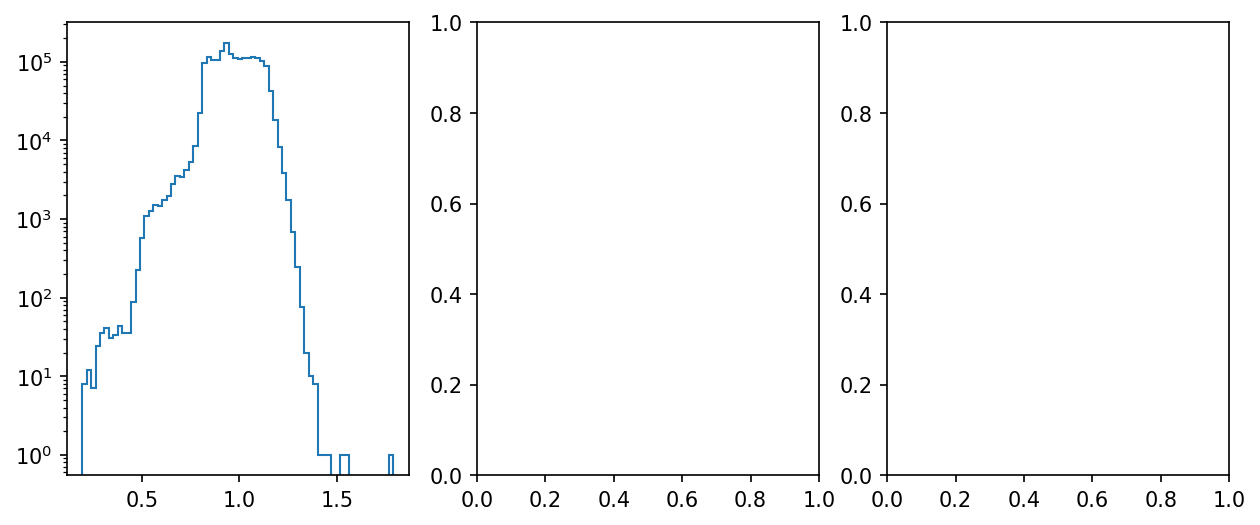

In [105]:
fig,ax = plt.subplots(1,3,figsize=(10,4), dpi = 150)

ax[0].hist(df_fore['mass'][with_mass].to_numpy()/df_fore['lum'][with_mass].to_numpy()**(1/4), bins=70, log=True, density=False, histtype='step');

In [817]:
### Histogram for the figure of merit sqrt(N)/(beta*sigma_mu)
n_bins = 100

hist_count, bin_x, bin_y = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins)
hist_sigmamusq_inv = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=1/(df_back['pmra_eff_error_new'].to_numpy()**2+df_back['pmdec_eff_error_new'].to_numpy()**2))[0]
hist_sigmamusq_inv = hist_sigmamusq_inv/hist_count
hist_beta = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=np.sqrt(l_bilnormsq)/arcsec)[0]
hist_beta = hist_beta/hist_count

<ipython-input-817-d2fd1ffc9e22>:6: RuntimeWarning: invalid value encountered in true_divide
  hist_sigmamusq_inv = hist_sigmamusq_inv/hist_count
<ipython-input-817-d2fd1ffc9e22>:8: RuntimeWarning: invalid value encountered in true_divide
  hist_beta = hist_beta/hist_count


In [818]:
hist_Dl = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=df_fore['dist_50'])[0]
hist_Dl = hist_Dl/hist_count

<ipython-input-818-a5fb80f374e5>:2: RuntimeWarning: invalid value encountered in true_divide
  hist_Dl = hist_Dl/hist_count


In [819]:
#l_muvec_1 = np.array([df_fore['pmra'].to_numpy()-df_back['pmra'].to_numpy(), df_fore['pmdec'].to_numpy()-df_back['pmdec'].to_numpy()]).T*mas/Year
l_muvec_1 = np.array([df_fore['pmra'].to_numpy(), df_fore['pmdec'].to_numpy()]).T
l_munorm_1 = np.sqrt(l_muvec_1[:, 0]**2 + l_muvec_1[:, 1]**2)
(l_munorm_1**2).shape

(1809437,)

In [763]:
np.min(tau_norm_sq_list), np.max(tau_norm_sq_list)

(3.750969117938685e-17, 0.002361946711998665)

In [872]:
len(tau_norm_sq_list[:36000*50])/36000

50.0

In [890]:
tau_norm_sq_sub =  np.array(np.split(tau_norm_sq_list[:36000*50], 50))

np.sum(tau_norm_sq_sub.T, axis=1)

array([7.24773662e-08, 6.81961941e-08, 7.53041668e-08, ...,
       8.28526921e-08, 1.45241113e-07, 2.09667869e-07])

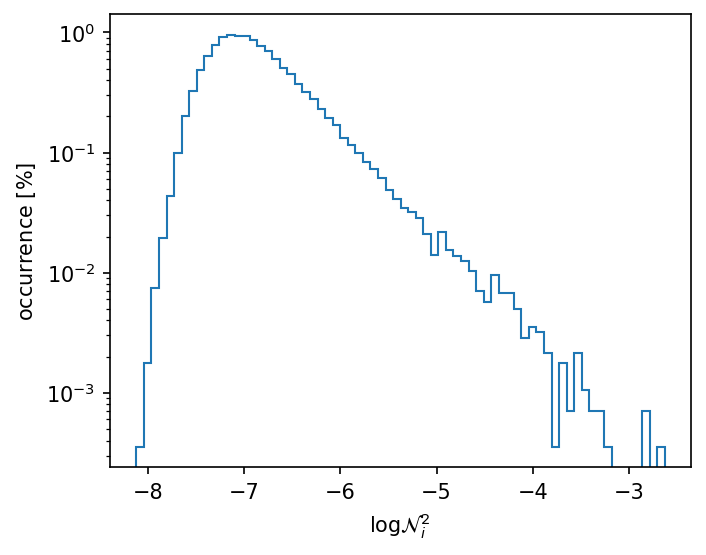

In [891]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.hist(np.log10(np.sum(tau_norm_sq_sub.T, axis=1)), bins=70, log=True, density=True, histtype='step');
ax.set_xlabel(r'$\log \mathcal{N}_i^2$ '); ax.set_ylabel(r'occurrence [$\%$]');

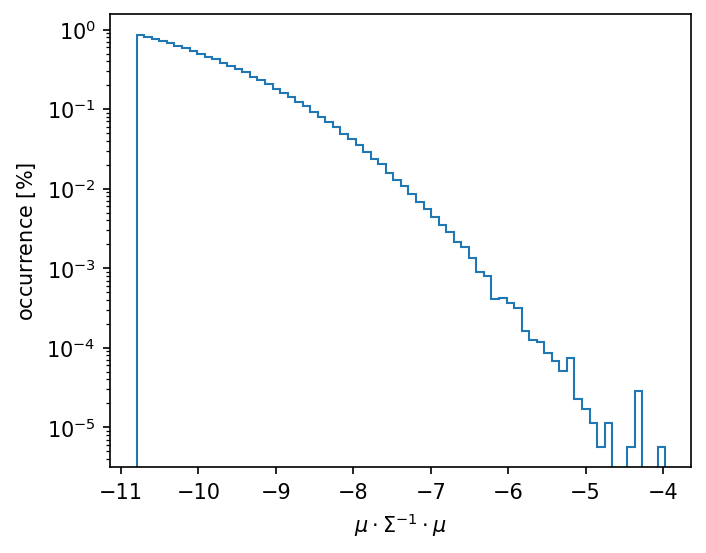

In [785]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.hist(np.log10(1/df_fore['dist_50'].to_numpy()**4), bins=70, log=True, density=True, histtype='step');
ax.set_xlabel(r'$\mu \cdot \Sigma^{-1} \cdot \mu$ '); ax.set_ylabel(r'occurrence [$\%$]');

In [840]:
#hist_mufg = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=np.sqrt( ( (df_fore['pmra'].to_numpy()-df_back['pmra'].to_numpy())**2/df_back['pmra_eff_error_new'].to_numpy()**2 + 
#                                                                                                           (df_fore['pmdec'].to_numpy()-df_back['pmdec'].to_numpy())**2/df_back['pmdec_eff_error_new'].to_numpy()**2) ))[0]
#hist_mufg = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=1/(df_back['pmra_eff_error_new'].to_numpy()**2 + df_back['pmdec_eff_error_new'].to_numpy()**2)/df_fore['dist_50'].to_numpy()**2/l_bilnormsq**2  )[0]
hist_mufg = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=1/l_bilnormsq**2  )[0]
#hist_mufg = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=l_munorm_1**2/df_fore['dist_50'].to_numpy()**2  )[0]
hist_mufg = hist_mufg

In [821]:
hist_mufg.flatten()/np.max(hist_mufg[~np.isnan(hist_mufg)])/(hist_nsq.flatten()/np.max(hist_nsq[~np.isnan(hist_nsq)]))

ValueError: operands could not be broadcast together with shapes (10000,) (2500,) 

In [822]:
hist_tau = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, range=None, density=None, weights=tau_mu_list)[0]
hist_nsq = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, range=None, density=None, weights=tau_norm_sq_list)[0]

In [855]:
hist_ntimesb = np.sqrt(hist_nsq)*hist_beta
fig_of_merit = np.sqrt(hist_count)*hist_sigmamusq_inv/(hist_beta) #*hist_mufg/hist_Dl

In [824]:
xv, yv = np.meshgrid(bin_x[:-1]+(bin_x[1]-bin_x[0])/2, bin_y[:-1]+(bin_y[1]-bin_y[0])/2)
xv.flatten(), yv.flatten();

In [896]:
np.min(np.sqrt(hist_nsq)[np.sqrt(hist_nsq)>0]), np.max(np.sqrt(hist_nsq))

(2.448698831846031e-06, 0.048605431314675214)

In [900]:
np.min(hist_ntimesb[~np.isnan(hist_ntimesb)]), np.max(hist_ntimesb[~np.isnan(hist_ntimesb)])

(7.340879111506175e-06, 0.09486731764908302)

<ipython-input-923-4c6a9e6821c7>:22: RuntimeWarning: divide by zero encountered in log10
  h = ax[2].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_count.flatten()) , cmap='RdBu');# weights=);


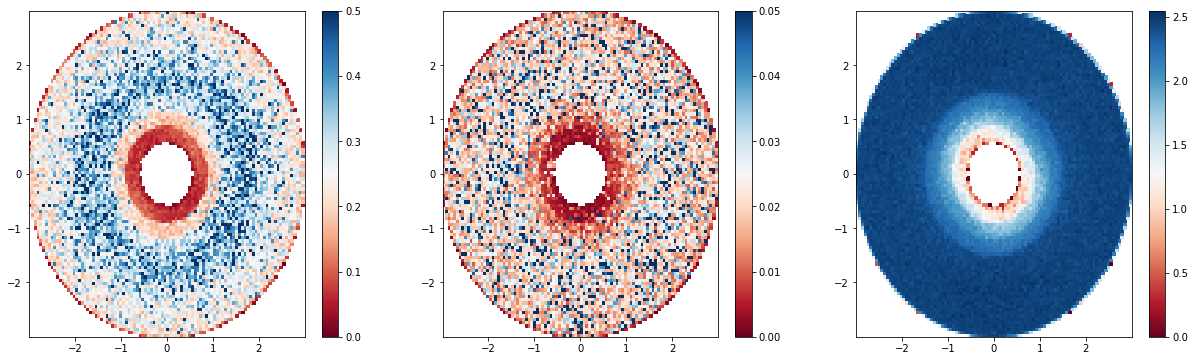

In [923]:
from matplotlib.ticker import FixedLocator, MultipleLocator


fig, ax = plt.subplots(1,3, figsize=(21,6))



h = ax[0].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=fig_of_merit.flatten()/np.max(fig_of_merit[~np.isnan(fig_of_merit)]) , cmap='RdBu', vmin=0, vmax=0.5);# weights=);
plt.colorbar(h[3], ax=ax[0]);

#h = ax[1].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_count.flatten()) , cmap='RdBu', vmin=-1, vmax=3.5);# weights=);
#h = ax[1].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=hist_ntimesb.flatten()/np.max(hist_ntimesb[~np.isnan(hist_ntimesb)]) , cmap='RdBu');
#h = ax[1].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_nsq.flatten()/np.max(hist_nsq[~np.isnan(hist_nsq)])) , cmap='RdBu');
#h = ax[1].hist2d(xv.flatten()[hist_nsq.flatten()>1e-18], yv.flatten()[hist_nsq.flatten()>1e-18], bins=(bin_x, bin_y),  weights=np.log10(hist_nsq.flatten()[hist_nsq.flatten()>1e-18]) , cmap='RdBu', vmin=-7, vmax=-3);
#h = ax[1].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_ntimesb.flatten()) , cmap='RdBu', vmin=-5, vmax=-1);
h = ax[1].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=hist_ntimesb.flatten()/np.max(hist_ntimesb[~np.isnan(hist_ntimesb)]) , cmap='RdBu', vmin=0, vmax=0.05);
plt.colorbar(h[3], ax=ax[1]);

#h = ax[2].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=(hist_tau/np.sqrt(hist_nsq)).flatten() , cmap='RdBu', vmin=-3, vmax=3);# weights=);
#plt.colorbar(h[3], ax=ax[2]);
#h = ax[2].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_mufg.flatten()/np.max(hist_mufg[~np.isnan(hist_mufg)])) , cmap='RdBu');# weights=);
h = ax[2].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_count.flatten()) , cmap='RdBu');# weights=);
plt.colorbar(h[3], ax=ax[2]);


#ax.axhline(y=0, xmin=0, xmax=1, c='k', linewidth=0.5)
#ax.axvline(x=0, ymin=0, ymax=1, c='k', linewidth=0.5)
#ax.set_xlim(-3.1, 3.1)
#ax.set_ylim(-3.1, 3.1)
#ax.set_ylabel(r'$\vec{\beta}_{i\ell}  \cdot  \hat{\mu}_{\ell}^{\perp} $ [arcsec]')
#ax.set_xlabel(r'$\vec{\beta}_{i\ell} \cdot  \hat{\mu}_{\ell} $ [arcsec]')

#ax.xaxis.set_minor_locator(MultipleLocator(0.3))
#ax.grid(which='major', color='white', linewidth=0.6)
#ax.minorticks_on()


In [264]:
np.min(hist_count), np.max()

(0.0, 5037.0)

In [152]:
hist_ToverN = hist_tau/np.sqrt(hist_nsq)

<ipython-input-152-2f58de6f7020>:1: RuntimeWarning: invalid value encountered in true_divide
  hist_ToverN = hist_tau/np.sqrt(hist_nsq)


In [153]:
np.max(hist_ToverN[~np.isnan(hist_ToverN)]), np.min(hist_ToverN[~np.isnan(hist_ToverN)])

(7.169374359687532, -3.067295245436006)

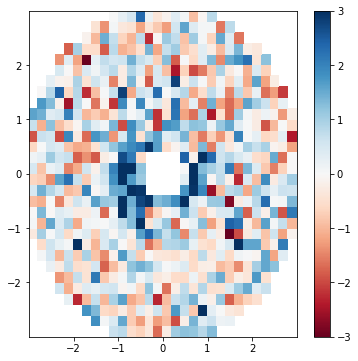

In [154]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

h = ax.hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=hist_ToverN.flatten() , cmap='RdBu', vmin=-3, vmax=3);# weights=);

plt.colorbar(h[3])

<ipython-input-160-b1d8bbe3a663>:3: RuntimeWarning: divide by zero encountered in log10
  h = ax.hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_count.flatten()) , cmap='RdBu');# weights=);


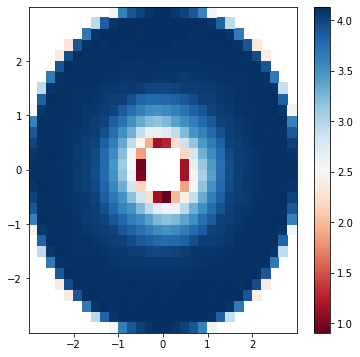

In [160]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

h = ax.hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_count.flatten()) , cmap='RdBu');# weights=);

plt.colorbar(h[3])

# Parallax template

## Functions

In [32]:
def fn_lensing_prallax(fg_ra_ecl, fg_dec_ecl, fg_parallax, fg_dist, bg_ra_ecl, bg_dec_ecl, bg_dist, matched_filter=fn_parallax_mf):
    """
    Computes the lens-induced parallax on background stars due to the foreground stars. In the template regime, the impact parameter must be larger than the foreground star's parallax.
    Output: list of parallaxes (in mas) and indices of pairs with impact parameter in the template regime (the other pairs should be discarded).
    """
    l_bilvec = fn_angular_sep(fg_ra_ecl*degree, fg_dec_ecl*degree, bg_ra_ecl*degree, bg_dec_ecl*degree)    
    l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
    l_bilhat = np.array([l_bilvec[:, 0]/np.sqrt(l_bilnormsq), l_bilvec[:, 1]/np.sqrt(l_bilnormsq)]).T 
    l_Dl = fg_dist * pc
    s_delta_sq = np.sin(fg_dec_ecl*degree)**2
        
    #parallax_list = -(1-fg_dist / bg_dist)*4*GN*MSolar/l_Dl*fg_parallax/l_bilnormsq*matched_filter(l_bilhat, s_delta_sq)
    parallax_list = -4*GN*MSolar/l_Dl*fg_parallax/l_bilnormsq*matched_filter(l_bilhat, s_delta_sq)
      
    return parallax_list[np.sqrt(l_bilnormsq)/mas > fg_parallax], np.arange(len(fg_ra_ecl))[np.sqrt(l_bilnormsq)/mas > fg_parallax]

In [33]:
def fn_varpi(df_fore, df_back, weights, tau_max=False, matched_filter=fn_parallax_mf, quiet=True):
    """
    For a given data frame of foreground and background stars, returns the parallax test statistic tau and its normalization.
    Weights must be an array of the same lenght of df_fore and df_back, e.g. the parallax inverse variance of each background star.
    If tau_max!=False, only the values of tau < tau_max are kept in the sum over all pairs. 
    """
    lensing_varpi, good_bil_ind = fn_lensing_prallax(df_fore['ecl_lon'].to_numpy(), df_fore['ecl_lat'].to_numpy(), df_fore['parallax'].to_numpy(), df_fore['dist_50'].to_numpy(),
                                                     df_back['ecl_lon'].to_numpy(), df_back['ecl_lat'].to_numpy(), df_back['dist_50'].to_numpy(), matched_filter)

    if(len(lensing_varpi) < len(df_back)):
        if not quiet: print((len(df_back)-len(lensing_varpi)), 'star pairs have too small impact parameter. Selecting only the good pairs.')
        df_back = df_back.iloc[good_bil_ind]
    
    ### Observed parallaxes 
    varpi_observed = df_back['parallax_sub_new'].to_numpy() 
    
    tau_norm_sq = lensing_varpi**2*weights
    tau_varpi = lensing_varpi*varpi_observed*weights
       
    if tau_max!=0:
        small_tau_varpi = tau_varpi[np.abs(tau_varpi) < tau_max]
        return sum(small_tau_varpi), np.sqrt(sum(tau_norm_sq[np.abs(tau_varpi) < tau_max]))
    else:
        #return sum(tau_varpi), np.sqrt(sum(tau_norm_sq))    
        return tau_varpi, tau_norm_sq, good_bil_ind  

## Evaluation

In [34]:
df_back.columns

Index(['source_id', 'ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error',
       'pmra_pmdec_corr', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'l',
       'b', 'ruwe', 'pmra_sub', 'pmdec_sub', 'pmra_eff_error',
       'pmdec_eff_error', 'pmra_pmdec_eff_corr', 'dist_50', 'dist_14',
       'dist_86', 'dist_error', 'pmra_sub_new', 'pmdec_sub_new',
       'parallax_sub_new', 'pmra_eff_error_new', 'pmdec_eff_error_new',
       'pmra_pmdec_eff_corr_new', 'parallax_eff_error_new'],
      dtype='object')

In [35]:
ecl_lon, ecl_lat = fn_eq_to_ecl_array(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy())
df_fore['ecl_lon'] = ecl_lon
df_fore['ecl_lat'] = ecl_lat

In [36]:
ecl_lon, ecl_lat = fn_eq_to_ecl_array(df_back['ra'].to_numpy(), df_back['dec'].to_numpy())
df_back['ecl_lon'] = ecl_lon
df_back['ecl_lat'] = ecl_lat

In [37]:
tau_pi_list, tau_pi_norm_sq_list, good_bil_ind = fn_varpi(df_fore, df_back, 1/(df_back['parallax_eff_error_new'].to_numpy())**2, tau_max=False, matched_filter=fn_parallax_mf, quiet=False)

In [38]:
sum(tau_pi_list), np.sqrt(sum(tau_pi_norm_sq_list)), sum(tau_pi_list)/np.sqrt(sum(tau_pi_norm_sq_list))

(-8.936148671097207, 0.3539881583268614, -25.244202273133247)

In [39]:
from scipy.stats import norm
  
# Fit a normal distribution to the distribution of T/N
mu, std = norm.fit(tau_pi_list/np.sqrt(tau_pi_norm_sq_list)) 
mu, std

(-0.022689448287351307, 0.8782960624124514)

In [40]:
np.max(tau_pi_list), np.min(tau_pi_list)

(0.06743078839930927, -0.08705853831657424)

In [41]:
np.mean(df_back['parallax_sub_new'].to_numpy()/(df_back['parallax_eff_error_new'].to_numpy())**2 )

-0.547125134215972

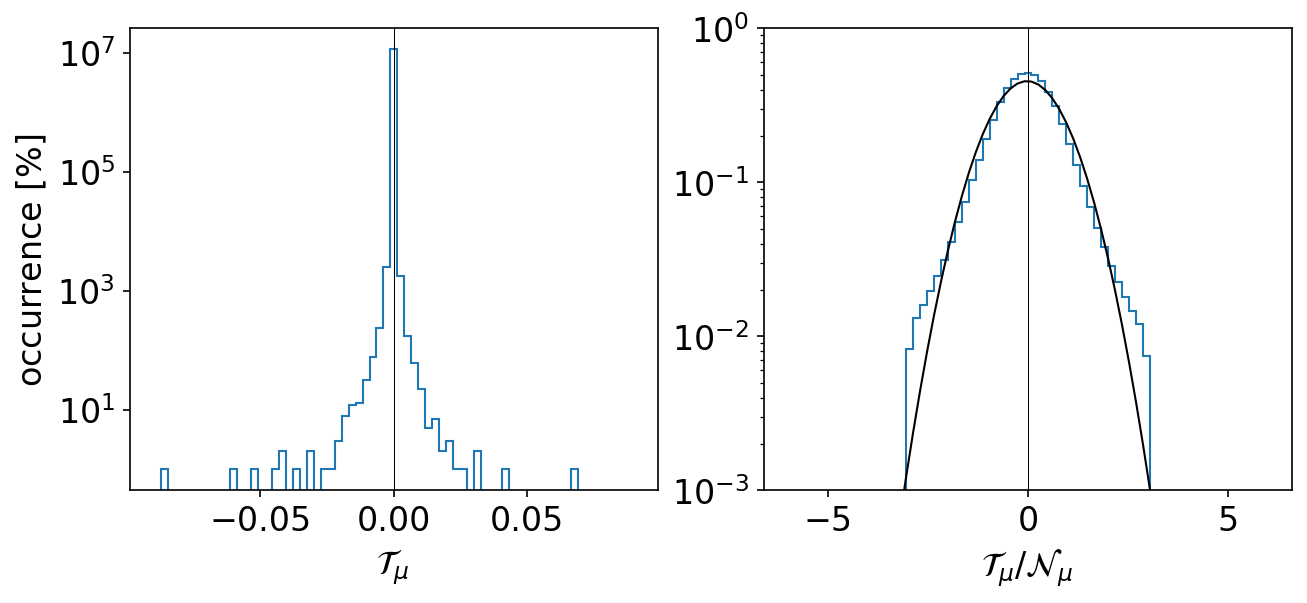

In [42]:
fig,ax = plt.subplots(1,2,figsize=(10,4), dpi = 150)

ax[0].hist(tau_pi_list, bins=np.linspace(-0.09, 0.09, 70), log=False, density=False, histtype='step');
ax[0].set_xlabel(r'$\mathcal{T}_{\mu}$ '); ax[0].set_ylabel(r'occurrence [$\%$]');
ax[0].axvline(0, color='k', linewidth=0.5)
ax[0].set_yscale('log')  

bins = np.linspace(-6, 6, 70)

h = ax[1].hist(tau_pi_list/np.sqrt(tau_pi_norm_sq_list), bins=bins, log=False, density=True, histtype='step');
ax[1].set_xlabel(r'$\mathcal{T}_{\mu}/\mathcal{N}_{\mu}$ ');
ax[1].axvline(0, color='k', linewidth=0.5)
ax[1].plot(bins,  norm.pdf(bins, mu, std), 'k', linewidth=1)
ax[1].set_yscale('log')  
ax[1].set_ylim(1e-3, 1);  


In [43]:
dist_bins = np.logspace(1, 4, num=30)
dist_bins

array([   10.        ,    12.68961003,    16.10262028,    20.43359718,
          25.92943797,    32.90344562,    41.75318937,    52.98316906,
          67.23357536,    85.31678524,   108.26367339,   137.38237959,
         174.33288222,   221.22162911,   280.72162039,   356.22478903,
         452.03536564,   573.61525104,   727.8953844 ,   923.67085719,
        1172.10229753,  1487.35210729,  1887.39182214,  2395.02661999,
        3039.19538231,  3856.62042116,  4893.90091848,  6210.16941892,
        7880.46281567, 10000.        ])

In [44]:
tau_d = np.zeros(len(dist_bins)-1)
n_d = np.zeros(len(dist_bins)-1)
n_pairs = np.zeros(len(dist_bins)-1)
d_avg = np.zeros(len(dist_bins)-1)

for i_d in range(len(dist_bins)-1):
    pairs_d = ((df_fore['dist_50'].to_numpy() > dist_bins[i_d]) & (df_fore['dist_50'].to_numpy() < dist_bins[i_d+1]))
    n_pairs[i_d] = len(df_fore[pairs_d])
    tau_d[i_d] = np.sum(tau_pi_list[pairs_d])
    n_d[i_d] = np.sqrt(np.sum(tau_pi_norm_sq_list[pairs_d]))
    d_avg[i_d] = np.mean((df_fore['dist_50'].to_numpy())[pairs_d])

In [45]:
np.sum(n_pairs), len(df_fore)

(11375853.0, 11375859)

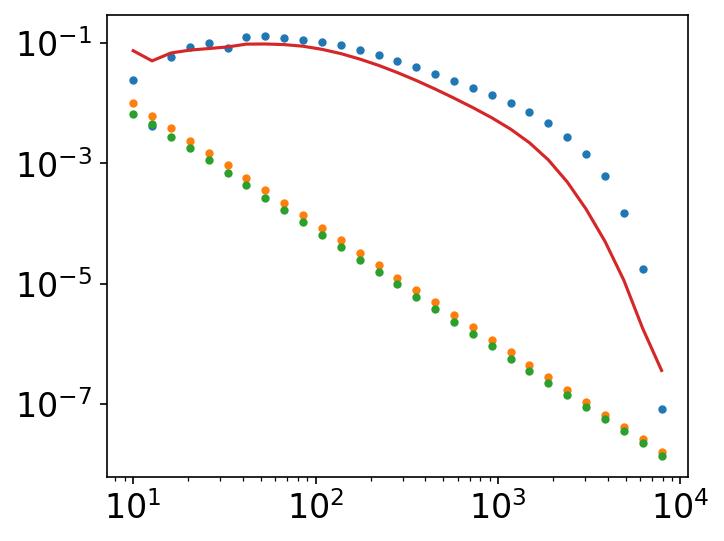

In [46]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.plot(dist_bins[:-1], n_d, '.');
ax.plot(dist_bins[:-1], 1/dist_bins[:-1]**2, '.');
ax.plot(dist_bins[:-1], 1/d_avg**2, '.');
#ax.plot(dist_bins[:-1], tau_d/n_d, '-');
ax.plot(dist_bins[:-1], 5*np.sqrt(n_pairs)/d_avg**2, '-');

ax.set_yscale('log')
ax.set_xscale('log')


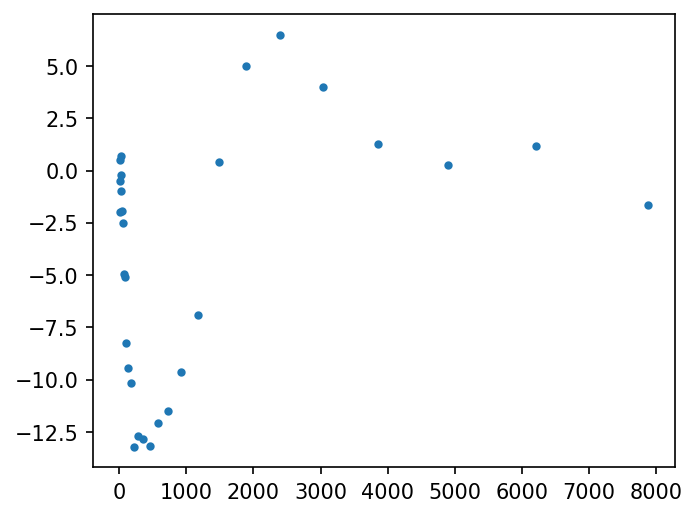

In [161]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.plot(dist_bins[:-1], tau_d/n_d, '.');

#ax.set_yscale('log')
#ax.set_xscale('log')


# Anisotropy Plots

In [12]:
#Modify template to return list of values
def fn_tau_mu2(df_fore, df_back, weights, tau_obs, tau_max=False, matched_filter = fn_dipole_mf, rot_angle=False, quiet=True):
    """
    For a given data frame of foreground and background stars, return the proper motion tau test statistic and its normalization.
    Weights must be an array of 2x2 matrices of the same lenght of df_fore and df_back, e.g. the pm inverse covariance matrix for each background star.
    If tau_max!=False, only the values of tau < tau_max are kept in the sum over all pairs. 
    """
    
    if not quiet: print('Computing the expected velocity.'); sys.stdout.flush()
    lensing_pm, good_bil_ind = fn_lensing_pm(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy(),
                                             df_fore['pmra'].to_numpy(),  df_fore['pmdec'].to_numpy(), df_fore['parallax'].to_numpy(),
                                             df_back['ra'].to_numpy(), df_back['dec'].to_numpy(),
                                             df_back['pmra'].to_numpy(), df_back['pmdec'].to_numpy(), df_back['parallax'].to_numpy(), tau_obs, matched_filter)

    if(len(lensing_pm) < len(df_back)):
        if not quiet: print((len(df_back)-len(lensing_pm)), 'star pairs have too small impact parameter. Selecting only the good pairs.'); sys.stdout.flush()
        df_back = df_back.iloc[good_bil_ind]; weights = weights[good_bil_ind]
    
    if rot_angle:
        if not quiet: print('Rotating the dipole profile by', rot_angle/degree, 'deg'); sys.stdout.flush()
        costh, sinth = np.cos(rot_angle), np.sin(rot_angle)
        lensing_pm = np.array([lensing_pm[:,0]*costh-lensing_pm[:,1]*sinth, lensing_pm[:,1]*costh+lensing_pm[:,0]*sinth]).T


    if not quiet: print('Computing the tau lists.'); sys.stdout.flush()
    ### Observed background stars' proper motion (after subtraction)
    observed_pm = np.array([df_back['pmra_sub_new'].to_numpy(), df_back['pmdec_sub_new'].to_numpy()]).T
    tau_norm_sq = weights[:, 0, 0]*lensing_pm[:, 0]**2 + weights[:, 1, 1]*lensing_pm[:, 1]**2 + 2*weights[:, 0, 1]*lensing_pm[:, 0]*lensing_pm[:, 1]
    tau_mu = (weights[:, 0, 0]*lensing_pm[:, 0]*observed_pm[:, 0] + weights[:, 1, 1]*lensing_pm[:, 1]*observed_pm[:, 1] + 
              weights[:, 0, 1]*(lensing_pm[:, 0]*observed_pm[:, 1] + lensing_pm[:, 1]*observed_pm[:, 0]))

    if not quiet: print('Computing the sum.'); sys.stdout.flush()
    if tau_max!=0:
        small_tau_mu = tau_mu[np.abs(tau_mu) < tau_max]
        if not quiet: print(str((1-len(small_tau_mu)/len(tau_mu))*100)+'% of taus removed')
        return small_tau_mu, np.sqrt(tau_norm_sq[np.abs(tau_mu) < tau_max])
    else:
        return tau_mu, np.sqrt(tau_norm_sq)

In [13]:
matched_filter=fn_dipole_mf
_, good_bil_ind = fn_lensing_pm(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy(),
                                             df_fore['pmra'].to_numpy(),  df_fore['pmdec'].to_numpy(), df_fore['parallax'].to_numpy(),
                                             df_back['ra'].to_numpy(), df_back['dec'].to_numpy(),
                                             df_back['pmra'].to_numpy(), df_back['pmdec'].to_numpy(), df_back['parallax'].to_numpy(), tau_obs, matched_filter)

In [14]:
#drop bad indices in the df
df_fore = df_fore.iloc[good_bil_ind]
df_back = df_back.iloc[good_bil_ind]

## Vector definitions

This section defines the key quantities for vizualisations, like the components of $\boldsymbol{\beta}_{i\ell}$ and $\boldsymbol{\mu}_{\mathrm{bg}}$ along the parallel/perpendicular directions of the foreground star's motion.

In [25]:
fg_ra = df_fore['ra'] 
fg_dec = df_fore['dec']
fg_pmra= df_fore['pmra'] 
fg_pmdec= df_fore['pmdec']


bg_ra = df_back['ra']
bg_dec = df_back['dec'] 
bg_pmra= df_back['pmra_sub_new'] 
bg_pmdec= df_back['pmdec_sub_new'] 

#bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2

l_bilhat = np.array([l_bilvec[:, 0]/np.sqrt(l_bilnormsq), l_bilvec[:, 1]/np.sqrt(l_bilnormsq)]).T 
l_bilhatperp = np.array([-l_bilhat[:, 1], l_bilhat[:, 0]]).T

#foreground mu vectors
l_muvec = np.array([fg_pmra, fg_pmdec]).T*mas/Year
#l_muvec = np.array([fg_pmra - bg_pmra, fg_pmdec - bg_pmdec]).T*mas/Year


l_munormsq = l_muvec[:, 0]**2 + l_muvec[:, 1]**2
l_muhat = np.array([l_muvec[:, 0]/np.sqrt(l_munormsq), l_muvec[:, 1]/np.sqrt(l_munormsq)]).T 
l_muhatperp = np.array([-l_muhat[:, 1], l_muhat[:, 0]]).T

#project bil onto fg mu
df_back['dotprod_bil'] = (l_bilhat[:,0]*l_muhat[:,0] + l_bilhat[:,1]*l_muhat[:,1])
df_back['dotperp_bil'] = (l_bilhat[:,0]*l_muhatperp[:,0] + l_bilhat[:,1]*l_muhatperp[:,1])
df_back['bilnorm'] = np.sqrt(l_bilnormsq)/arcsec

# bg's motion parallel to and perpendicular to fg's motion
df_back['mu_par'] = (bg_pmra*l_muhat[:,0] + bg_pmdec*l_muhat[:,1])
df_back['mu_perp'] = (bg_pmra*l_muhatperp[:,0] + bg_pmdec*l_muhatperp[:,1])

In [16]:
inv_cov_pm =  np.linalg.inv(fn_cov_pm_eff(df_back))
l_tau_mu, l_tau_mu_norm  = fn_tau_mu2(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=False)

df_back['tau_mu_n'] = l_tau_mu/l_tau_mu_norm

Computing the expected velocity.
Computing the tau lists.
Computing the sum.


## Check the variance, then compute signal after cutting out inner stars

In [20]:
direction = df_back['pmra_sub_new']

bil_bins = np.arange(0, 3., 0.3)
dist_list = np.sqrt(l_bilnormsq)/arcsec
b_list = np.digitize(dist_list, bil_bins)

var_ra = np.zeros(len(bil_bins))

for i_b in tqdm(range(len(bil_bins))):
    direction_i_b = direction[b_list == i_b]
    var_ra[i_b] = np.var(direction_i_b) 

100%|██████████| 10/10 [00:00<00:00, 22.98it/s]


In [21]:
direction = df_back['pmdec_sub_new']

var_dec = np.zeros(len(bil_bins))

for i_b in tqdm(range(len(bil_bins))):
    direction_i_b = direction[b_list == i_b]
    var_dec[i_b] = np.var(direction_i_b) 

100%|██████████| 10/10 [00:00<00:00, 23.02it/s]


In [22]:
direction = df_back['mu_par']

var_par = np.zeros(len(bil_bins))

for i_b in tqdm(range(len(bil_bins))):
    direction_i_b = direction[b_list == i_b]
    var_par[i_b] = np.var(direction_i_b) 

100%|██████████| 10/10 [00:00<00:00, 22.63it/s]


In [23]:
direction = df_back['mu_perp']

var_perp = np.zeros(len(bil_bins))

for i_b in tqdm(range(len(bil_bins))):
    direction_i_b = direction[b_list == i_b]
    var_perp[i_b] = np.var(direction_i_b) 

100%|██████████| 10/10 [00:00<00:00, 22.23it/s]


In [24]:
np.bincount(b_list)

array([      0,       0,     300,   51013,  231765,  576272, 1064142,
       1332117, 1615572, 1835765, 2056175])

In [25]:
eff_pmra = df_back['pmra_eff_error_new']
eff_pmdec = df_back['pmdec_eff_error_new']

var = np.zeros(len(bil_bins))

for i_b in tqdm(range(len(bil_bins))):
    eff_pmra_i_b = eff_pmra[b_list == i_b]
    eff_pmdec_i_b = eff_pmdec[b_list == i_b]
    var[i_b] = np.mean(eff_pmra_i_b**2 + eff_pmdec_i_b**2)

100%|██████████| 10/10 [00:00<00:00, 11.38it/s]


In [26]:
var_perp

array([       nan,        nan, 6.59376559, 5.57891859, 4.4201613 ,
       4.10071028, 4.07037296, 4.05982174, 4.04293538, 4.02318228])

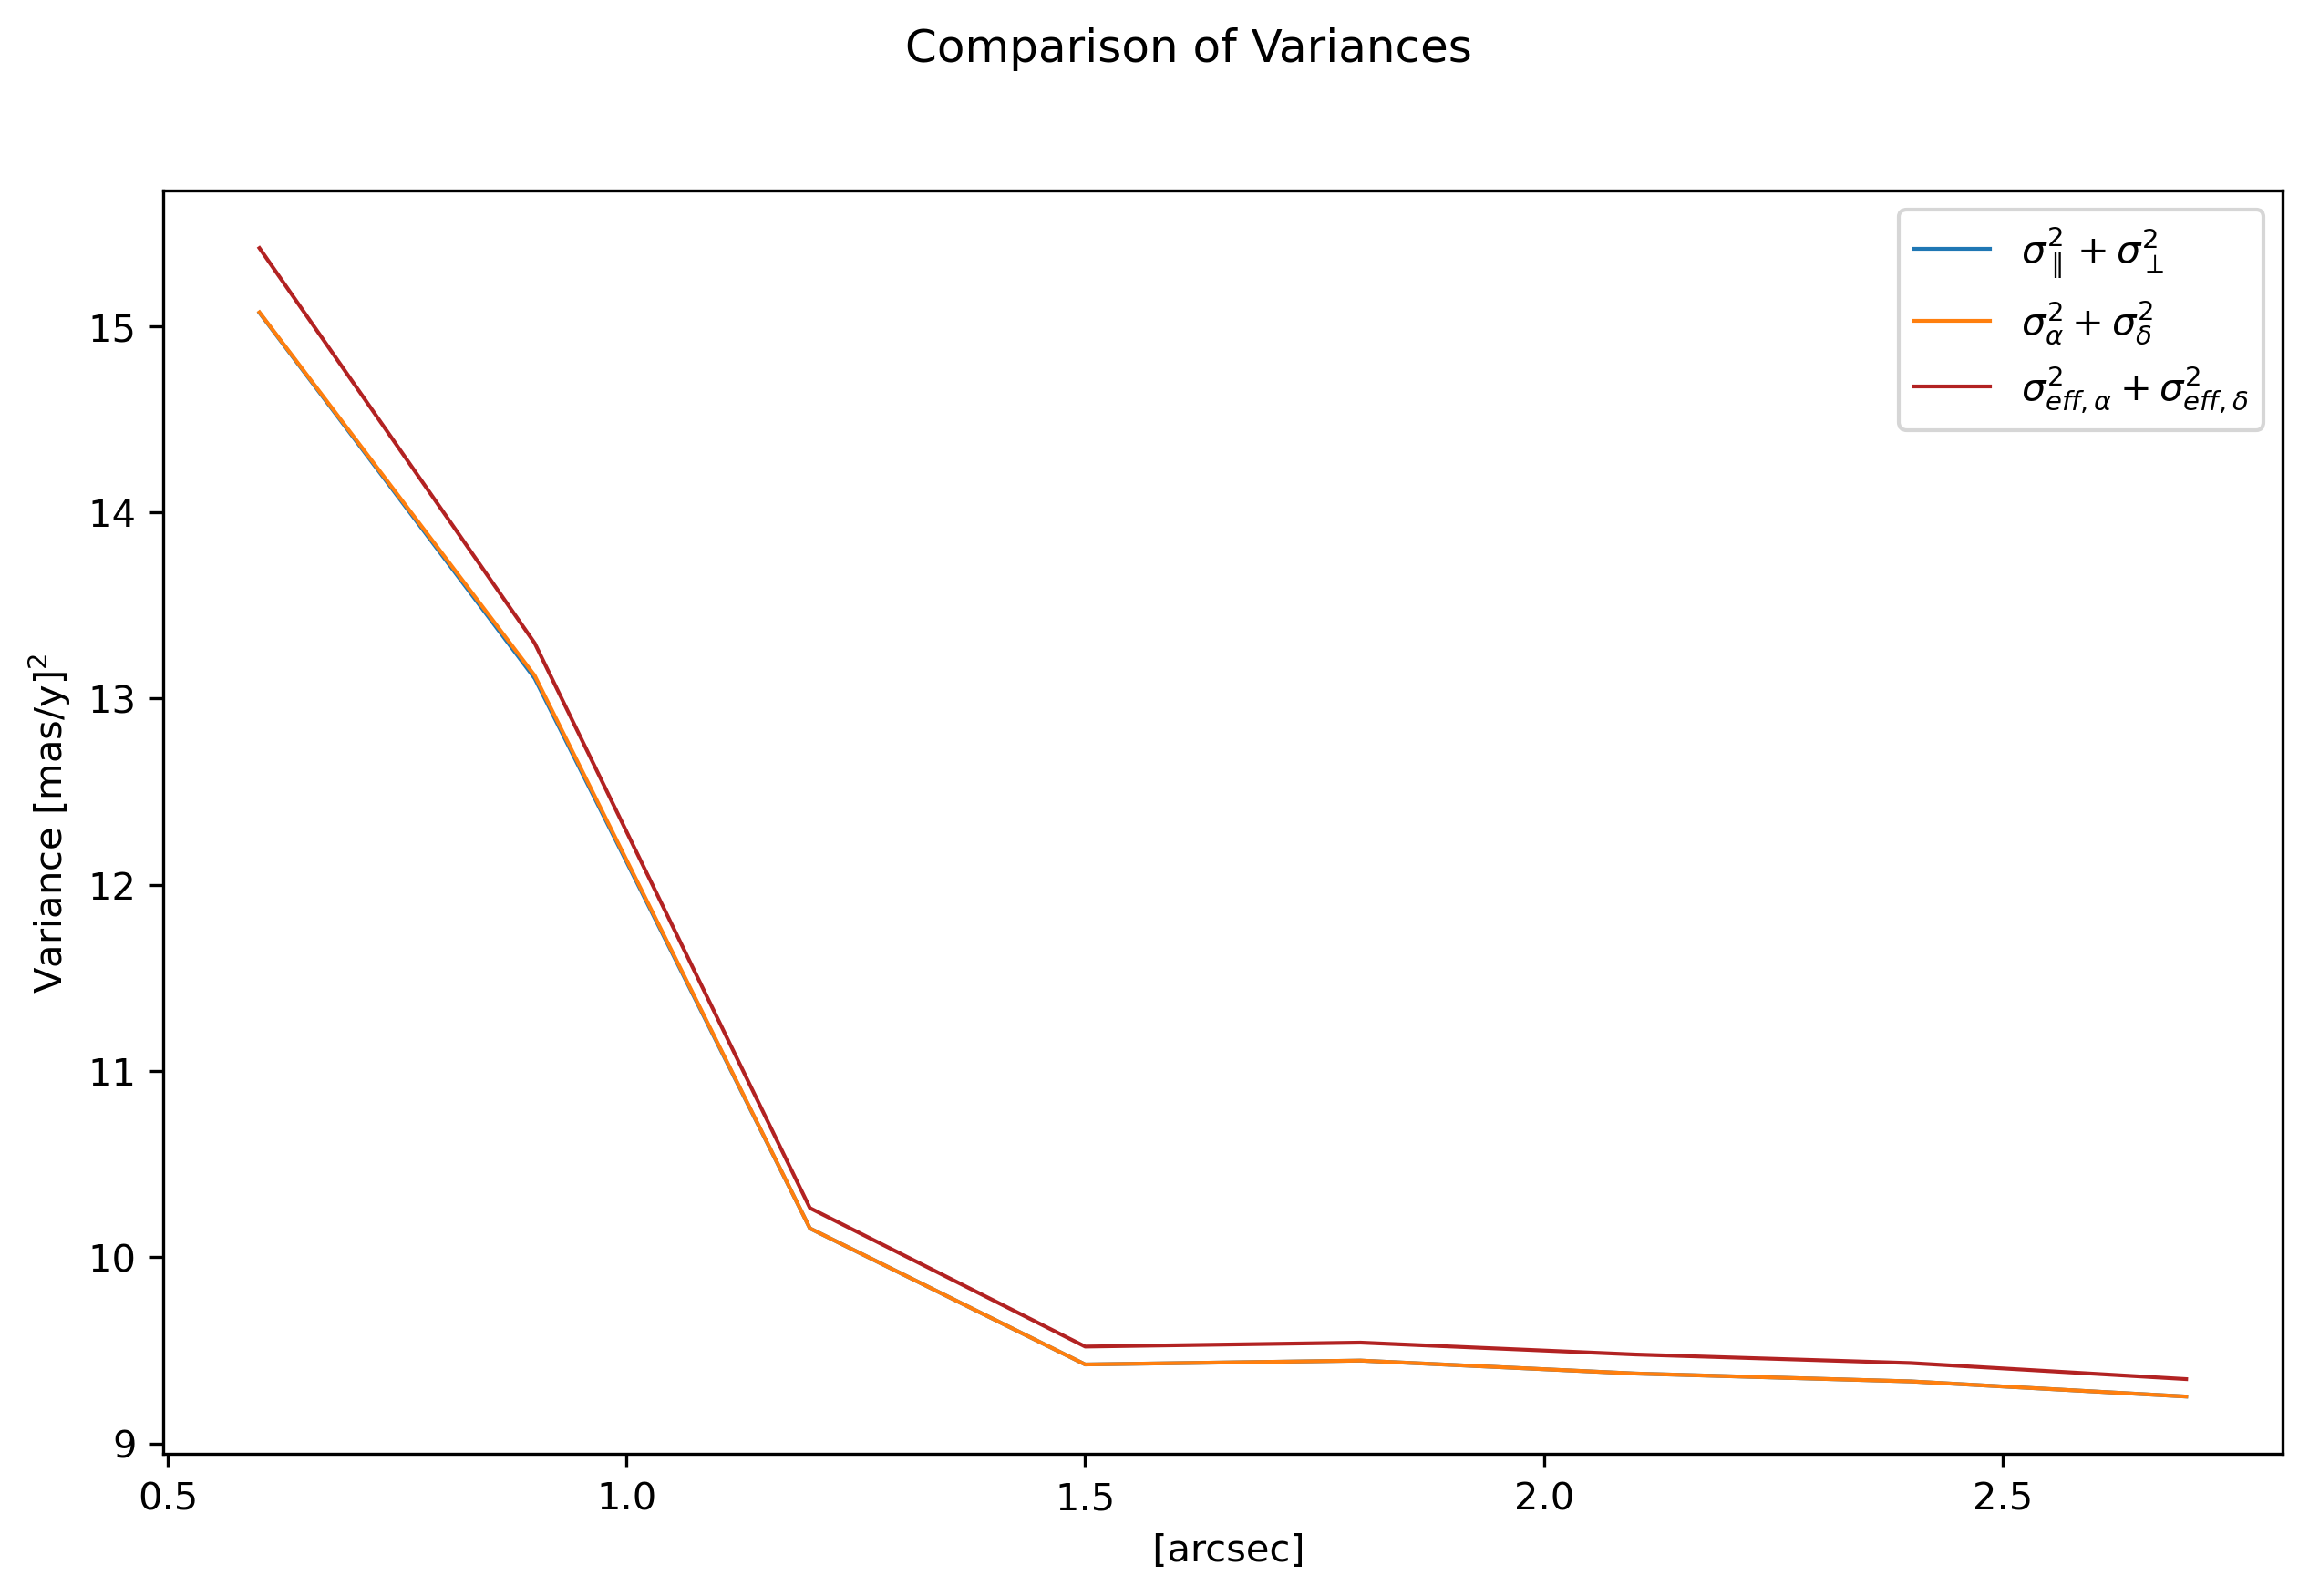

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,6),dpi=300)
ax.plot(bil_bins, var_par + var_perp, label = r'$\sigma_{\parallel}^2 + \sigma_{\perp}^2$', lw = 1)
ax.plot(bil_bins, var_ra + var_dec, label = r'$\sigma_{\alpha}^2 + \sigma_{\delta}^2$', lw = 1)
ax.plot(bil_bins, var, label = r'$\sigma_{eff, \alpha}^2 + \sigma_{eff,\delta}^2$', lw = 1, color = 'firebrick')
ax.set_ylabel(r'Variance [mas/y]$^2$')
ax.set_xlabel(r' [arcsec]')
fig.suptitle('Comparison of Variances')
ax.legend()

In [127]:
### cut out stars < min_radius
cutoff_tau = 3
min_radius = 0.0

condition1 = np.abs(l_tau_mu/l_tau_mu_norm) < cutoff_tau
condition2 = np.sqrt(l_bilnormsq)/arcsec > min_radius

df_backsmaller = df_back[condition1 & condition2]
df_foresmaller = df_fore[condition1 & condition2]
l_bilnormsq_smaller = l_bilnormsq[condition1 & condition2]
len(df_backsmaller), len(df_backsmaller)/len(df_back)

ValueError: operands could not be broadcast together with shapes (8763121,) (8711533,) 

In [64]:
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_backsmaller)) # np.linalg.inv(fn_cov_pm_new(df_foresmaller, df_backsmaller))
tau_mu, tau_norm_sq = fn_tau_mu(df_foresmaller, df_backsmaller, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=False)

Computing the expected velocity.
Computing the tau lists.
Computing the sum.


In [65]:
print('T   : ' + str(tau_mu))
print('N   : ' + str(tau_norm_sq))
print('T/N : ' + str(tau_mu/tau_norm_sq))

T   : 1.137520817701379
N   : 0.3720533199098408
T/N : 3.0574134319700006


In [66]:
#del df_back; del df_fore

## Anisotropy (unit $\mu$)

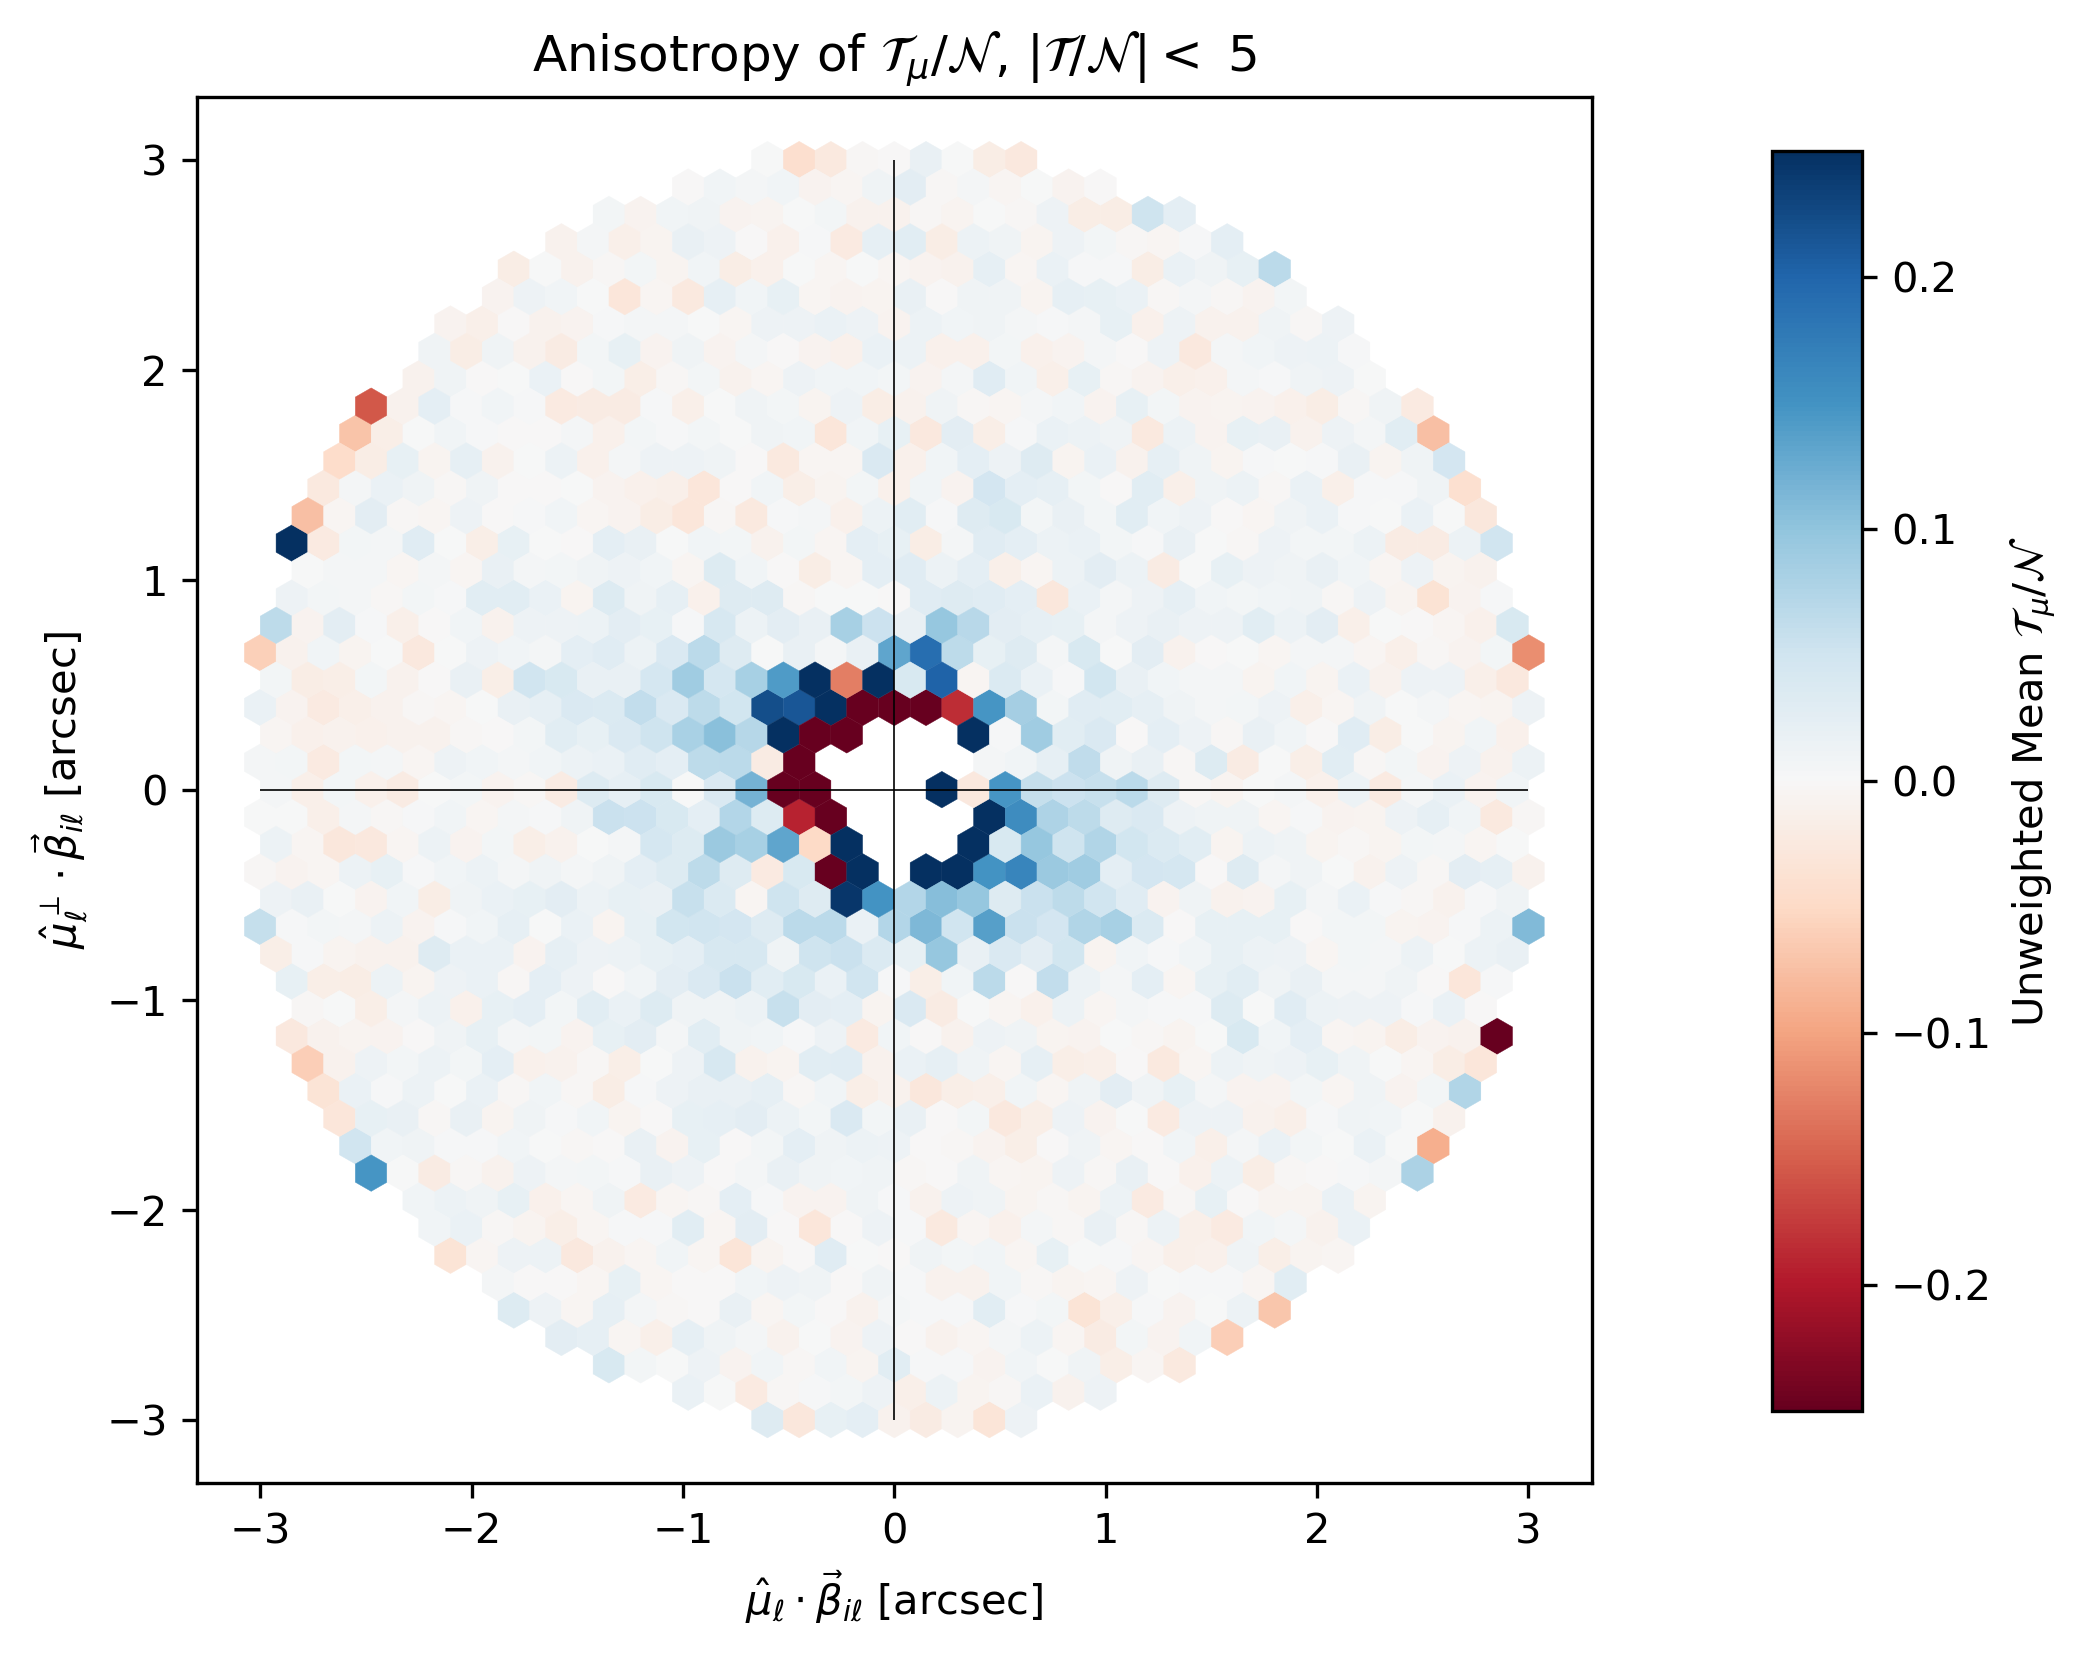

In [40]:
fig, ax = plt.subplots(1,1, figsize=(6,6),dpi=300)

im1 = ax.hexbin(x=df_backsmaller['dotprod_bil'],
                y=df_backsmaller['dotperp_bil'],
                C=df_backsmaller['tau_mu_n'], 
                reduce_C_function = np.mean, 
                vmin = - 0.05* cutoff_tau, 
                vmax = 0.05 * cutoff_tau, 
                gridsize = 40, 
                cmap = 'RdBu',
                linewidths=0.1)

ax.hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax.vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)

ax.set_ylabel(r'$\hat{\mu}_{\ell}^{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax.set_xlabel(r'$\hat{\mu}_{\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax.set_title(r'Anisotropy of $\mathcal{T}_\mu/\mathcal{N}$, $|\mathcal{T}/\mathcal{N}|<$ ' + str(cutoff_tau))


cbar_ax1 = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)

cbar1.set_label(r'Unweighted Mean $\mathcal{T}_\mu/\mathcal{N}$')

#fig.savefig('anisotropy_plot_tmu.pdf')

## Plots for the anisotropy

In [53]:
### Impact parameter and unit vector in the direction of the impact parameter
b_il = fn_angular_sep(df_back['ra'].to_numpy()*degree, df_back['dec'].to_numpy()*degree,
                      df_fore['ra'].to_numpy()*degree, df_fore['dec'].to_numpy()*degree)
b_il_norm = np.sqrt(b_il[:, 0]**2+b_il[:, 1]**2)
b_il_hat = np.array([b_il[:, 0]/b_il_norm, b_il[:, 1]/b_il_norm]).T 

In [54]:
mean_pml = np.array([np.mean(df_fore['pmra'].to_numpy()), np.mean(df_fore['pmdec'].to_numpy())])
mean_pml_hat = mean_pml/np.sqrt(mean_pml[0]**2 + mean_pml[1]**2)
mean_pml_hat

array([-0.61534266, -0.78825974])

In [55]:
mean_pml, np.array([np.std(df_fore['pmra'].to_numpy()), np.std(df_fore['pmdec'].to_numpy())]) 

(array([-3.23051064, -4.13831451]), array([7.78730462, 8.05028835]))

In [56]:
pml_p1s = mean_pml + np.array([np.std(df_fore['pmra'].to_numpy()), np.std(df_fore['pmdec'].to_numpy())])
pml_m1s = mean_pml - np.array([np.std(df_fore['pmra'].to_numpy()), np.std(df_fore['pmdec'].to_numpy())])

pml_p1s_hat = pml_p1s/np.sqrt(pml_p1s[0]**2 + pml_p1s[1]**2)
pml_m1s_hat = pml_m1s/np.sqrt(pml_m1s[0]**2 + pml_m1s[1]**2)

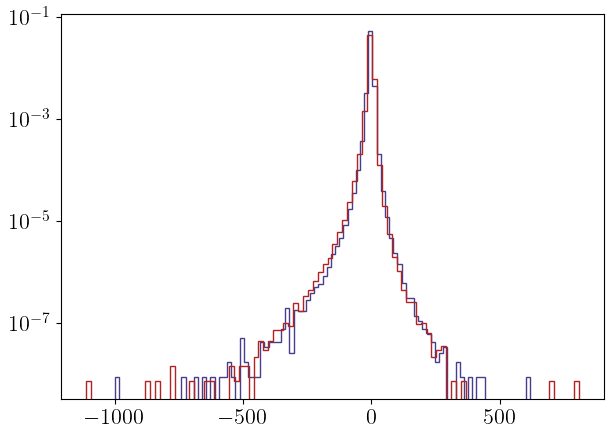

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
liestyle_list = ['-.', 'solid']

ax.hist(df_fore['pmra'].to_numpy(), 100, log=True, density=True, histtype='step', color=colorlist[0]);
ax.hist(df_fore['pmdec'].to_numpy(), 100, log=True, density=True, histtype='step', color=colorlist[1]);

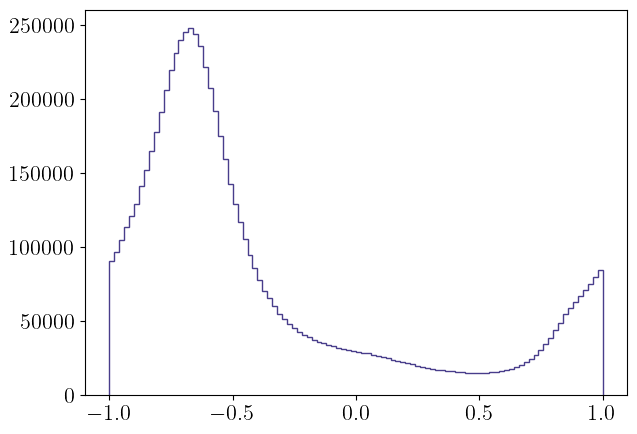

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
liestyle_list = ['-.', 'solid']

ax.hist(np.arctan2(vl_hat[:, 1], vl_hat[:, 0])/np.pi, 100, log=False, density=False, histtype='step', color=colorlist[0]);
#ax.hist(, 100, log=True, density=True, histtype='step', color=colorlist[1]);

In [59]:
vl_vec = np.array([df_fore['pmra'].to_numpy() , df_fore['pmdec'].to_numpy()]).T

vl_norm = np.sqrt(vl_vec[:, 0]**2 + vl_vec[:, 1]**2)
vl_hat = np.array([vl_vec[:, 0]/vl_norm, vl_vec[:, 1]/vl_norm]).T 
vl_perp_hat = np.array([-vl_hat[:, 1], vl_hat[:, 0]]).T

In [61]:
b_il_parall = b_il[:, 0]*vl_hat[:, 0] + b_il[:, 1]*vl_hat[:, 1]
b_il_perp = b_il[:, 0]*vl_perp_hat[:, 0] + b_il[:, 1]*vl_perp_hat[:, 1]

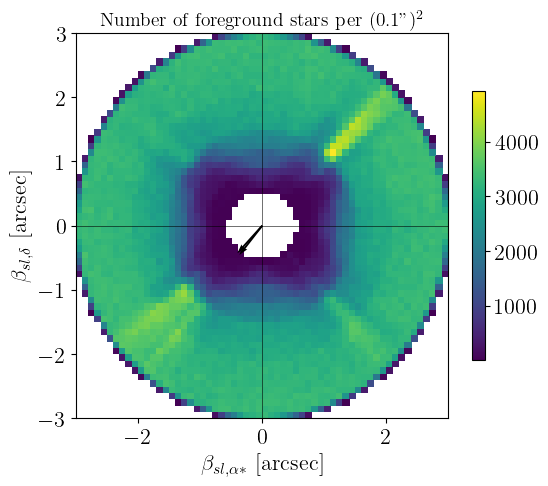

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
liestyle_list = ['-.', 'solid']

aa = ax.hist2d((b_il/arcsec)[:, 0], (b_il/arcsec)[:, 1], bins=[np.arange(-3,3.1,0.1), np.arange(-3,3.1,0.1)], range=None, density=False, weights=None, cmin=1, cmax=5000) #norm=colors.LogNorm(vmin=1E-6, vmax=0.07) )
fig.colorbar(aa[3], ax=ax, shrink=0.7)

ax.quiver(0, 0, mean_pml_hat[0], mean_pml_hat[1], color='k', scale=10, width=0.005)
#ax.quiver(0, 0, pml_p1s_hat[0], pml_p1s_hat[1], color='k', scale=10, width=0.005)
ax.quiver(0, 0, pml_m1s_hat[0], pml_m1s_hat[1], color='k', scale=10, width=0.005)

ax.set_xlabel(r'$\beta_{sl, \alpha*}$ [arcsec]'); ax.set_ylabel(r'$\beta_{sl, \delta}$ [arcsec]')
ax.set_title(r'Number of foreground stars per $(0.1")^2$', fontsize=14)

ax.hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax.vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)


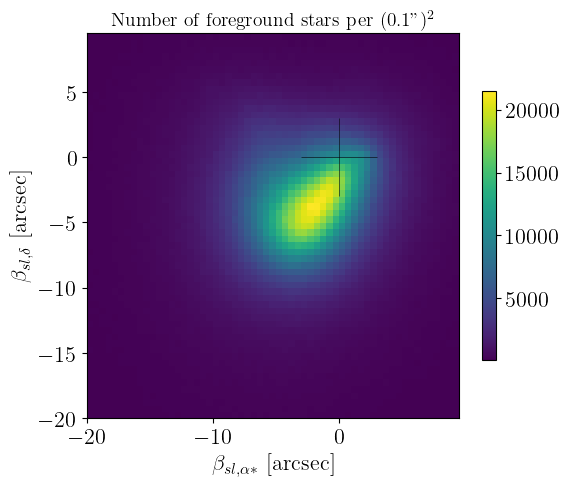

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
liestyle_list = ['-.', 'solid']

#aa = ax.hist2d(df_fore['pmra'].to_numpy(), df_fore['pmdec'].to_numpy(), bins=[np.arange(-20,10,0.5), np.arange(-20,10,0.5)], range=None, density=False, weights=None) #norm=colors.LogNorm(vmin=1E-6, vmax=0.07) )
aa = ax.hist2d(vl_vec[:, 0], vl_vec[:, 1], bins=[np.arange(-20,10,0.5), np.arange(-20,10,0.5)], range=None, density=False, weights=None) #norm=colors.LogNorm(vmin=1E-6, vmax=0.07) )
fig.colorbar(aa[3], ax=ax, shrink=0.7)


ax.set_xlabel(r'$\beta_{sl, \alpha*}$ [arcsec]'); ax.set_ylabel(r'$\beta_{sl, \delta}$ [arcsec]')
ax.set_title(r'Number of foreground stars per $(0.1")^2$', fontsize=14)

ax.hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax.vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)


In [67]:
bins

array([-3.00000000e+00, -2.90000000e+00, -2.80000000e+00, -2.70000000e+00, -2.60000000e+00, -2.50000000e+00, -2.40000000e+00, -2.30000000e+00, -2.20000000e+00, -2.10000000e+00, -2.00000000e+00,
       -1.90000000e+00, -1.80000000e+00, -1.70000000e+00, -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00, -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
       -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,  2.66453526e-15,  1.00000000e-01,  2.00000000e-01,
        3.00000000e-01,  4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,  1.00000000e+00,  1.10000000e+00,  1.20000000e+00,  1.30000000e+00,
        1.40000000e+00,  1.50000000e+00,  1.60000000e+00,  1.70000000e+00,  1.80000000e+00,  1.90000000e+00,  2.00000000e+00,  2.10000000e+00,  2.20000000e+00,  2.30000000e+00,  2.40000000e+00,
        2.50000000e+00,  2.600

In [70]:
np.full(len(b_il), 1/(bin_width*arcsec)**2)

array([4.25451703e+12, 4.25451703e+12, 4.25451703e+12, ..., 4.25451703e+12, 4.25451703e+12, 4.25451703e+12])

In [77]:
3000/(bin_width*arcsec)**2

1.2763551088845656e+16

In [82]:
4*GN*MSolar*0.001/(arcsec*np.mean(df_fore['dist_50'])**2*pc**2)*np.sqrt(1E16)/masy

0.26301939041825545

In [76]:
500000*np.pi*9

14137166.941154068

4927.0
3541.0
3505.0


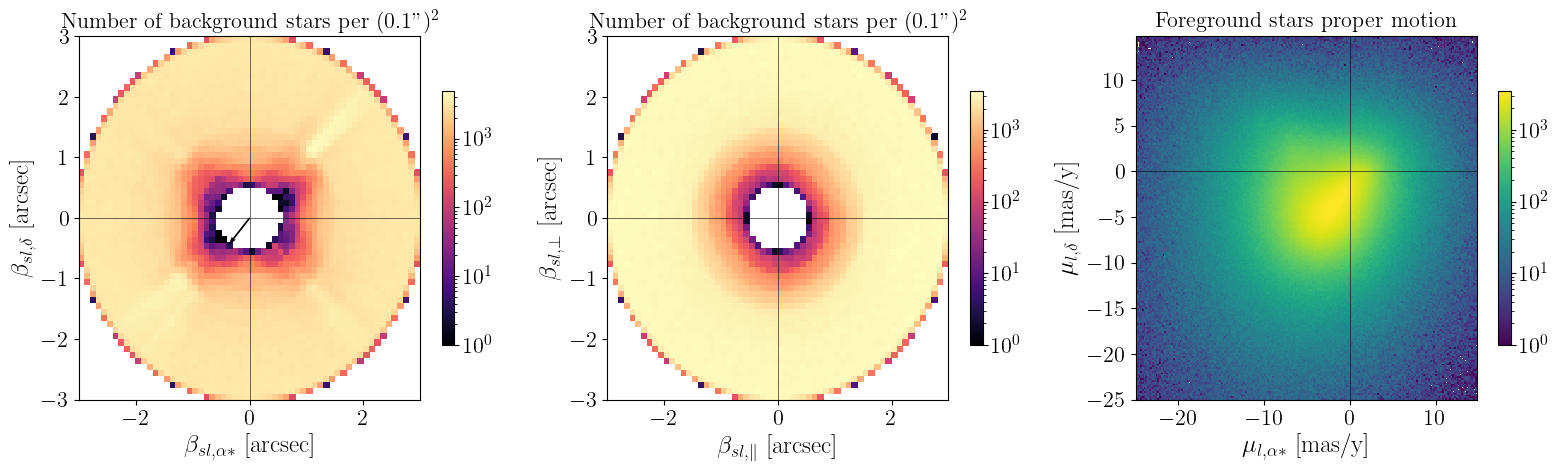

In [83]:

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
liestyle_list = ['-.', 'solid']

bin_width = 0.1
bins=np.arange(-3,3.1,bin_width)
aa = ax[0].hist2d((b_il/arcsec)[:, 0], (b_il/arcsec)[:, 1], bins=[bins, bins], range=None, density=False, weights=None,#weights=np.full(len(b_il), 1/(bin_width*arcsec)**2), 
                  norm=colors.LogNorm(vmin=1, vmax=4927.0), cmap='magma') #cmin=1, cmax=5000, cmap='magma')
fig.colorbar(aa[3], ax=ax[0], shrink=0.7)

print(np.max(aa[0][aa[0]>0]))

ax[0].quiver(0, 0, mean_pml_hat[0], mean_pml_hat[1], color='k', scale=10, width=0.005)

ax[0].set_xlabel(r'$\beta_{sl, \alpha*}$ [arcsec]', fontsize=18); ax[0].set_ylabel(r'$\beta_{sl, \delta}$ [arcsec]', fontsize=18)
ax[0].set_title(r'Number of background stars per $(0.1")^2$', fontsize=16)

ax[0].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[0].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)

aa = ax[1].hist2d((b_il_parall/arcsec), (b_il_perp/arcsec), bins=[np.arange(-3,3.1,0.1), np.arange(-3,3.1,0.1)], range=None, density=False, weights=None, norm=colors.LogNorm(vmin=1, vmax=3541.0), cmap='magma')#cmin=1, cmax=5000) 
fig.colorbar(aa[3], ax=ax[1], shrink=0.7)
print(np.max(aa[0][aa[0]>0]))

ax[1].set_xlabel(r'$\beta_{sl, \parallel}$ [arcsec]', fontsize=18); ax[1].set_ylabel(r'$\beta_{sl, \perp}$ [arcsec]', fontsize=18)
ax[1].set_title(r'Number of background stars per $(0.1")^2$', fontsize=16)

ax[1].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[1].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)


aa = ax[2].hist2d(vl_vec[:, 0], vl_vec[:, 1], bins=[np.arange(-25,15,0.2), np.arange(-25,15,0.2)], range=None, density=False, weights=None, norm=colors.LogNorm(vmin=1, vmax=3505.0)) #norm=colors.LogNorm(vmin=1E-6, vmax=0.07) )
fig.colorbar(aa[3], ax=ax[2], shrink=0.7)
ax[2].hlines(0, -30, 30, colors='k', linestyles='solid', linewidth=0.4) 
ax[2].vlines(0, -30, 30, colors='k', linestyles='solid', linewidth=0.4)
print(np.max(aa[0][aa[0]>0]))
ax[2].set_xlabel(r'$\mu_{l,\alpha*}$ [mas/y]', fontsize=18); ax[2].set_ylabel(r'$\mu_{l,\delta}$ [mas/y]', fontsize=18);
ax[2].set_title(r'Foreground stars proper motion', fontsize=16)

fig.tight_layout()
#fig.savefig(FigDir+'bg_star_anisotropy.png')

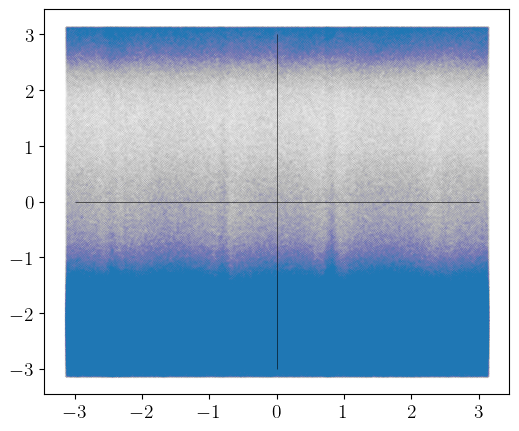

In [273]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
liestyle_list = ['-.', 'solid']

aa = ax.scatter(np.arctan2(b_il[:, 1]/arcsec, b_il[:, 0]/arcsec), np.arctan2(vl_vec[:, 1], vl_vec[:, 0]), s=0.00001) #norm=colors.LogNorm(vmin=1E-6, vmax=0.07) )
#fig.colorbar(aa[3], ax=ax, shrink=0.7)



ax.hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax.vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)


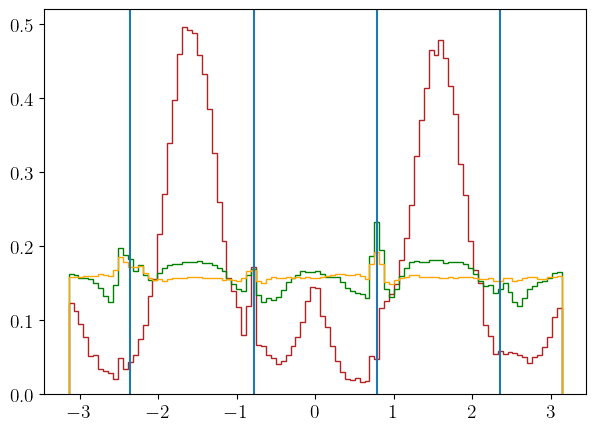

In [301]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
liestyle_list = ['-.', 'solid']

#ax.hist(np.arctan2(b_il_perp/arcsec, b_il_parall/arcsec)[b_il_norm/arcsec<1], 100, log=False, density=True, histtype='step', color=colorlist[0]);
ax.hist(np.arctan2(b_il[:, 1]/arcsec, b_il[:, 0]/arcsec)[b_il_norm/arcsec<=1], 100, log=False, density=True, histtype='step', color=colorlist[1]);
ax.hist(np.arctan2(b_il[:, 1]/arcsec, b_il[:, 0]/arcsec)[(b_il_norm/arcsec>1)& (b_il_norm/arcsec<=2)], 100, log=False, density=True, histtype='step', color=colorlist[2]);
ax.hist(np.arctan2(b_il[:, 1]/arcsec, b_il[:, 0]/arcsec)[(b_il_norm/arcsec>2)& (b_il_norm/arcsec<=3)], 100, log=False, density=True, histtype='step', color=colorlist[3]);
#ax.hist(np.arctan2(vl_vec[:, 1], vl_vec[:, 0]), 100, log=False, density=True, histtype='step', color=colorlist[2]);

ax.axvline(np.pi/4)
ax.axvline(3*np.pi/4)
ax.axvline(-np.pi/4)
ax.axvline(-3*np.pi/4)

#ax.hist(, 100, log=True, density=True, histtype='step', color=colorlist[1]);

In [14]:
### Angle between the impact parameter and the velocity unit vector
cos_theta = b_il_hat[:,0]*vl_hat[:,0] + b_il_hat[:,1]*vl_hat[:,1]
theta = np.arccos(cos_theta)

NameError: name 'cutoff_tau' is not defined

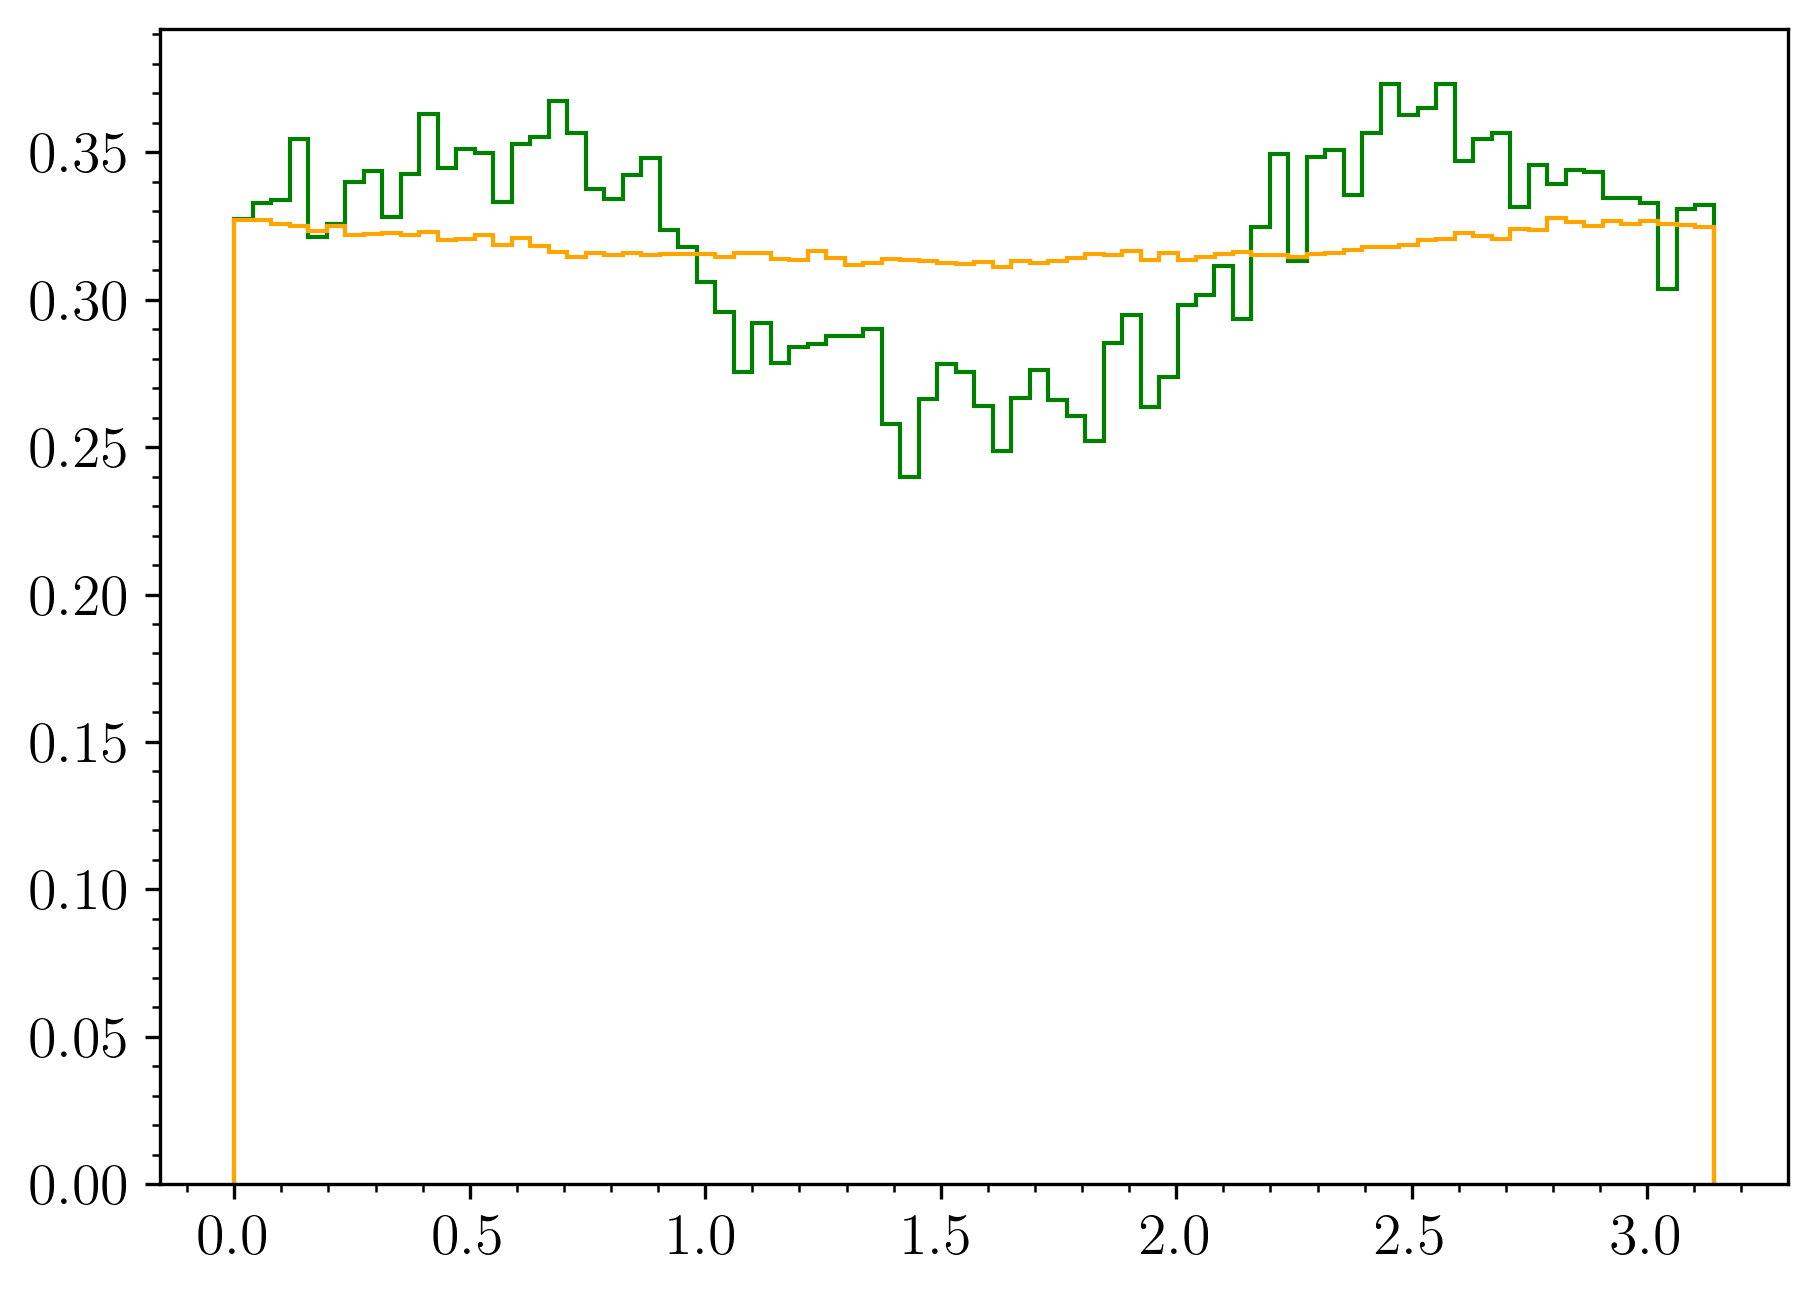

In [15]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5), dpi=300)
colorlist = ['green', 'orange']
beta_th = 1

ax.minorticks_on()

ax.hist(theta[b_il_norm/arcsec < beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[0]);
ax.hist(theta[b_il_norm/arcsec >= beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[1]);
#ax.hist(theta[b_il_norm/arcsec >= beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[2]);
ax.set_title(r'Anisotropy in the impact parameter ($|\mathcal{T}/\mathcal{N}| <$ ' + str(cutoff_tau) + ')', pad=10, fontsize=15.5)
ax.set_xlabel(r'$\theta = \cos^{-1} (\hat{\beta}_{ls} \cdot \hat{v}_{l})$ [rad]', fontsize=16); ax.set_ylabel(r'occurrence [$\%$]', fontsize=16);

p = [plt.plot([0, 3], [0, 0], color=colorlist[i])[0] for i in range(2)] 
ax.legend(p, [r'$\beta_{ls} < '+str(beta_th)+' $ arcsec', r'$\beta_{ls} > '+str(beta_th)+' $ arcsec'], loc='upper left', frameon=False, labelspacing=0.2, fontsize=14);
[p[i].set_visible(False) for i in range(len(p))]

ax.vlines(math.pi/2, 0, 0.45, color='grey', linewidth = 1, alpha=0.5)

fig.tight_layout()
#fig.savefig(FigDir+'Impact_param_anisotropy.pdf')

In [17]:
cos_theta, df_back['dotprod_bil'].to_numpy()

(array([-0.60788551, -0.99022198,  0.97117813, ...,  0.67292571,  0.99109766,  0.30451249]),
 array([-7.98690664e-06, -1.42253031e-05,  1.39568345e-05, ...,  8.55024850e-06,  1.34441472e-05,  4.42645532e-06]))

In [71]:
bin_step = (np.max(df_back['bilnorm'].to_numpy())-np.min(df_back['bilnorm'].to_numpy()))/6
bil_bins = np.arange(np.min(df_back['bilnorm'].to_numpy()), 1.01*np.max(df_back['bilnorm'].to_numpy()), bin_step)

In [70]:
bil_bins

array([0.60001531, 1.20001147, 1.80000763, 2.40000378, 2.99999994])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
liestyle_list = ['-.', 'solid']

for i in range(len(bil_bins)-1):
    ax.hist(np.arccos(df_back['dotprod_bil'])[(bil_bins[i] < df_back['bilnorm']) & (df_back['bilnorm'] < bil_bins[i+1])], 100, log=False, density=True, histtype='step', color=colorlist[i]);


In [73]:
np.sum(df_back['dotprod_bil'].to_numpy())/len(df_back)

-0.000978929668309863

In [59]:
counts = np.histogram(df_back['bilnorm'].to_numpy(), bins=bil_bins)[0]
avg_cos = np.histogram(df_back['bilnorm'].to_numpy(), bins=bil_bins, weights=df_back['dotprod_bil'].to_numpy())[0]
avg_cos = avg_cos/counts

avg_cos

array([ 1.92916154e-02, -6.48290502e-03, -5.69862054e-03, -5.86534564e-04,  1.97427119e-03,  5.61363558e-05, -1.42949682e-03, -2.76025492e-03, -1.81941896e-03,  1.31094891e-04])

In [27]:
front = df_back[df_back['dotprod_bil'] >= 0]['bilnorm']
back = df_back[df_back['dotprod_bil'] < 0]['bilnorm']

In [31]:
front

2          2.964239
3          2.810944
5          2.752335
7          2.782923
10         2.775516
             ...   
7339092    2.534626
7339093    2.862450
7339094    2.620817
7339095    2.797963
7339096    2.998307
Name: bilnorm, Length: 3665259, dtype: float64

In [32]:
back

0          2.710079
1          2.963153
4          2.991972
6          2.764950
8          2.720587
             ...   
7339079    2.640533
7339083    2.627899
7339084    2.405299
7339090    2.658354
7339091    2.505253
Name: bilnorm, Length: 3673838, dtype: float64

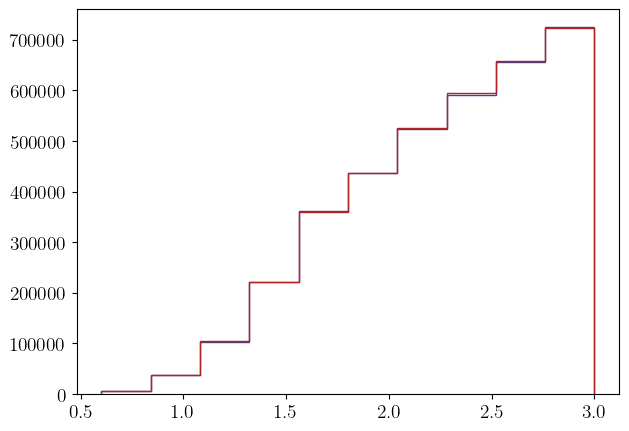

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

h1 = ax.hist(front, 10, log=False, density=False, histtype='step', color=colorlist[0]);
h2 = ax.hist(back, 10, log=False, density=False, histtype='step', color=colorlist[1]);


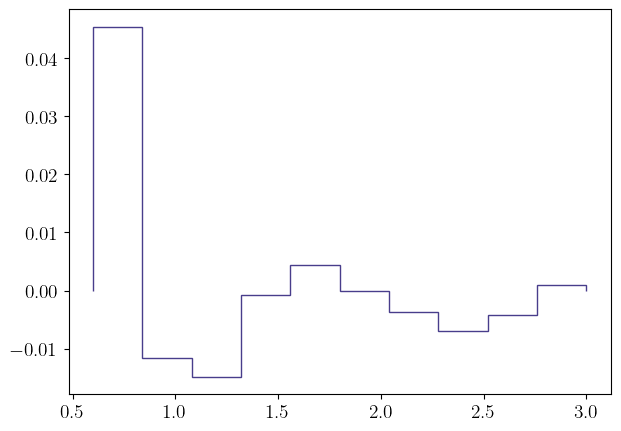

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

ax.hist(h1[1][:-1], h1[1], weights=(h1[0]-h2[0])/h2[0], log=False, density=False, histtype='step', color=colorlist[0]);

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

ax.contour(np.power(10, dr2_x_matrix/10), np.power(10, (dr2_y_matrix-30)/10), dr2_30_CL90.T, levels=[1], colors=colorlist[0], linewidths = 1.5, linestyles=liestyle_list[0])
ax.contour(np.power(10, dr2_x_matrix/10), np.power(10, (dr2_y_matrix-30)/10), dr2_30_CL50.T, levels=[1], colors=colorlist[1], linewidths = 1.5, linestyles=liestyle_list[0])
ax.contour(np.power(10, limit_matrix_30[0]/10), np.power(10, (limit_matrix_30[1]-30)/10), limit_matrix_30[3], levels=[1], colors=colorlist[0], linewidths = 1.5, linestyles=liestyle_list[1])
ax.contour(np.power(10, limit_matrix_30[0]/10), np.power(10, (limit_matrix_30[1]-30)/10), limit_matrix_30[2], levels=[1], colors=colorlist[1], linewidths = 1.5, linestyles=liestyle_list[1])

p = [plt.plot([0, 10], [0, 0], linestyle=liestyle_list[i], linewidth=1.5, color='k')[0] for i in range(2)]
ax.legend(p, [r'DR2 (1.8 y)', r'EDR3 (2.8 y)', ], loc='lower left', frameon=False, labelspacing=0.2, fontsize=12);
[p[i].set_visible(False) for i in range(len(p))]


ax.set_xscale('log'); ax.set_yscale('log');
# Set ticks on both sides of axes on
ax.minorticks_on()
ax.tick_params(axis='both', which='both', bottom=True, top=True, labelbottom=True, labeltop=False, left=True, right=True, labelleft=True, labelright=False)

ax.set_title(r'MCs limit on compact lenses with $r_l = 1\ \mathrm{pc}$', pad=10);
ax.set_xlabel(r'$M_{l} [M_{\odot}]$')
ax.set_ylabel(r'$f_l = \Omega_{l}/\Omega_\mathrm{DM}$')
ax.axis([1*math.pow(10, 7), math.pow(10, 9), 0.7, 16]);
ax.set_ylim(0.6, 10)
#ax.yaxis.tick_right()
fig.tight_layout()
#fig.savefig(FigDir+'Compact_lens_limit_DR2_EDR3.pdf')

# Effective error vs Gaia error

In [89]:
df_back

source_id          ra        dec      pmra     pmdec  \
0         407652079258216832   26.833258  51.855765 -4.064927 -1.565365   
1         407670053694081536   26.529999  52.070850 -2.963004 -0.583585   
2         407745301525056256   28.135469  52.558146 -1.199981 -1.201087   
3         407818041090608384   27.248774  52.956444 -0.443197 -0.612761   
4         407870164811431552   26.579393  52.453189 -0.758300 -0.242869   
...                      ...         ...        ...       ...       ...   
7339092  6764395645195995008  286.702925 -24.943808 -6.547409 -4.257561   
7339093  6764400459856491904  286.959903 -24.814410  0.726159 -6.218973   
7339094  6764403792752241536  286.750590 -24.768030  0.947705 -4.734969   
7339095  6764403792752241664  286.749851 -24.768231 -1.230452 -6.258204   
7339096  6764404205068135168  286.776797 -24.739748 -4.345762 -5.209335   

         pmra_error  pmdec_error  pmra_pmdec_corr  parallax  parallax_error  \
0          0.126139     0.116540         0.012693  0.406816        0.124430   
1          0.075206     0.069984         0.045255  0.351316        0.075596   
2          0.088220     0.075072        -0.079274  0.324604        0.076862   
3          0.097763     0.084193        -0.033119  0.162303        0.086288   
4          0.131261     0.101988        -0.218260  0.151688        0.119610   
...             ...          ...              ...       ...             ...   
7339092    0.435546     0.345680        -0.025354 -0.632005        0.367965   
7339093    0.333150     0.304717         0.349956  0.266297        0.286263   
7339094    0.214560     0.177042         0.157865 -0.067881        0.190301   
7339095    0.258761     0.218863         0.186150  0.121720        0.229431   
7339096    0.197926     0.170472         0.340317  0.198237        0.177872   

         phot_g_mean_mag      ruwe  pmra_sub  pmdec_sub  pmra_eff_error  \
0              17.900330  1.087207 -3.711732  -0.708549        2.706869   
1              17.187498  1.062474 -2.120910   0.444528        2.151276   
2              17.137915  1.135454 -0.520214  -0.214121        1.799891   
3              17.624405  0.954291  0.379118   0.065711        1.440643   
4              17.794685  1.018508 -0.020397   0.355694        1.430127   
...                  ...       ...       ...        ...             ...   
7339092        19.571630  1.029294 -4.914745   0.544818        2.592672   
7339093        19.428898  1.043580  2.388641  -1.466704        2.666758   
7339094        18.668892  0.951767  2.648562  -0.143649        2.695045   
7339095        18.832682  0.973366  0.376023  -1.916206        2.769977   
7339096        18.459255  1.013080 -2.772276  -0.983369        2.797137   

         pmdec_eff_error  pmra_pmdec_eff_corr    dist_50    dist_14  \
0               1.658676            -0.128547  2487.2134  1938.6178   
1               1.603770            -0.150118  2583.8684  2163.2551   
2               1.469232            -0.115182  2983.0005  2442.0657   
3               1.282450            -0.320283  4404.5340  3299.5427   
4               1.183836            -0.138365  4120.2520  3105.4836   
...                  ...                  ...        ...        ...   
7339092         2.717111             0.159154  6373.3040  4055.6035   
7339093         2.730891             0.173529  4866.0747  3067.2144   
7339094         2.816309             0.206011  6657.5728  4696.9014   
7339095         2.884018             0.175015  5900.0522  3815.6404   
7339096         2.897101             0.164569  6236.1930  3655.5676   

            dist_86  dist_error  pmra_sub_new  pmdec_sub_new  \
0         3334.8035   698.09285     -2.706098      -1.160469   
1         3112.2837   474.51430     -1.590190      -0.191498   
2         3889.4458   723.69005      0.119845      -0.760469   
3         5740.7360  1220.59665      0.805635      -0.107121   
4         5697.6235  1296.06995      0.501472       0.252752   
...             ...         ...

In [84]:
pm_corr = np.histogram(df_back['phot_g_mean_mag'].to_numpy(), bins=bins, weights=df_back['pmra_pmdec_corr'].to_numpy())[0]
pm_corr = np.sqrt(np.divide(pm_corr, gmag_counts, out=np.zeros(len(gmag_counts)), where=(gmag_counts>0) ))

pm_eff_corr = np.histogram(df_back['phot_g_mean_mag'].to_numpy(), bins=bins, weights=df_back['pmra_pmdec_eff_corr_new'].to_numpy())[0]
pm_eff_corr = np.sqrt(np.divide(pm_eff_corr, gmag_counts, out=np.zeros(len(gmag_counts)), where=(gmag_counts>0) ))

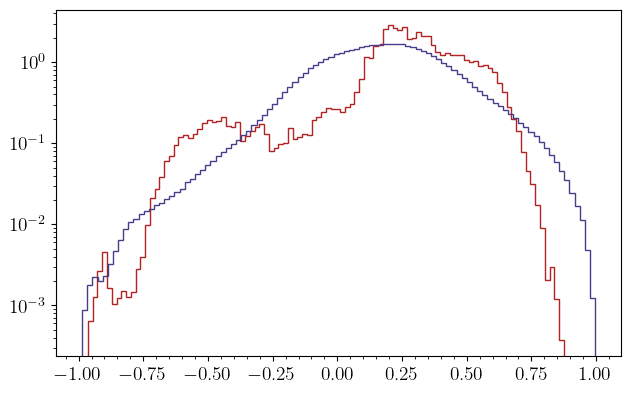

In [90]:
goldenratio = 1.61803
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5*goldenratio, 4.5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
fonts = 14
ax.minorticks_on()

ax.hist(df_back['pmra_pmdec_eff_corr_new'].to_numpy(), bins=100, log=True, density=True, histtype='step',color=colorlist[1]);
ax.hist(df_back['pmra_pmdec_corr'].to_numpy(), bins=100, log=True, density=True, histtype='step',color=colorlist[0]);


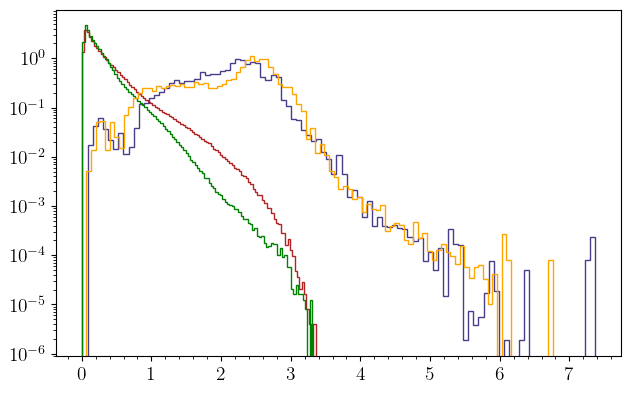

In [92]:
goldenratio = 1.61803
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5*goldenratio, 4.5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
fonts = 14
ax.minorticks_on()

ax.hist(df_back['pmra_error'].to_numpy(), bins=100, log=True, density=True, histtype='step',color=colorlist[1]);
ax.hist(df_back['pmra_eff_error_new'].to_numpy(), bins=100, log=True, density=True, histtype='step',color=colorlist[0]);
ax.hist(df_back['pmdec_error'].to_numpy(), bins=100, log=True, density=True, histtype='step',color=colorlist[2]);
ax.hist(df_back['pmdec_eff_error_new'].to_numpy(), bins=100, log=True, density=True, histtype='step',color=colorlist[3]);


In [129]:
bins = np.arange(13,22,0.1)
gmag_counts = np.histogram(df_back['phot_g_mean_mag'].to_numpy(), bins=bins)[0]

pm_error = np.histogram(df_back['phot_g_mean_mag'].to_numpy(), bins=bins, 
                          weights=np.sqrt(df_back['pmra_error'].to_numpy()**2 + df_back['pmdec_error'].to_numpy()**2 + 
                                          2*df_back['pmra_pmdec_corr'].to_numpy()*df_back['pmra_error'].to_numpy()*df_back['pmdec_error'].to_numpy()) )[0]
pm_error = np.divide(pm_error, gmag_counts, out=np.zeros(len(gmag_counts)), where=(gmag_counts>0) )

pm_eff_error = np.histogram(df_back['phot_g_mean_mag'].to_numpy(), bins=bins, 
                            weights=np.sqrt(df_back['pmra_eff_error_new'].to_numpy()**2 + df_back['pmdec_eff_error_new'].to_numpy()**2 +
                                            2*df_back['pmra_pmdec_eff_corr_new'].to_numpy()*df_back['pmra_eff_error_new'].to_numpy()*df_back['pmdec_eff_error_new'].to_numpy()) )[0]
pm_eff_error = np.divide(pm_eff_error, gmag_counts, out=np.zeros(len(gmag_counts)), where=(gmag_counts>0) )

<ipython-input-132-dc12b46938f1>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels);


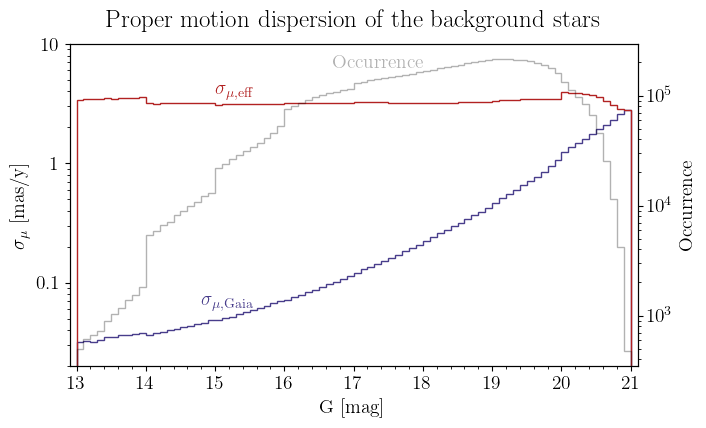

In [132]:
goldenratio = 1.61803
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5*goldenratio, 4.5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
fonts = 14
ax.minorticks_on()

ax.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=pm_error, color=colorlist[0]);
ax.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=pm_eff_error, color=colorlist[1]);
#ax.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=pmdec_eff_error, color=colorlist[2]);
#ax.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=gmag_counts*5E-5, color='k', alpha=0.3);

ax2 = ax.twinx()    
ax2.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=gmag_counts, color='k', alpha=0.3)

ax.set_xlabel(r'G [mag]', fontsize = fonts); ax.set_ylabel(r'$\sigma_{\mu}$ [mas/y]', fontsize = fonts)
ax2.set_ylabel(r'Occurrence', fontsize = fonts)
ax.set_xlim(12.9, 21.1); ax.set_ylim(0.02, 10)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels[2] = '$\\mathdefault{0.1}$'; labels[3] = '$\\mathdefault{1}$'; labels[4] = '$\\mathdefault{10}$'
ax.set_yticklabels(labels);

ax.set_title('Proper motion dispersion of the background stars ', fontsize = 18, pad=12)
ax.text(16.7, 6.3, 'Occurrence', color='k', alpha=0.3, fontsize = fonts)
ax.text(15, 3.8, r'$\sigma_{\mu, \mathrm{eff}}$', color=colorlist[1], fontsize = fonts)
ax.text(14.8, 0.065, r'$\sigma_{\mu, \mathrm{Gaia}}$', color=colorlist[0], fontsize = fonts)

fig.tight_layout()
fig.savefig(FigDir+'eff_error_g.pdf')

In [98]:
### Impact parameter and unit vector in the direction of the impact parameter
b_il = fn_angular_sep(df_back['ra'].to_numpy()*degree, df_back['dec'].to_numpy()*degree,
                      df_fore['ra'].to_numpy()*degree, df_fore['dec'].to_numpy()*degree)
b_il_norm = np.sqrt(b_il[:, 0]**2+b_il[:, 1]**2)/arcsec

In [101]:
bins = np.arange(0, 3, 0.05)
bil_counts = np.histogram(b_il_norm, bins=bins)[0]

pm_error = np.histogram(b_il_norm, bins=bins, 
                        weights=np.sqrt(df_back['pmra_error'].to_numpy()**2 + df_back['pmdec_error'].to_numpy()**2 + 
                                          2*df_back['pmra_pmdec_corr'].to_numpy()*df_back['pmra_error'].to_numpy()*df_back['pmdec_error'].to_numpy())  )[0]
pm_error = np.divide(pm_error, bil_counts, out=np.zeros(len(bil_counts)), where=(bil_counts>0) )

pm_eff_error = np.histogram(b_il_norm, bins=bins, 
                            weights=np.sqrt(df_back['pmra_eff_error_new'].to_numpy()**2 + df_back['pmdec_eff_error_new'].to_numpy()**2 +
                                            2*df_back['pmra_pmdec_eff_corr_new'].to_numpy()*df_back['pmra_eff_error_new'].to_numpy()*df_back['pmdec_eff_error_new'].to_numpy()) )[0]
pm_eff_error = np.divide(pm_eff_error, bil_counts, out=np.zeros(len(bil_counts)), where=(bil_counts>0))

<ipython-input-81-810ceb6cffd4>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels);


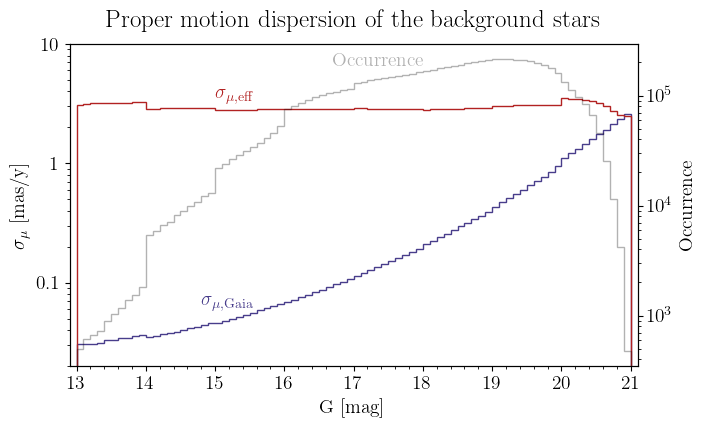

In [81]:
goldenratio = 1.61803
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5*goldenratio, 4.5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
fonts = 14
ax.minorticks_on()

ax.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=pmra_error, color=colorlist[0]);
ax.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=pm_eff_error, color=colorlist[1]);
#ax.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=pmdec_eff_error, color=colorlist[2]);
#ax.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=gmag_counts*5E-5, color='k', alpha=0.3);

ax2 = ax.twinx()    
ax2.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=gmag_counts, color='k', alpha=0.3)

ax.set_xlabel(r'G [mag]', fontsize = fonts); ax.set_ylabel(r'$\sigma_{\mu}$ [mas/y]', fontsize = fonts)
ax2.set_ylabel(r'Occurrence', fontsize = fonts)
ax.set_xlim(12.9, 21.1); ax.set_ylim(0.02, 10)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels[2] = '$\\mathdefault{0.1}$'; labels[3] = '$\\mathdefault{1}$'; labels[4] = '$\\mathdefault{10}$'
ax.set_yticklabels(labels);

ax.set_title('Proper motion dispersion of the background stars ', fontsize = 18, pad=12)
ax.text(16.7, 6.5, 'Occurrence', color='k', alpha=0.3, fontsize = fonts)
ax.text(15, 3.5, r'$\sigma_{\mu, \mathrm{eff}}$', color=colorlist[1], fontsize = fonts)
ax.text(14.8, 0.065, r'$\sigma_{\mu, \mathrm{Gaia}}$', color=colorlist[0], fontsize = fonts)

fig.tight_layout()
#fig.savefig(FigDir+'bg_star_anisotropy.png')

<ipython-input-128-a8d1ecfc32e5>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels);


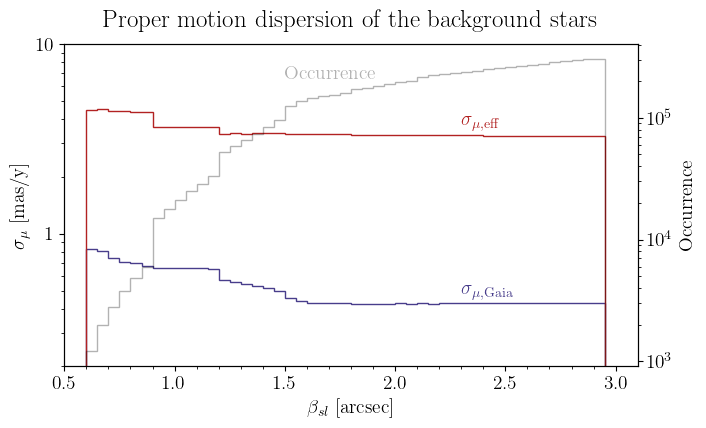

In [128]:
goldenratio = 1.61803
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5*goldenratio, 4.5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
fonts = 14
ax.minorticks_on()


ax.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=pm_error, color=colorlist[0]);
ax.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=pm_eff_error, color=colorlist[1]);

ax2 = ax.twinx()    
ax2.hist(bins[:-1], bins=bins, log=True, density=False, histtype='step', weights=bil_counts, color='k', alpha=0.3);

ax.set_xlabel(r'$\beta_{sl}$ [arcsec]', fontsize = fonts); ax.set_ylabel(r'$\sigma_{\mu}$ [mas/y]', fontsize = fonts)
ax2.set_ylabel(r'Occurrence', fontsize = fonts)
ax.set_xlim(0.5, 3.1); ax.set_ylim(0.2, 10)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels[2] = '$\\mathdefault{1}$'; labels[3] = '$\\mathdefault{10}$'
ax.set_yticklabels(labels);


ax.set_title('Proper motion dispersion of the background stars ', fontsize = 18, pad=12)
ax.text(1.5, 6.5, 'Occurrence', color='k', alpha=0.3, fontsize = fonts)
ax.text(2.3, 3.7, r'$\sigma_{\mu, \mathrm{eff}}$', color=colorlist[1], fontsize = fonts)
ax.text(2.3, 0.48, r'$\sigma_{\mu, \mathrm{Gaia}}$', color=colorlist[0], fontsize = fonts)

fig.tight_layout()
fig.savefig(FigDir+'eff_error_b.pdf')

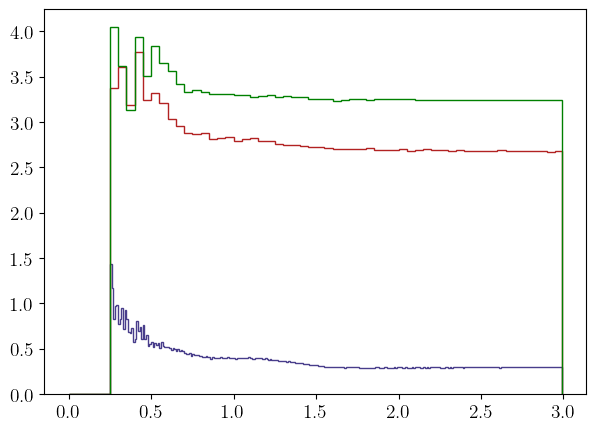

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
liestyle_list = ['-.', 'solid']


ax.hist(bins[:-1], bins=bins, log=False, density=False, histtype='step', weights=pmra_error, color=colorlist[0]);
ax.hist(bins[:-1], bins=bins, log=False, density=False, histtype='step', weights=pmra_eff_error, color=colorlist[1]);
ax.hist(bins[:-1], bins=bins, log=False, density=False, histtype='step', weights=pmdec_eff_error, color=colorlist[2]);

#ax.axvline(0.3, 0, 1)
#ax.axvline(0.6, 0, 1)
#ax.axvline(0.9, 0, 1)
#ax.axvline(1.2, 0, 1)

## Sky map

In [194]:
eq_to_gal_rot_matrix = np.array([[-0.0548755604162154, -0.8734370902348850, -0.4838350155487132], 
                                 [0.4941094278755837, -0.4448296299600112, 0.7469822444972189], 
                                 [-0.8676661490190047, -0.1980763734312015, 0.4559837761750669]])

def fn_eq_to_gal_array(ra, dec):
    """
    Function to convert the equatorial coordinates (ra, dec) to galactic coordinates according to the Gaia reference frame.
    Works only if ra and dec are numpy arrays. Takes angles in degree and returns in degree.
    Refs.: https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html 
    and section 1.5.3 of https://www.cosmos.esa.int/documents/532822/552851/vol1_all.pdf
    """
    
    ra_s, dec_s = ra*degree, dec*degree
    
    x_vec_eq = np.array([np.cos(dec_s)*np.cos(ra_s), np.cos(dec_s)*np.sin(ra_s), np.sin(dec_s)])
    x_vec_gal = (eq_to_gal_rot_matrix @ x_vec_eq).T
    
    gal_lon, gal_lat = (np.arctan2(x_vec_gal[:, 1], x_vec_gal[:, 0])), np.arctan2(x_vec_gal[:, 2], np.sqrt(x_vec_gal[:, 0]**2 + x_vec_gal[:, 1]**2))
    gal_lon = gal_lon + 2*np.pi*np.heaviside(-gal_lon, 0) ### shift the interval from [-pi, pi] to [0, 2*pi]

    return gal_lon/degree, gal_lat/degree

In [243]:
nside = 2**7
npix = hp.nside2npix(nside)
print('nside =',nside,', npix =',npix)
print('linear pixel size =',str(np.sqrt(4*np.pi / npix) / degree)[0:7],' degree')

nside = 128 , npix = 196608
linear pixel size = 0.45806  degree


In [244]:
back_l, back_b = fn_eq_to_gal_array(df_back['ra'].to_numpy(), df_back['dec'].to_numpy())
q_pix = hp.ang2pix(nside,back_l, back_b,lonlat=True)

In [248]:
bins = np.arange(0, npix+1)
pix_counts = np.histogram(q_pix, bins=bins)[0]
pix_pmra_eff = np.histogram(q_pix, bins=bins, weights=df_back['pmra_eff_error_new'].to_numpy())[0]

pix_pmra_eff = np.divide(pix_pmra_eff, pix_counts, out=np.zeros(len(pix_counts)), where=(pix_counts>0) )

In [251]:
np.min(pix_pmra_eff[pix_pmra_eff>0]), np.max(pix_pmra_eff[pix_pmra_eff>0])

(0.13154343888163567, 4.763980115455342)

In [238]:
aa = np.divide(map_count_1, pix_counts, out=np.zeros(len(pix_counts)), where=(pix_counts>0) )

In [241]:
bb = aa[aa>0]
bb[np.abs(bb-1)>0.001]

array([], dtype=float64)

In [261]:
pix_pmra_eff[pix_pmra_eff==0] = np.nan

In [265]:
map_min, map_max

(0.13154343888163567, nan)

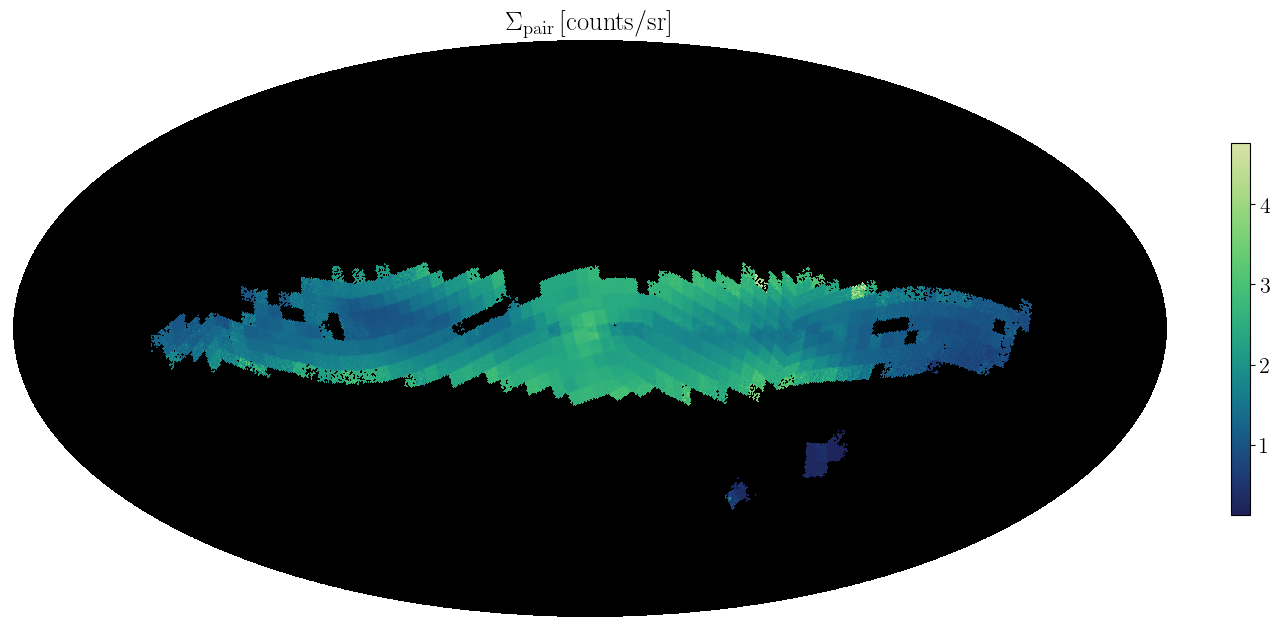

In [266]:
map = pix_pmra_eff #pix_counts / (hp.pixelfunc.nside2resol(nside))**2 
map_min = np.min(pix_pmra_eff[pix_pmra_eff>0]); map_max = np.max(pix_pmra_eff[pix_pmra_eff>0]); 
cmap = sns.cubehelix_palette(start = 0.25, hue = 1.5, rot = -2/3, reverse = True, as_cmap=True)
cmap.set_under('k'); cmap.set_bad(cmap(0)); cmap.set_over(cmap(1));

plt.subplots(1,1,figsize=(16,8))
hp.mollview(map, title=r'$\Sigma_\mathrm{pair} \, [\mathrm{counts/sr}]$', 
            cmap=cmap,cbar=None, 
            bgcolor='white',badcolor='black',
            min=map_min,max=map_max,
            xsize=5000,hold=True,
            #norm=mpl.colors.LogNorm(vmin=map_min,vmax=map_max)
           )
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.015);
#cbar.set_label(r'$\Sigma_\mathrm{pair} \, [\mathrm{counts/sr}]$', fontsize=16)

mpl.rcParams.update({'font.size': 16})

#fig.savefig(FigDir+'pairs_map_2.pdf',figsize=(8,6),bbox_inches='tight')#,bbox_extra_artists=(image,)',dpi=300,)

# Proper motion distributions

In [45]:
fg_pmra = df_fore['pmra']
fg_pmdec = df_fore['pmdec']
fg_pmra_err = df_fore['pmra_error']
fg_pmdec_err = df_back['pmdec_error']
(np.average(fg_pmra, weights=1/fg_pmra_err**2), np.average(fg_pmdec, weights=1/fg_pmdec_err**2))

(-4.001569694147646, -3.51482577386855)

In [46]:
bg_pmra = df_back['pmra_sub']
bg_pmdec = df_back['pmdec_sub']

np.cov(bg_pmra, bg_pmdec)

array([[4.47289448, 1.18610646],
       [1.18610646, 4.77310608]])

In [47]:
fg_pm_mag = np.sqrt(df_foresmaller['pmra']**2 + df_foresmaller['pmdec']**2)
bg_pm_mag = np.sqrt(df_backsmaller['pmra_sub_new']**2 + df_backsmaller['pmdec_sub_new']**2)

fg_parallax = np.asarray(df_foresmaller['parallax'])

In [48]:
fg_pm_error = np.sqrt(df_foresmaller['pmra_error']**2 + df_foresmaller['pmdec_error']**2)
bg_pm_error = np.sqrt(df_backsmaller['pmra_error']**2 + df_backsmaller['pmdec_error']**2)

In [49]:
mu_min = 0
mu_max = 10000

condition = (fg_pm_mag < mu_max) & (fg_pm_mag > mu_min)
df_back1 =  df_backsmaller[condition]
df_fore1 =  df_foresmaller[condition]
l_bilnormsq1 = l_bilnormsq_smaller[condition]

fg_pm_mag1 = np.sqrt(df_fore1['pmra']**2 + df_fore1['pmdec']**2)
len(df_fore1)

8283937

In [50]:
cutoff_mu = 1

df_backfar = df_back1[np.sqrt(l_bilnormsq1)/arcsec > 1.5]
far_mean = np.mean(df_backfar['pmra_sub_new']); print(far_mean)

-0.0011961182748340792


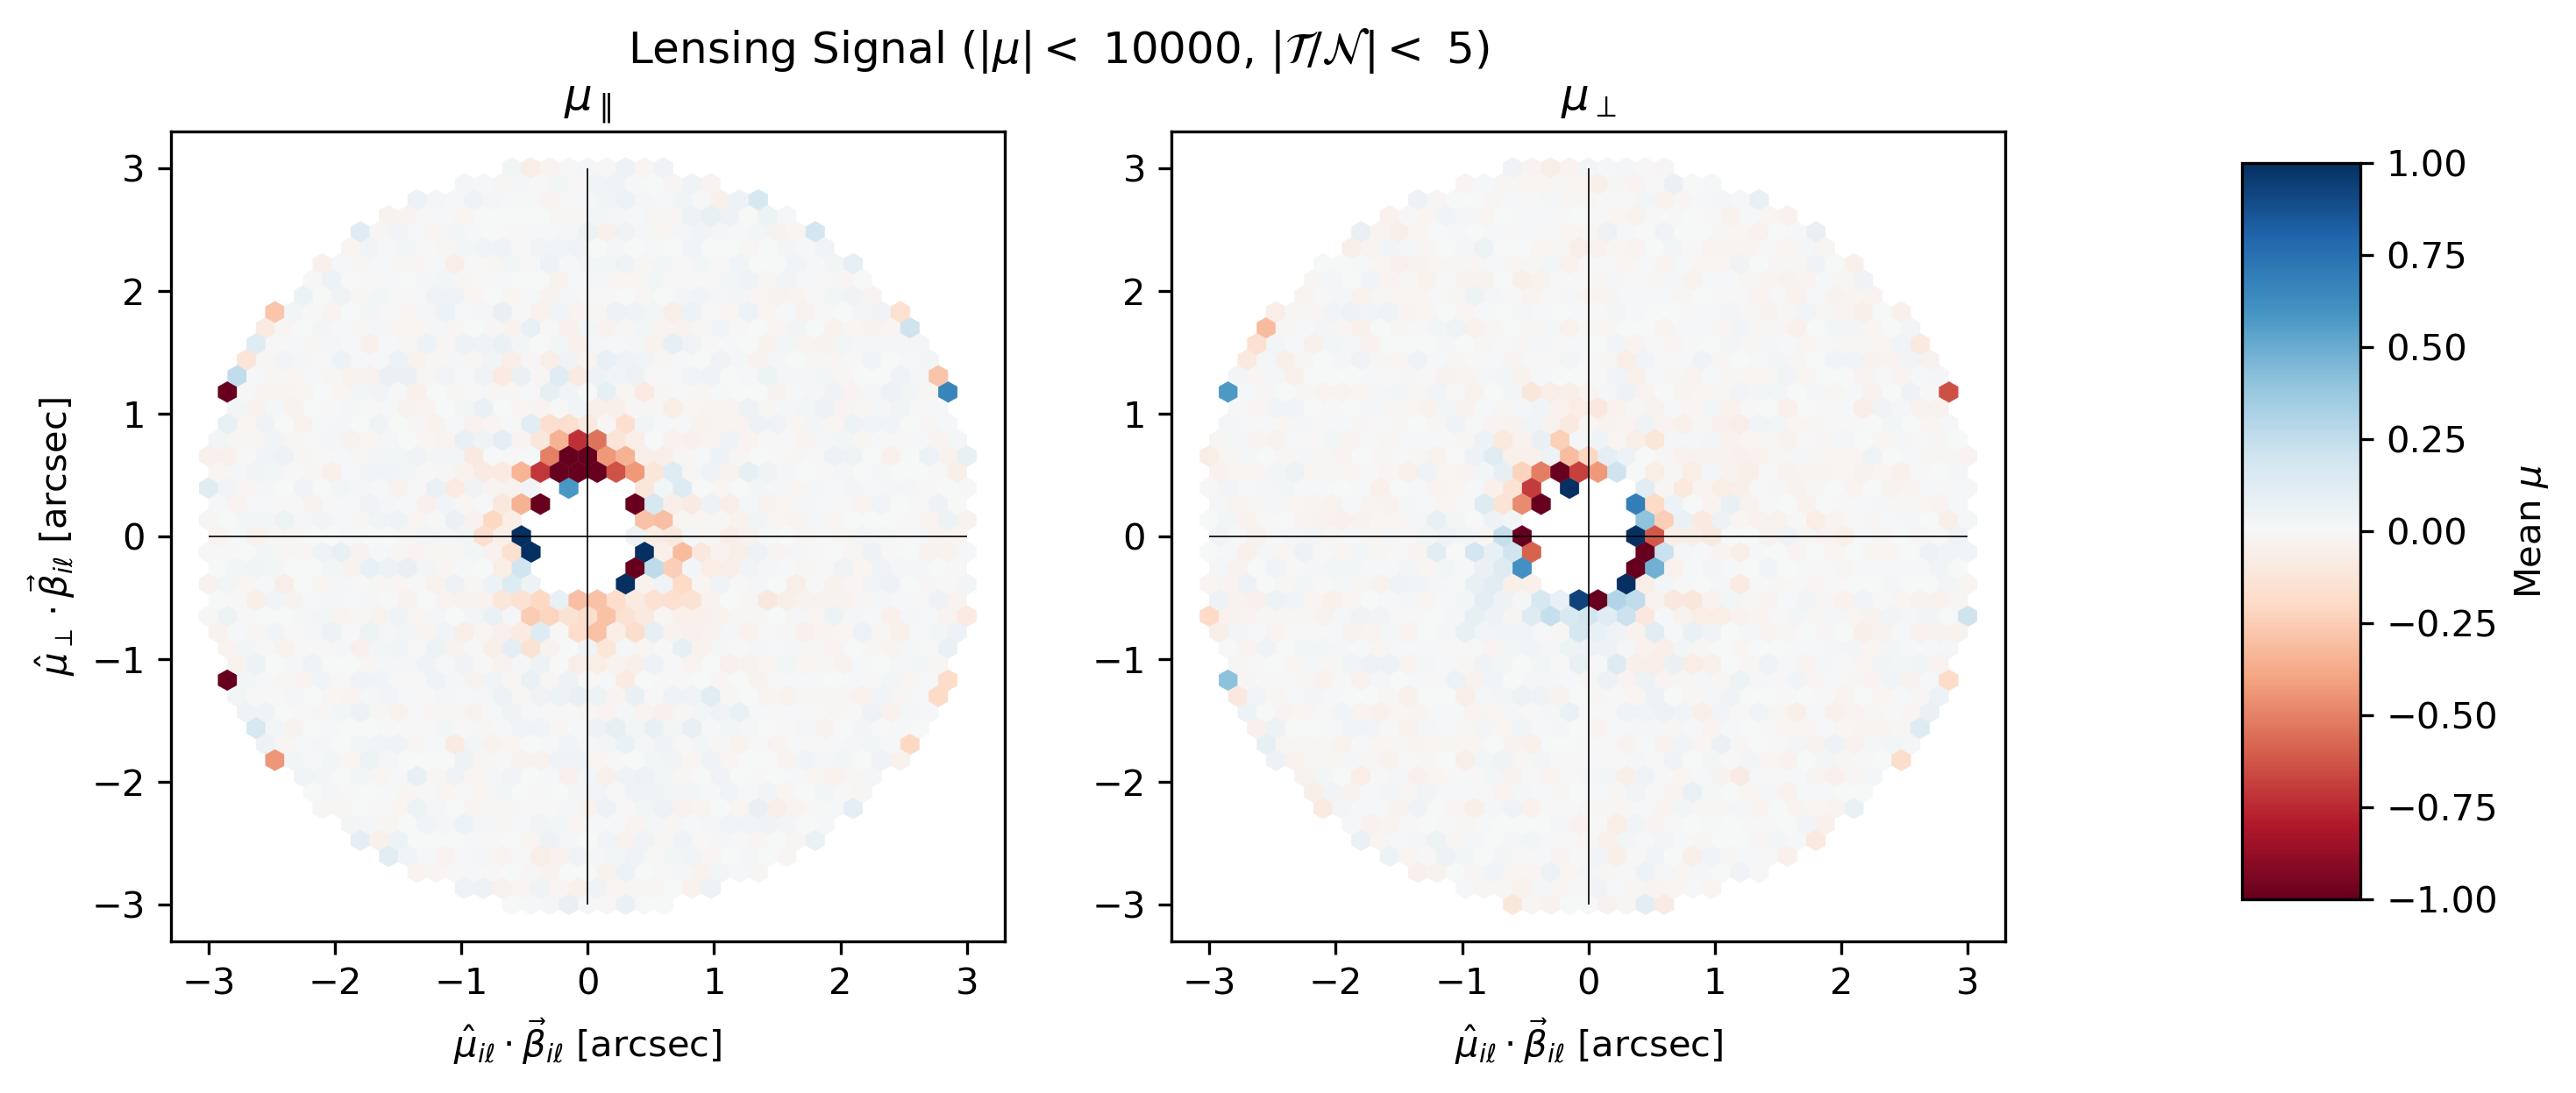

In [51]:
fig, ax = plt.subplots(1,2, figsize=(9,4),dpi=300)

im1 = ax[0].hexbin(x=df_back1['dotprod_bil'], y=df_back1['dotperp_bil'], C=(df_back1['mu_par']), reduce_C_function = np.mean, vmin = -cutoff_mu, vmax = cutoff_mu, gridsize=40, cmap = 'RdBu',linewidths=0.1)
ax[0].set_ylabel(r'$\hat{\mu}_{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[0].set_xlabel(r'$\hat{\mu}_{i\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[0].set_title(r'$\mu_\parallel$')

ax[0].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[0].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4);

#cbar_ax1 = fig.add_axes([-.05, 0.15, 0.05, 0.7])
cbar_ax1 = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)


cbar1.set_label(r'Mean $\mu$')
#cbar2.set_label(r'Mean fg $\varpi/\sigma_\varpi$')


im2 = ax[1].hexbin(x=df_back1['dotprod_bil'], y=df_back1['dotperp_bil'], C=(np.asarray(df_back1['mu_perp'])), reduce_C_function = np.mean, vmin = -cutoff_mu, vmax = cutoff_mu, gridsize=40, cmap = 'RdBu',linewidths=0.1)
#ax[1].set_ylabel(r'$\hat{\mu}_{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[1].set_xlabel(r'$\hat{\mu}_{i\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[1].set_title(r'$\mu_\perp$')

ax[1].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[1].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)

#cbar_ax1 = fig.add_axes([-.05, 0.15, 0.05, 0.7])
#cbar_ax2 = fig.add_axes([1, 0.15, 0.05, 0.7])
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)


cbar1.set_label(r'Mean $\mu$')
#cbar2.set_label(r'Mean fg $\varpi/\sigma_\varpi$')
fig.suptitle(r'Lensing Signal ($|\mu| <$ ' + str(mu_max) + r', $|\mathcal{T}/\mathcal{N}| <$ ' + str(cutoff_tau) + ')')
fig.show()
#fig.savefig('lensing_signal.pdf')

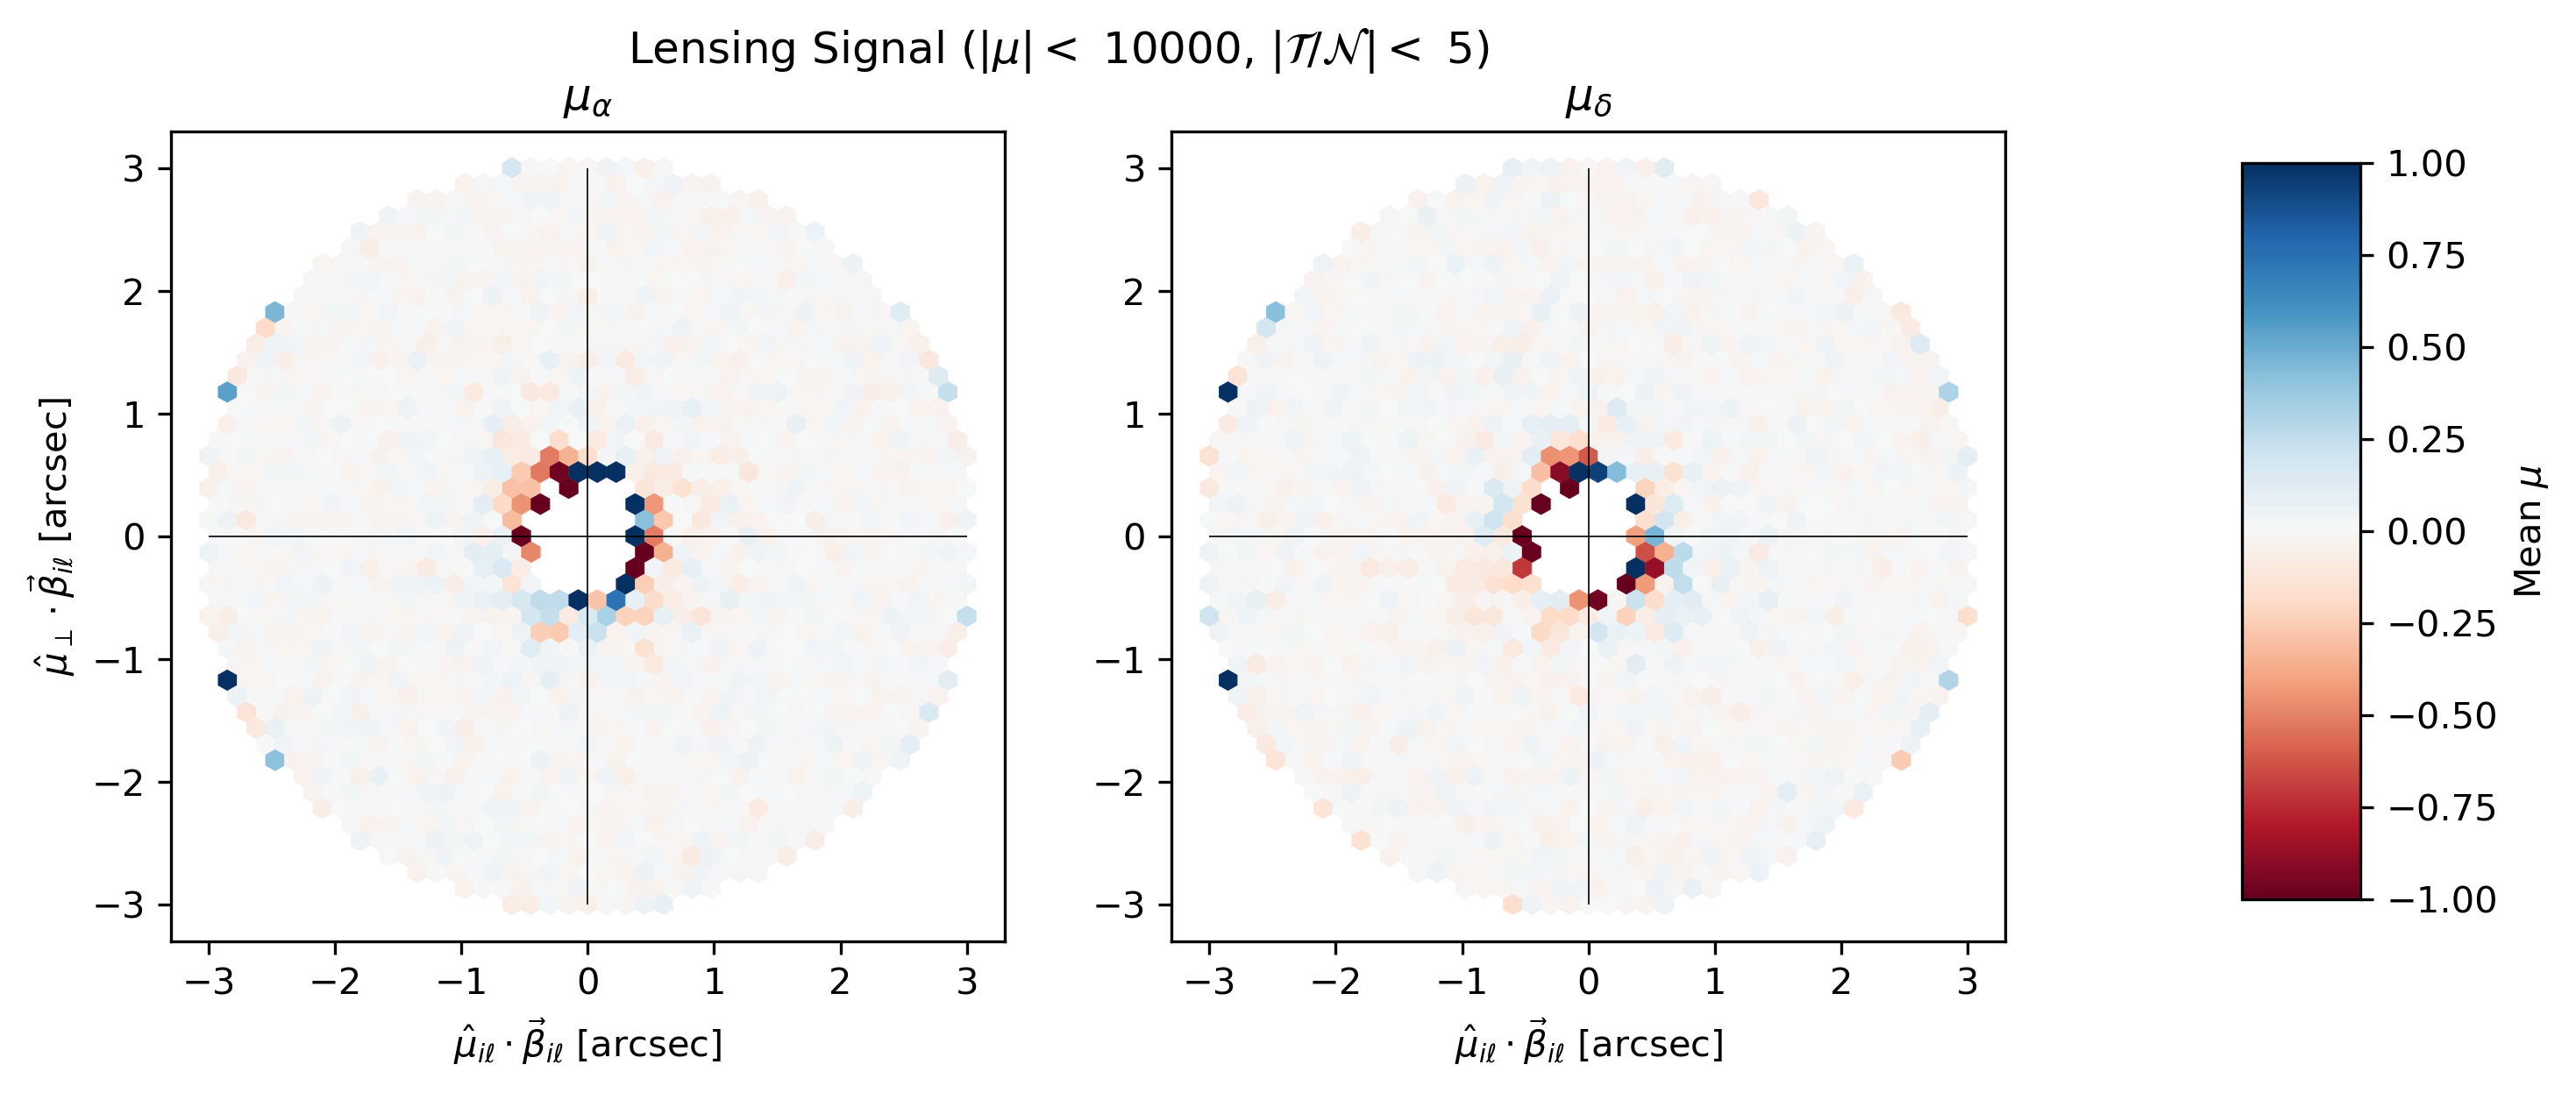

In [52]:
fig, ax = plt.subplots(1,2, figsize=(9,4),dpi=300)

im1 = ax[0].hexbin(x=df_back1['dotprod_bil'], y=df_back1['dotperp_bil'], C=(df_back1['pmra_sub_new']), reduce_C_function = np.mean, vmin = -cutoff_mu, vmax = cutoff_mu, gridsize=40, cmap = 'RdBu',linewidths=0.1)
ax[0].set_ylabel(r'$\hat{\mu}_{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[0].set_xlabel(r'$\hat{\mu}_{i\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[0].set_title(r'$\mu_\alpha$')

ax[0].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[0].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4);

#cbar_ax1 = fig.add_axes([-.05, 0.15, 0.05, 0.7])
cbar_ax1 = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)


cbar1.set_label(r'Mean $\mu$')
#cbar2.set_label(r'Mean fg $\varpi/\sigma_\varpi$')


im2 = ax[1].hexbin(x=df_back1['dotprod_bil'], y=df_back1['dotperp_bil'], C=(np.asarray(df_back1['pmdec_sub_new'])), reduce_C_function = np.mean, vmin = -cutoff_mu, vmax = cutoff_mu, gridsize=40, cmap = 'RdBu',linewidths=0.1)
#ax[1].set_ylabel(r'$\hat{\mu}_{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[1].set_xlabel(r'$\hat{\mu}_{i\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[1].set_title(r'$\mu_\delta$')

ax[1].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[1].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)

#cbar_ax1 = fig.add_axes([-.05, 0.15, 0.05, 0.7])
#cbar_ax2 = fig.add_axes([1, 0.15, 0.05, 0.7])
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)


cbar1.set_label(r'Mean $\mu$')
#cbar2.set_label(r'Mean fg $\varpi/\sigma_\varpi$')
fig.suptitle(r'Lensing Signal ($|\mu| <$ ' + str(mu_max) + r', $|\mathcal{T}/\mathcal{N}| <$ ' + str(cutoff_tau) + ')')
fig.show()
#fig.savefig('lensing_signal.pdf')

## Mean PM in radial bins

In [41]:
l_mean_pmra_sub = np.zeros(len(bil_bins))
l_mean_pmdec_sub = np.zeros(len(bil_bins))

In [42]:
### Impact parameter and unit vector in the direction of the impact parameter
b_il = fn_angular_sep(df_fore['ra'].to_numpy()*degree, df_fore['dec'].to_numpy()*degree, 
                      df_back['ra'].to_numpy()*degree, df_back['dec'].to_numpy()*degree)
b_il_norm = np.sqrt(b_il[:, 0]**2 + b_il[:, 1]**2)


bil_bins = np.arange(0.6, 3., 0.2)
print(bil_bins)

dist_list = b_il_norm/arcsec; print(dist_list)
b_list = np.digitize(dist_list, bil_bins); np.bincount(b_list)

[0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8]
[1.78973177 2.80396513 2.28992809 ... 2.85387801 1.98291534 2.16848257]


array([    816,   43645,  121917,  237360,  398361,  638541,  832382,
        943438, 1079151, 1193528, 1292866, 1388579, 1488168])

In [43]:
cov_pm = fn_cov_pm_eff(df_back)

In [44]:
#mean_parallel = np.zeros(len(bil_bins))
#mean_perp = np.zeros(len(bil_bins))

mean_old = np.zeros(len(bil_bins))
mean_new = np.zeros(len(bil_bins))
errbars = np.zeros(len(bil_bins))

#mu_par = #df_back['mu_par'].values
#mu_perp = #df_back['mu_perp'].values

mean_parallel = np.zeros(len(bil_bins))
mean_perp = np.zeros(len(bil_bins))

old_sub_pmra = df_back['pmra_sub']
#old_sub_pmdec = df_back['pmdec_sub']

new_sub_pmra = df_back['pmra_sub_new']
#new_sub_pmdec = df_back['pmdec_sub_new']


pmra_eff_err = np.sqrt(cov_pm[:, 0, 0]) #df_back['pmra_eff_error'].values
pmdec_eff_err = np.sqrt(cov_pm[:, 1, 1])#df_back['pmdec_eff_error'].values

In [45]:
for i_b in tqdm(range(len(bil_bins))):
    mu_old_i_b = old_sub_pmra[b_list == i_b]
    mu_new_i_b = new_sub_pmra[b_list == i_b]

    pmra_eff_err_i_b = pmra_eff_err[b_list == i_b]
    pmdec_eff_err_i_b = pmdec_eff_err[b_list == i_b]

    # weights
    d_wt = np.asarray(1/(pmra_eff_err_i_b**2 + pmdec_eff_err_i_b**2))
    ebar = np.sqrt((1/len(d_wt)**2) * np.sum(1/d_wt))


    # compute averages
    mean_old_i_b = np.average(mu_old_i_b, weights = d_wt)
    mean_new_i_b = np.average(mu_new_i_b, weights = d_wt)

    mean_old[i_b] = mean_old_i_b
    mean_new[i_b] = mean_new_i_b
    errbars[i_b] = ebar

100%|██████████| 12/12 [00:02<00:00,  5.41it/s]


In [46]:
mean_parallel

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [47]:
mean_perp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

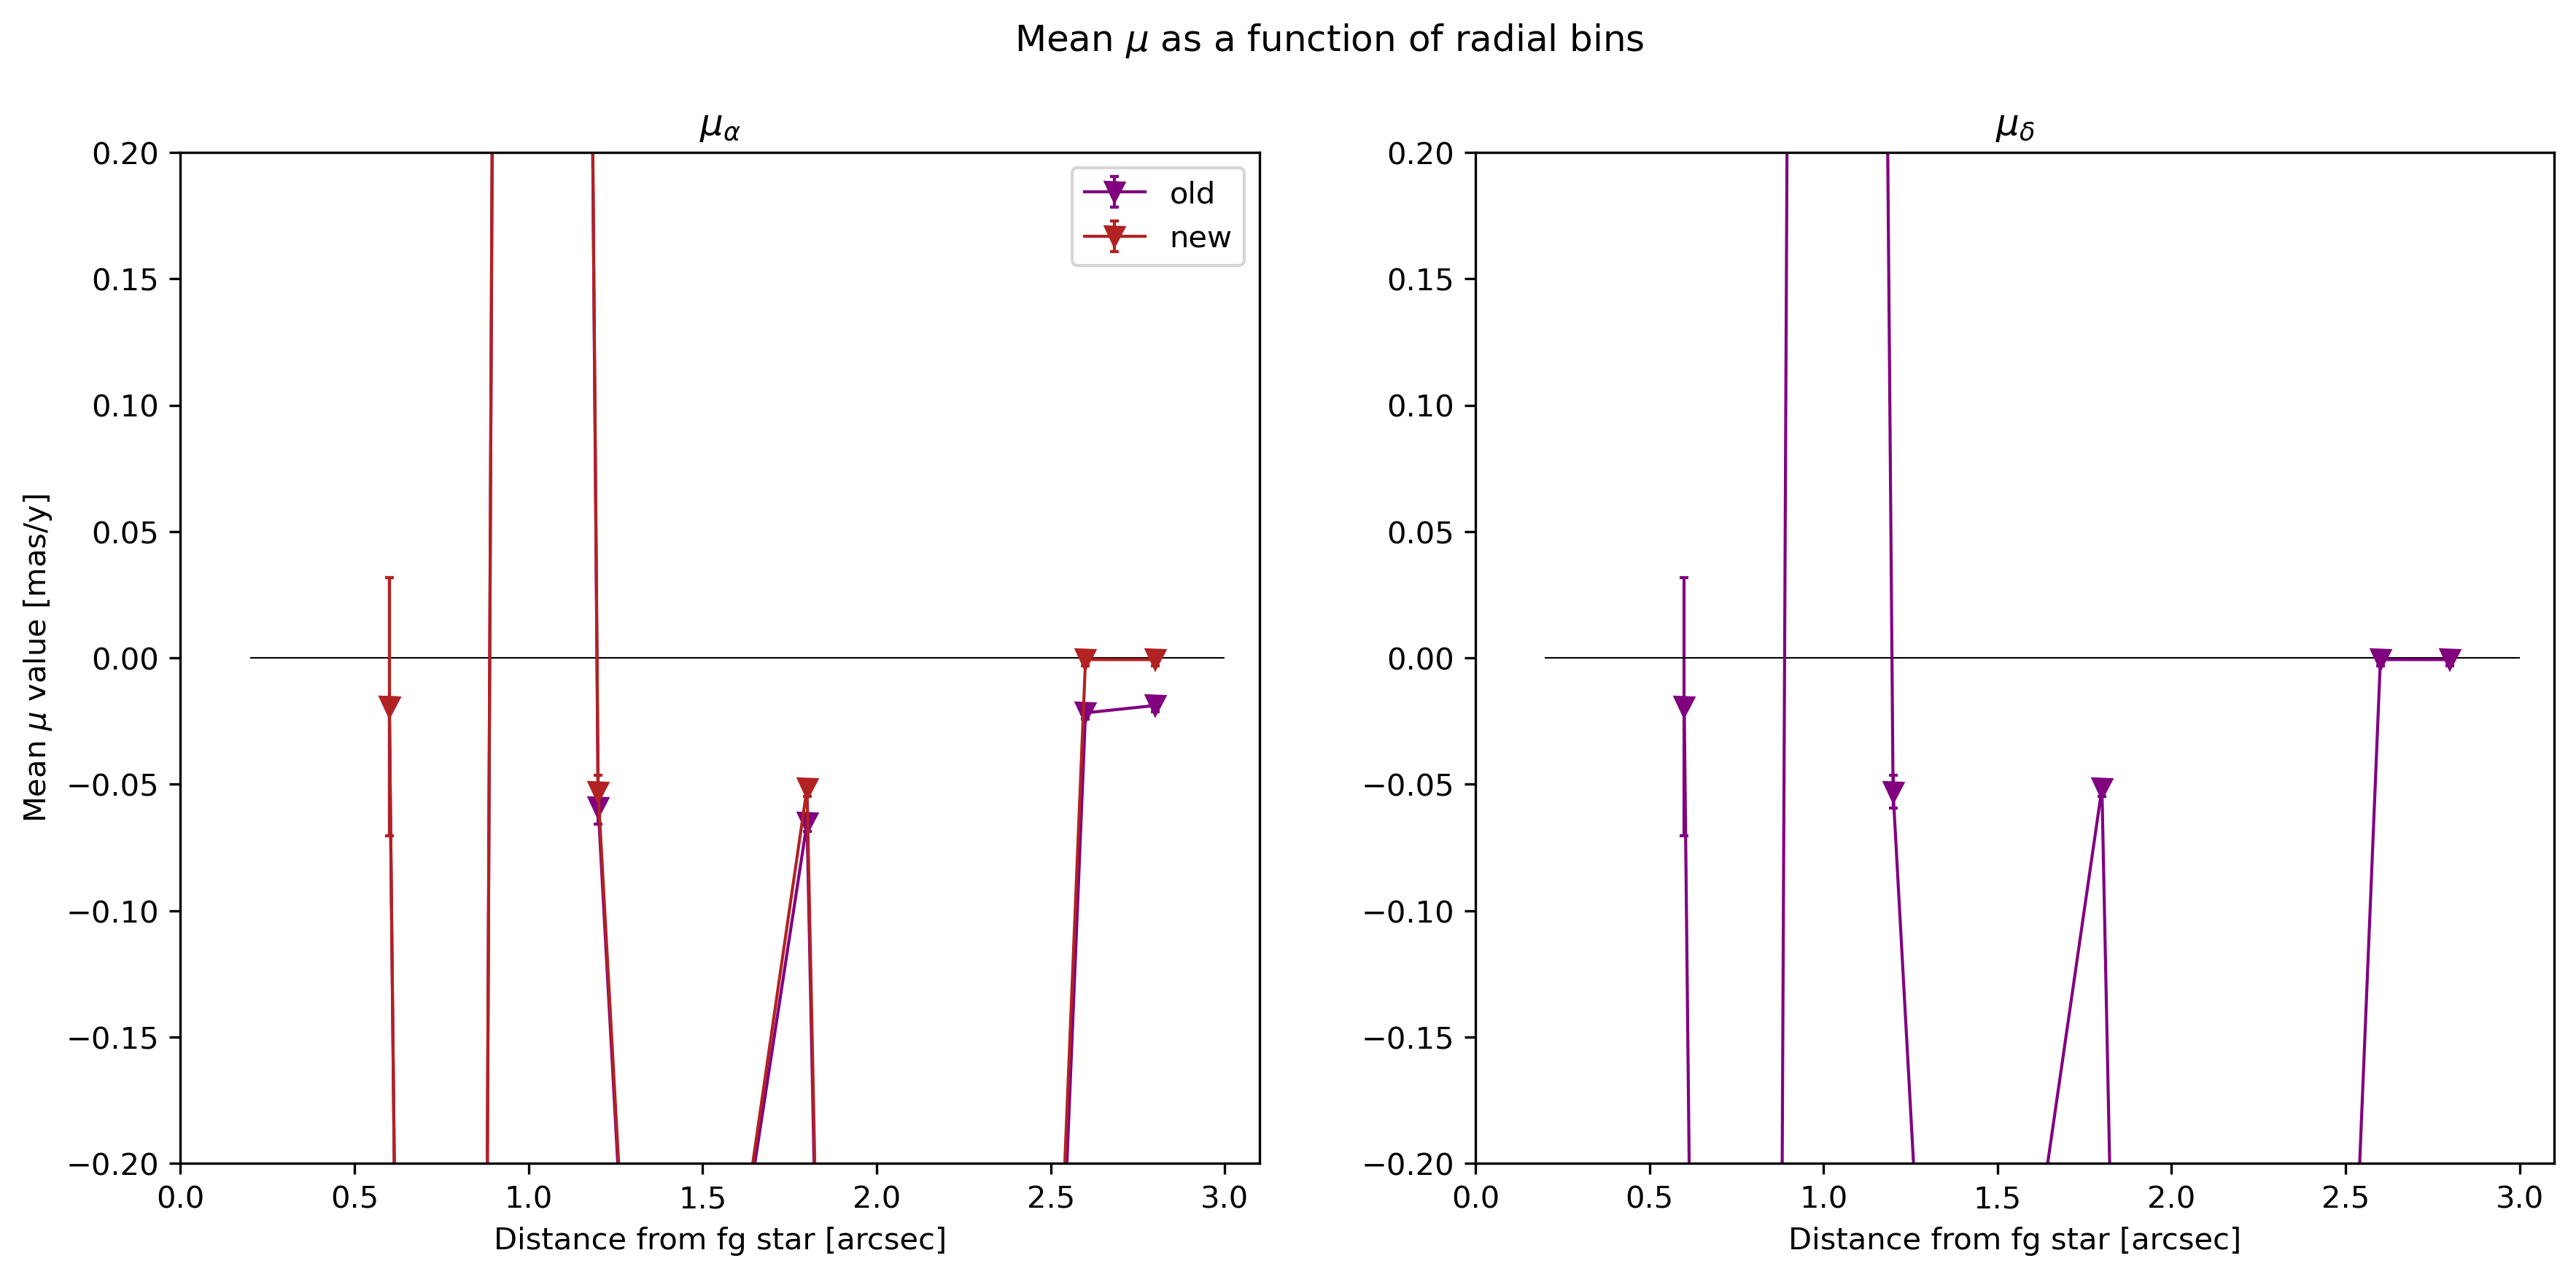

In [48]:
fig, ax = plt.subplots(1,2, figsize=(14,6),dpi=300)
ax[0].errorbar(bil_bins, mean_old, yerr = errbars, marker = 'v', label = 'old', color = 'purple', 
            elinewidth= 1, capsize = 1.5,
            lw= 1)

ax[0].set_ylabel(r'Mean $\mu$ value [mas/y]')
ax[0].set_xlabel(r'Distance from fg star [arcsec]')
ax[0].set_title(r'$\mu_\alpha$')


#ax[0].legend()
ax[0].hlines(0, 0.2, 3, colors='k', linestyles='solid', linewidth=0.5) 
ax[0].set_xlim(0, 3.1)
ax[0].set_ylim(-0.2,0.2)

ax[0].errorbar(bil_bins, mean_new, yerr = errbars, marker = 'v', label = 'new', color = 'firebrick', 
            elinewidth= 1, capsize = 1.5,
            lw= 1)

ax[0].legend()

ax[1].errorbar(bil_bins, mean_new, yerr = errbars, marker = 'v', label = 'Measured', color = 'purple', 
            elinewidth= 1, capsize = 1.5,
            lw= 1)

ax[1].set_xlabel(r'Distance from fg star [arcsec]')
ax[1].set_title(r'$\mu_\delta$')

#ax[1].legend()
ax[1].hlines(0, 0.2, 3, colors='k', linestyles='solid', linewidth=0.5) 
ax[1].set_xlim(0, 3.1)
ax[1].set_ylim(-0.2,0.2)
fig.suptitle(r'Mean $\mu$ as a function of radial bins')
fig.show()

# G-magnitude dependence

In [74]:
G_bins = np.array([5, 15, 16, 17, 17.5, 17.9, 18.3, 18.6, 18.8, 18.95, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.72, 22])
q_G = np.digitize(df_foresmaller['phot_g_mean_mag'], G_bins)-1
df_foresmaller['q_G'] = q_G
df_backsmaller['q_G'] = q_G
print(G_bins[q_G])

[15.  19.2  5.  ...  5.  19.9  5. ]


/tmp/ipykernel_1834950/1644630271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foresmaller['q_G'] = q_G
/tmp/ipykernel_1834950/1644630271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backsmaller['q_G'] = q_G


In [75]:
G_count = np.bincount(df_foresmaller['q_G'])
print(len(G_count), len(bil_bins), sum(G_count))

28 28 8711533


In [76]:
df_foreground = df_foresmaller.sort_values(by=['q_G'], ascending=True)
df_background = df_backsmaller.sort_values(by=['q_G'], ascending=True)
df_foreground['q_G']

8763141     0
751676      0
751677      0
5299702     0
751681      0
           ..
1176578    27
6330598    27
8429893    27
4149384    27
2523886    27
Name: q_G, Length: 8711533, dtype: int64

In [78]:
tau_mu_list, tau_norm_list = np.zeros(len(G_count)), np.zeros(len(G_count))
tau_rot90_list, tau_norm_rot90_list = np.zeros(len(G_count)), np.zeros(len(G_count))
tau_monopole_list, tau_norm_monopole_list = np.zeros(len(G_count)), np.zeros(len(G_count))
tau_quad_list, tau_norm_quad_list = np.zeros(len(G_count)), np.zeros(len(G_count))
gmag_mean = np.zeros(len(G_count))

last = 0
for i in tqdm(range(len(G_count))):
    df_fore_sub = df_foreground.iloc[last:last+G_count[i]] 
    df_back_sub = df_background.iloc[last:last+G_count[i]]
    last += G_count[i]
    
    gmag_mean[i] = np.mean(df_fore_sub['phot_g_mean_mag'].to_numpy())
    
    inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back_sub))

    tau_mu_list[i], tau_norm_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_dipole_mf)
    tau_rot90_list[i], tau_norm_rot90_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_dipole_mf, rot_angle=90*degree)
    tau_monopole_list[i], tau_norm_monopole_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_monopole_mf)
    tau_quad_list[i], tau_norm_quad_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_quadrupole_mf)
        
    del df_fore_sub
    del df_back_sub
print(last)

100%|██████████| 28/28 [00:11<00:00,  2.35it/s]

8711533


In [79]:
tau_mu_list/tau_norm_list

array([-4.39750066, -1.48028627,  0.26956453, -1.3199661 ,  1.42920882,
       -0.76376564,  0.78093865,  0.74832516,  2.3609151 ,  0.94696279,
        0.520788  ,  2.56065492,  2.42853445,  1.36114487,  2.04603247,
        2.86414119,  5.30940887,  4.20293751,  3.24998378,  2.56398132,
        3.50442406,  5.24017635,  5.10371352,  3.71724546,  2.43994785,
        3.4313919 ,  3.613935  ,  1.02071717])

In [80]:
tau_monopole_list/tau_norm_monopole_list

array([ 0.25347621, -0.76715053,  1.88902013,  1.99963905,  0.48456615,
        0.16063728,  1.53634791,  1.14432362, -0.40602143,  2.0874804 ,
       -0.09813227,  0.02840938, -0.01856   ,  0.13007882,  0.34140914,
        1.12154797,  1.15957271,  1.24740957, -0.80802442, -0.23176239,
        1.4585256 , -0.11519842,  1.13203493,  0.92080001,  0.12202856,
       -1.55650092, -2.5156179 ,  0.47127152])

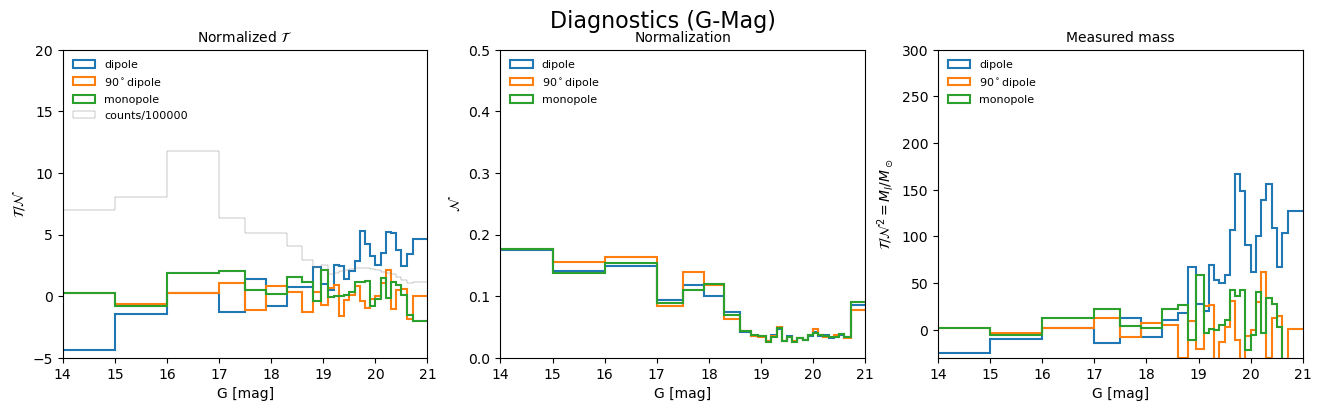

In [82]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

ax[0].hist(G_bins, bins=G_bins, weights=tau_mu_list/tau_norm_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(G_bins, bins=G_bins, weights=tau_rot90_list/tau_norm_rot90_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(G_bins, bins=G_bins, weights=tau_monopole_list/tau_norm_monopole_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(G_bins, bins=G_bins, weights=G_count/100000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[0].set_xlim(14,21); ax[0].set_ylim(-5,20);

ax[0].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/100000'], loc='upper left', fontsize = 8, frameon=False);
ax[0].set_ylabel(r'$\mathcal{T}/\mathcal{N} $'); ax[0].set_xlabel('G [mag]');
ax[0].set_title(r'Normalized $\mathcal{T}$', fontsize = 10);

ax[1].hist(G_bins, bins=G_bins, weights=tau_norm_list, log=False, histtype='step', linewidth=1.5);
ax[1].hist(G_bins, bins=G_bins, weights=tau_norm_rot90_list, log=False, histtype='step', linewidth=1.5);
ax[1].hist(G_bins, bins=G_bins, weights=tau_norm_monopole_list, log=False, histtype='step', linewidth=1.5);
#ax[1].hist(G_bins[:-1], bins=G_bins, weights=G_count/50000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[1].set_xlim(14,21); ax[1].set_ylim(0,0.5);
ax[1].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/($5\times 10^4$)'], loc='upper left', fontsize = 8, frameon=False);
ax[1].set_ylabel(r'$\mathcal{N}$'); ax[1].set_xlabel('G [mag]');
ax[1].set_title(r'Normalization', fontsize = 10);

ax[2].hist(G_bins, bins=G_bins, weights=tau_mu_list/tau_norm_list**2, log=False, histtype='step', linewidth=1.5);
ax[2].hist(G_bins, bins=G_bins, weights=tau_rot90_list/tau_norm_rot90_list**2, log=False, histtype='step', linewidth=1.5);
ax[2].hist(G_bins, bins=G_bins, weights=tau_monopole_list/tau_norm_monopole_list**2, log=False, histtype='step', linewidth=1.5);
#ax[2].hist(G_bins[:-1], bins=G_bins, weights=G_count/1000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[2].set_xlim(14,21); ax[2].set_ylim(-30,300);

ax[2].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/200'], loc='upper left', fontsize = 8, frameon=False);
ax[2].set_ylabel(r'$\mathcal{T}/\mathcal{N}^2 = M_l/M_\odot $'); ax[2].set_xlabel('G [mag]');
ax[2].set_title(r'Measured mass', fontsize = 10);

#plt.tight_layout()
fig.suptitle(r'Diagnostics (G-Mag)', fontsize = 16)
fig.show()
#fig.savefig(FigDir+'tau_vs_gmag.pdf')

# bil diagnostics

In [113]:
fg_ra = df_foresmaller['ra'] 
fg_dec = df_foresmaller['dec']
fg_pmra= df_foresmaller['pmra'] 
fg_pmdec= df_foresmaller['pmdec']


bg_ra = df_backsmaller['ra']
bg_dec = df_backsmaller['dec'] 
bg_pmra= df_backsmaller['pmra_sub_new'] 
bg_pmdec= df_backsmaller['pmdec_sub_new'] 

#bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
l_sep = np.sqrt(l_bilnormsq)/arcsec
df_foresmaller['l_sep'] = l_sep
df_backsmaller['l_sep'] = l_sep

bil_bins = np.arange(0,3,0.4)#np.array([5, 15, 16, 17, 17.5, 17.9, 18.3, 18.6, 18.8, 18.95, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.72, 22])
q_bil = np.digitize(l_sep, bil_bins)-1
df_foresmaller['q_bil'] = q_bil
df_backsmaller['q_bil'] = q_bil
print(bil_bins[q_bil])

/tmp/ipykernel_1834950/3201154997.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foresmaller['l_sep'] = l_sep
/tmp/ipykernel_1834950/3201154997.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backsmaller['l_sep'] = l_sep
/tmp/ipykernel_1834950/3201154997.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

[2.8 2.4 2.4 ... 2.8 2.4 2.8]


/tmp/ipykernel_1834950/3201154997.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backsmaller['q_bil'] = q_bil


In [114]:
df_foreground = df_foresmaller.sort_values(by=['q_bil'], ascending=True)
df_background = df_backsmaller.sort_values(by=['q_bil'], ascending=True)
df_foreground['q_bil']

1605322    0
1476104    0
8219957    0
1455961    0
1548744    0
          ..
5014818    7
5014827    7
5014838    7
5014736    7
8763141    7
Name: q_bil, Length: 8711533, dtype: int64

In [115]:
bil_count = np.bincount(df_foresmaller['q_bil'])
print(len(bil_count), len(bil_bins), sum(bil_count)) 

8 8 8711533


In [116]:
tau_mu_list, tau_norm_list = np.zeros(len(bil_count)), np.zeros(len(bil_count))
tau_rot90_list, tau_norm_rot90_list = np.zeros(len(bil_count)), np.zeros(len(bil_count))
tau_monopole_list, tau_norm_monopole_list = np.zeros(len(bil_count)), np.zeros(len(bil_count))
tau_quad_list, tau_norm_quad_list = np.zeros(len(bil_count)), np.zeros(len(bil_count))
gmag_mean = np.zeros(len(bil_count))

last = 0
for i in tqdm(range(len(bil_count))):
    df_fore_sub = df_foreground.iloc[last:last+bil_count[i]] 
    df_back_sub = df_background.iloc[last:last+bil_count[i]]
    last += bil_count[i]
    print(len(df_fore_sub))
    
    gmag_mean[i] = np.mean(df_fore_sub['l_sep'].to_numpy())
    
    inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back_sub))

    tau_mu_list[i], tau_norm_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_dipole_mf)
    tau_rot90_list[i], tau_norm_rot90_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_dipole_mf, rot_angle=90*degree)
    tau_monopole_list[i], tau_norm_monopole_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_monopole_mf)
    tau_quad_list[i], tau_norm_quad_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_quadrupole_mf)
        
    del df_fore_sub
    del df_back_sub
print(last)

  0%|          | 0/8 [00:00<?, ?it/s]

11
23684
255057


 38%|███▊      | 3/8 [00:00<00:00,  8.49it/s]

889000


 50%|█████     | 4/8 [00:01<00:01,  2.19it/s]

1593162


 62%|██████▎   | 5/8 [00:04<00:03,  1.10s/it]

2077966


 75%|███████▌  | 6/8 [00:07<00:03,  1.75s/it]

2484914


 88%|████████▊ | 7/8 [00:11<00:02,  2.40s/it]

1387739


100%|██████████| 8/8 [00:13<00:00,  1.66s/it]

8711533


In [117]:
tau_mu_list/tau_norm_list

array([ 1.12617008,  5.99203203,  6.28035119,  1.48960286,  0.01065665,
       -1.70207277, -1.54234353, -0.63714261])

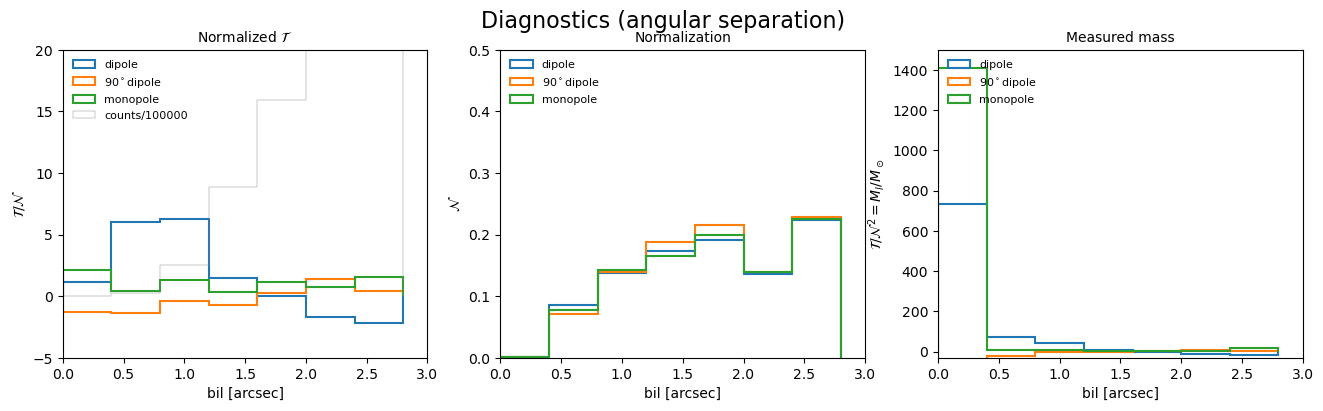

In [125]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

ax[0].hist(bil_bins, bins=bil_bins, weights=tau_mu_list/tau_norm_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(bil_bins, bins=bil_bins, weights=tau_rot90_list/tau_norm_rot90_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(bil_bins, bins=bil_bins, weights=tau_monopole_list/tau_norm_monopole_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(bil_bins, bins=bil_bins, weights=bil_count/100000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[0].set_xlim(0,3); ax[0].set_ylim(-5,20);

ax[0].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/100000'], loc='upper left', fontsize = 8, frameon=False);
ax[0].set_ylabel(r'$\mathcal{T}/\mathcal{N} $'); ax[0].set_xlabel('bil [arcsec]');
ax[0].set_title(r'Normalized $\mathcal{T}$', fontsize = 10);

ax[1].hist(bil_bins, bins=bil_bins, weights=tau_norm_list, log=False, histtype='step', linewidth=1.5);
ax[1].hist(bil_bins, bins=bil_bins, weights=tau_norm_rot90_list, log=False, histtype='step', linewidth=1.5);
ax[1].hist(bil_bins, bins=bil_bins, weights=tau_norm_monopole_list, log=False, histtype='step', linewidth=1.5);
#ax[1].hist(G_bins[:-1], bins=G_bins, weights=G_count/50000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[1].set_xlim(0,3); ax[1].set_ylim(0,0.5);
ax[1].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/($5\times 10^4$)'], loc='upper left', fontsize = 8, frameon=False);
ax[1].set_ylabel(r'$\mathcal{N}$'); ax[1].set_xlabel('bil [arcsec]');
ax[1].set_title(r'Normalization', fontsize = 10);

ax[2].hist(bil_bins, bins=bil_bins, weights=tau_mu_list/tau_norm_list**2, log=False, histtype='step', linewidth=1.5);
ax[2].hist(bil_bins, bins=bil_bins, weights=tau_rot90_list/tau_norm_rot90_list**2, log=False, histtype='step', linewidth=1.5);
ax[2].hist(bil_bins, bins=bil_bins, weights=tau_monopole_list/tau_norm_monopole_list**2, log=False, histtype='step', linewidth=1.5);
#ax[2].hist(G_bins[:-1], bins=G_bins, weights=G_count/1000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[2].set_xlim(0,3); ax[2].set_ylim(-30,1500);

ax[2].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/200'], loc='upper left', fontsize = 8, frameon=False);
ax[2].set_ylabel(r'$\mathcal{T}/\mathcal{N}^2 = M_l/M_\odot $'); ax[2].set_xlabel('bil [arcsec]');
ax[2].set_title(r'Measured mass', fontsize = 10);

#plt.tight_layout()
fig.suptitle(r'Diagnostics (angular separation)', fontsize = 16)
fig.show()
#fig.savefig(FigDir+'tau_vs_gmag.pdf')

(array([7.000000e+00, 3.000000e+01, 1.110000e+02, 7.450000e+02,
        3.359000e+03, 1.105600e+04, 2.962500e+04, 7.072300e+04,
        1.406190e+05, 2.690780e+05, 4.740240e+05, 7.952670e+05,
        1.249415e+06, 1.804315e+06, 2.387660e+06, 3.102816e+06,
        4.416697e+06, 6.174323e+06, 5.987293e+06, 1.143088e+06]),
 array([ 7.4897914 ,  8.17949433,  8.86919726,  9.55890019, 10.24860312,
        10.93830605, 11.62800898, 12.31771191, 13.00741484, 13.69711777,
        14.3868207 , 15.07652363, 15.76622656, 16.45592949, 17.14563242,
        17.83533535, 18.52503828, 19.21474121, 19.90444414, 20.59414707,
        21.28385   ]),
 <BarContainer object of 20 artists>)

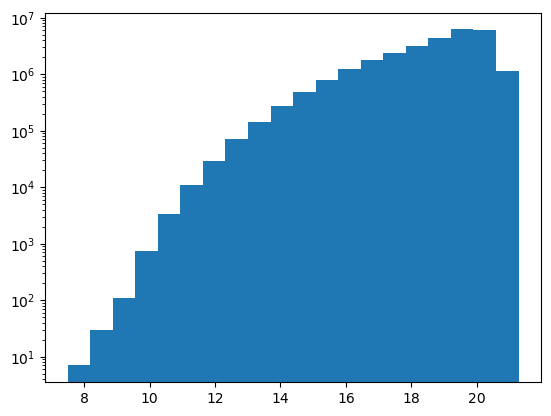

In [ ]:
plt.hist(df_fore['phot_g_mean_mag'], log = True, bins = 20)

In [ ]:
G_bins

array([ 5.  , 15.  , 16.  , 17.  , 17.5 , 17.9 , 18.3 , 18.6 , 18.8 ,
       18.95, 19.1 , 19.2 , 19.3 , 19.4 , 19.5 , 19.6 , 19.7 , 19.8 ,
       19.9 , 20.  , 20.1 , 20.2 , 20.3 , 20.4 , 20.5 , 20.6 , 20.72,
       22.  ])

# Impact param anisotropy

In [53]:
foregrounds = df_foresmaller
backgrounds = df_backsmaller

In [54]:
### Impact parameter and unit vector in the direction of the impact parameter
b_il = fn_angular_sep(foregrounds['ra'].to_numpy()*degree, foregrounds['dec'].to_numpy()*degree, 
                      backgrounds['ra'].to_numpy()*degree, backgrounds['dec'].to_numpy()*degree)
b_il_norm = np.sqrt(b_il[:, 0]**2+b_il[:, 1]**2)
b_il_hat = np.array([b_il[:, 0]/b_il_norm, b_il[:, 1]/b_il_norm]).T 

In [55]:
### Lens velocity unit vector
#vl_vec = np.array([foregrounds['pmra'].to_numpy() - backgrounds['pmra'].to_numpy() , foregrounds['pmdec'].to_numpy() - backgrounds['pmdec'].to_numpy()]).T

#vl_vec = np.array([foregrounds['pmra'].to_numpy() - backgrounds['pmra_sub'].to_numpy() , foregrounds['pmdec'].to_numpy() - backgrounds['pmdec_sub'].to_numpy()]).T
#vl_vec = np.array([fg_pmra - bg_pmra, fg_pmdec - bg_pmdec]).T*mas/Year
vl_vec = np.array([foregrounds['pmra'].to_numpy() , foregrounds['pmdec'].to_numpy()]).T

vl_norm = np.sqrt(vl_vec[:, 0]**2 + vl_vec[:, 1]**2)
vl_hat = np.array([vl_vec[:, 0]/vl_norm, vl_vec[:, 1]/vl_norm]).T 

In [56]:
### Angle between the impact parameter and the velocity unit vector
cos_theta = b_il_hat[:,0]*vl_hat[:,0] + b_il_hat[:,1]*vl_hat[:,1]
theta = np.arccos(cos_theta)

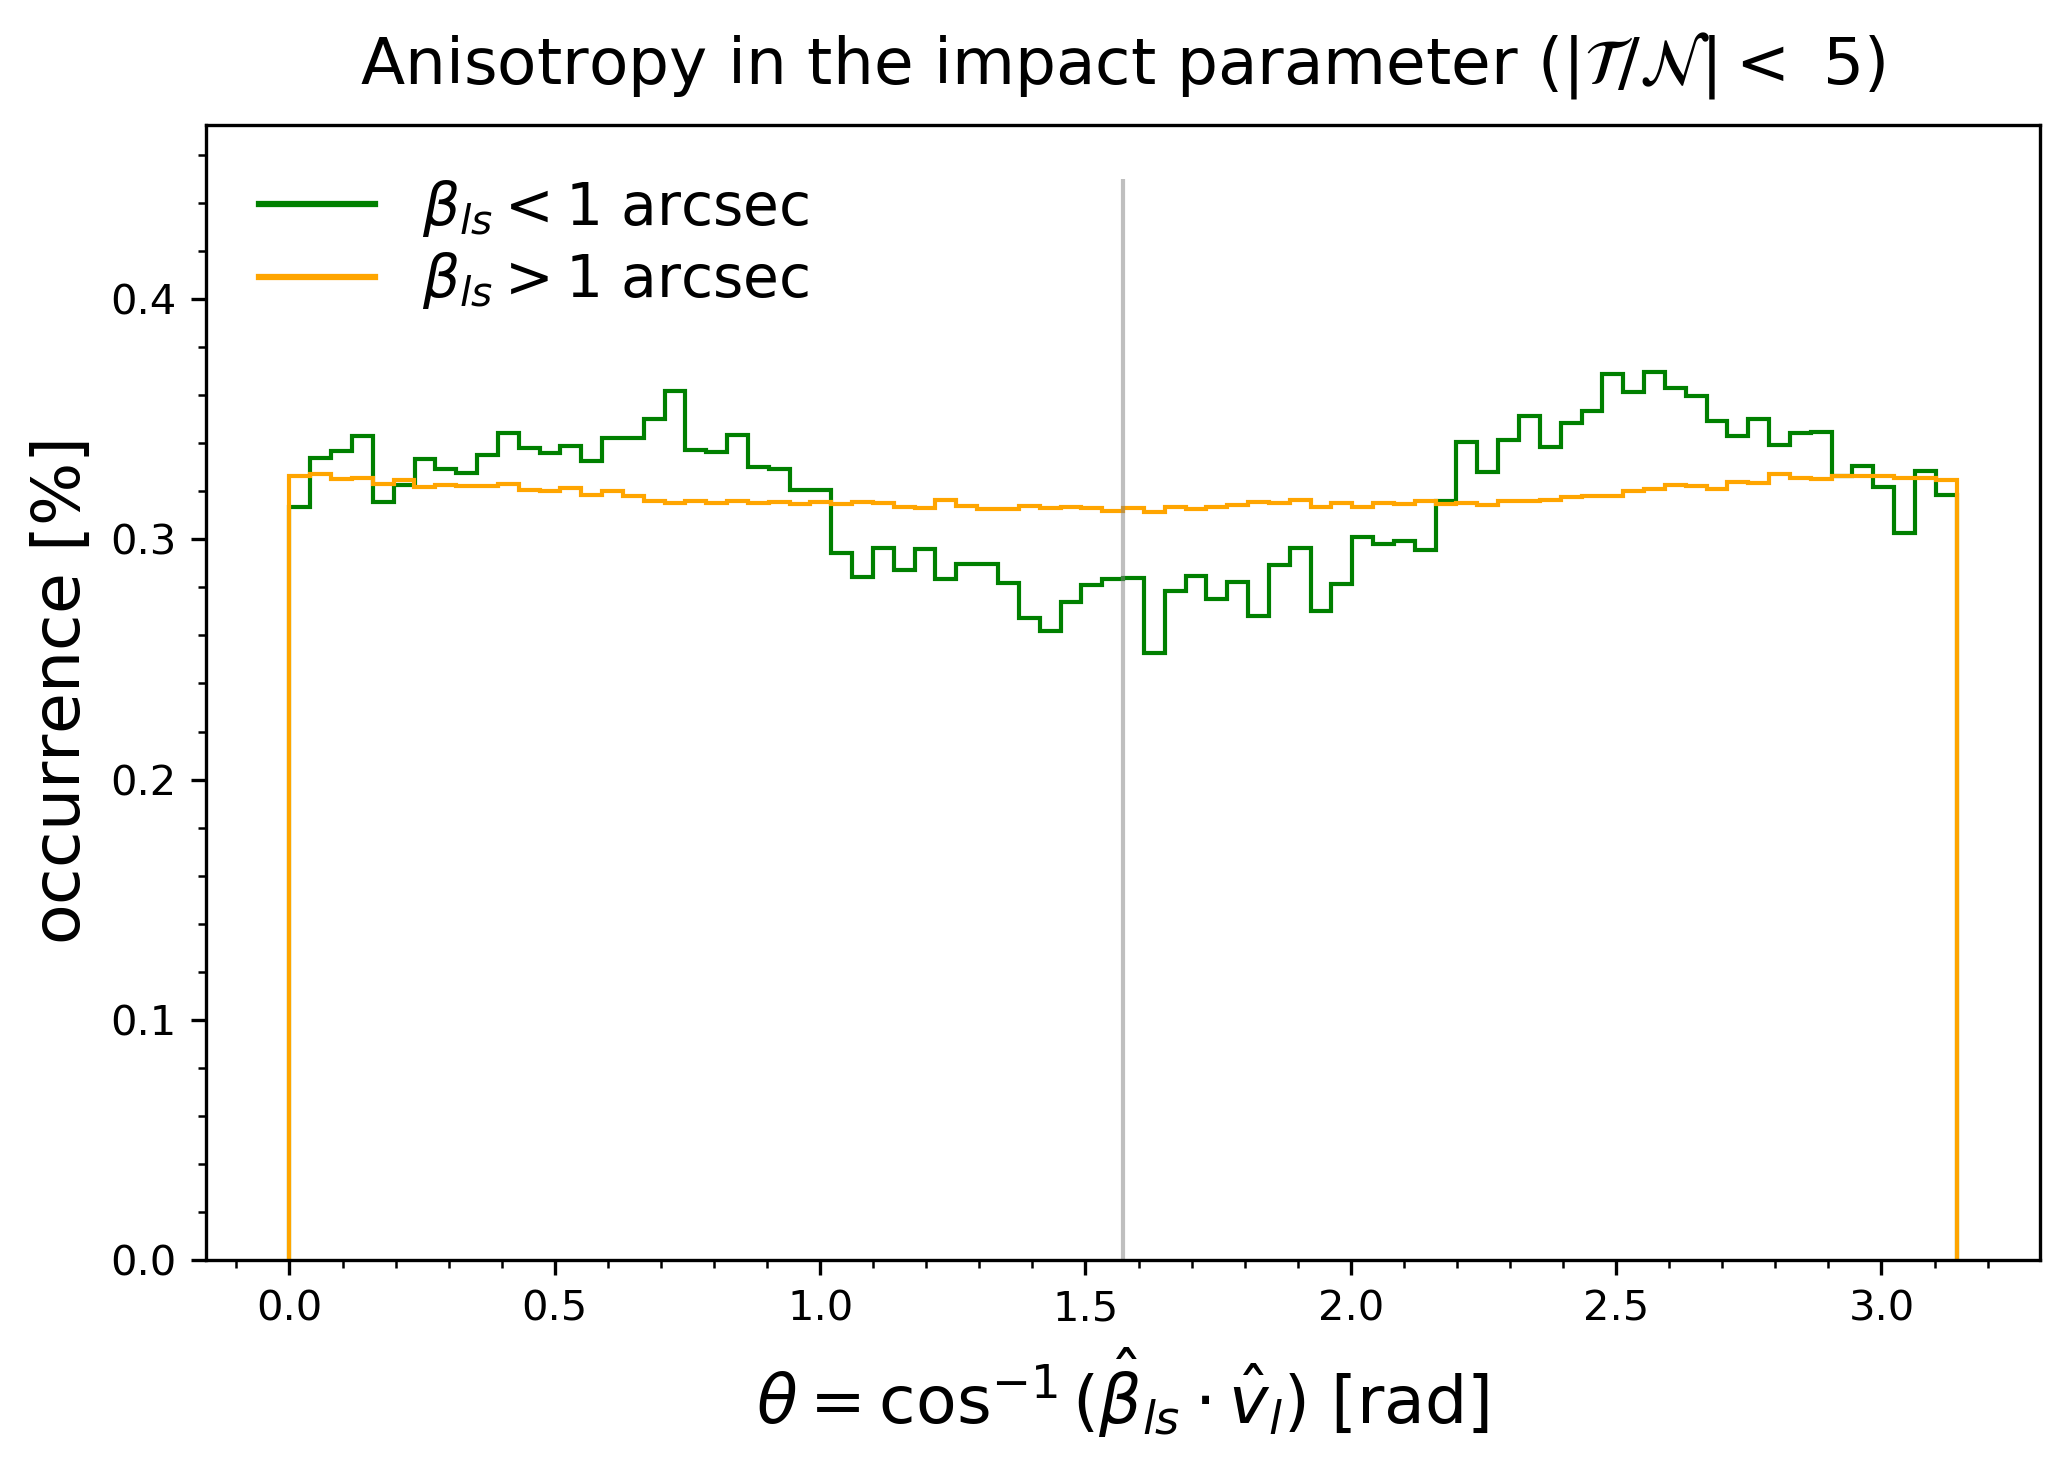

In [57]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5), dpi=300)
colorlist = ['green', 'orange']
beta_th = 1

ax.minorticks_on()

ax.hist(theta[b_il_norm/arcsec < beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[0]);
ax.hist(theta[b_il_norm/arcsec >= beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[1]);
#ax.hist(theta[b_il_norm/arcsec >= beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[2]);
ax.set_title(r'Anisotropy in the impact parameter ($|\mathcal{T}/\mathcal{N}| <$ ' + str(cutoff_tau) + ')', pad=10, fontsize=15.5)
ax.set_xlabel(r'$\theta = \cos^{-1} (\hat{\beta}_{ls} \cdot \hat{v}_{l})$ [rad]', fontsize=16); ax.set_ylabel(r'occurrence [$\%$]', fontsize=16);

p = [plt.plot([0, 3], [0, 0], color=colorlist[i])[0] for i in range(2)] 
ax.legend(p, [r'$\beta_{ls} < '+str(beta_th)+' $ arcsec', r'$\beta_{ls} > '+str(beta_th)+' $ arcsec'], loc='upper left', frameon=False, labelspacing=0.2, fontsize=14);
[p[i].set_visible(False) for i in range(len(p))]

ax.vlines(math.pi/2, 0, 0.45, color='grey', linewidth = 1, alpha=0.5)

fig.tight_layout()
#fig.savefig(FigDir+'Impact_param_anisotropy.pdf')

In [58]:
print(len(theta[b_il_norm/arcsec < beta_th]), len(theta[b_il_norm/arcsec >= beta_th])); sys.stdout.flush()

840966 38282820


# Background subtraction using angular separation only

## Subtraction

In [3]:
### Read in the data files for the background and foreground stars
df_back = pd.read_csv(DataDir+'bg_ruwe_dist.csv', 
                      usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'pmra_eff_error', 'pmdec_eff_error', 'pmra_pmdec_eff_corr', 
                                 'parallax', 'parallax_error', 'pmra_sub', 'pmdec_sub', 'phot_g_mean_mag', 'ruwe'])
df_fore = pd.read_csv(DataDir+'fg_ruwe_dist.csv', 
                      usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'ruwe']) #, 'ecl_lon', 'ecl_lat'])
len(df_back), len(df_fore)

(15138051, 15138051)

In [4]:
df_fore.columns

Index(['source_id', 'ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error',
       'parallax', 'parallax_error', 'phot_g_mean_mag', 'ruwe'],
      dtype='object')

In [5]:
### Read in the data files for the Bailer-Jones distances
back_dist = pd.read_csv(DataDir+'bg_distances.csv', usecols = ['0', '1', '2', '3'])
fore_dist = pd.read_csv(DataDir+'fg_distances.csv', usecols = ['0', '1', '2', '3'])
len(back_dist), len(fore_dist)

(10448136, 10448136)

In [6]:
df_back['dist_50'] = back_dist['1']
df_back['dist_14'] = back_dist['2']
df_back['dist_86'] = back_dist['3']

In [7]:
### Estimate of a symmetric error
df_back['dist_error'] = ((df_back['dist_50'].to_numpy() - df_back['dist_14'].to_numpy()) + 
                         (df_back['dist_86'].to_numpy() - df_back['dist_50'].to_numpy())) / 2

In [8]:
df_fore['dist_50'] = fore_dist['1']
df_fore['dist_14'] = fore_dist['2']
df_fore['dist_86'] = fore_dist['3']

In [9]:
### Impact parameter and unit vector in the direction of the impact parameter
b_il = fn_angular_sep(df_back['ra'].to_numpy()*degree, df_back['dec'].to_numpy()*degree,
                      df_fore['ra'].to_numpy()*degree, df_fore['dec'].to_numpy()*degree)
b_il_norm = np.sqrt(b_il[:, 0]**2+b_il[:, 1]**2)/arcsec
df_back['b_il_norm'] = b_il_norm

np.min(b_il_norm), np.max(b_il_norm)

(0.2174951960445137, 2.9999999422942665)

In [10]:
bil_bin_step = 0.05
bil_bins = np.arange(0.2, 3+bil_bin_step, bil_bin_step)

In [11]:
def fn_pm_stats(df_fore, df_back, bil_bins, th_count=30, n_sigma_out=3, final_call=False):
    
    b_il_norm = df_back['b_il_norm'].to_numpy()
    q_bil = np.digitize(b_il_norm, bil_bins) - 1   
    
    norm_hist = np.histogram(b_il_norm, bins=bil_bins)[0]
    good_stars = (norm_hist[q_bil] > th_count)

    pmra_avg = np.histogram(b_il_norm, bins=bil_bins, weights=df_back['pmra'].to_numpy())[0]
    pmra_avg = np.divide(pmra_avg, norm_hist, out=np.zeros(len(norm_hist)), where=(norm_hist>0) )
    
    np.divide(pmra_avg, norm_hist, out=np.zeros(len(norm_hist)), where=(norm_hist>0) )

    pmdec_avg = np.histogram(b_il_norm, bins=bil_bins, weights=df_back['pmdec'].to_numpy())[0]
    pmdec_avg = np.divide(pmdec_avg, norm_hist, out=np.zeros(len(norm_hist)), where=(norm_hist>0) )

    pmra_var = np.histogram(b_il_norm, bins=bil_bins, weights=(df_back['pmra'].to_numpy() - pmra_avg[q_bil])**2)[0]
    pmra_var = np.divide(pmra_var, norm_hist, out=np.zeros(len(norm_hist)), where=(norm_hist>0) )

    pmdec_var = np.histogram(b_il_norm, bins=bil_bins, weights=(df_back['pmdec'].to_numpy() - pmdec_avg[q_bil])**2)[0]
    pmdec_var = np.divide(pmdec_var, norm_hist, out=np.zeros(len(norm_hist)), where=(norm_hist>0) )

    pmradec_cov = np.histogram(b_il_norm, bins=bil_bins, weights=(df_back['pmra'].to_numpy() - pmra_avg[q_bil])*(df_back['pmdec'].to_numpy() - pmdec_avg[q_bil]) )[0]
    pmradec_cov = np.divide(pmradec_cov, norm_hist, out=np.zeros(len(norm_hist)), where=(norm_hist>0) )

    ### Remove stars in sparse bins
    len_bg = len(df_back)
    df_fore = df_fore.iloc[good_stars]; df_back = df_back.iloc[good_stars]
    q_bil = q_bil[good_stars]
    sparse_frac=(1-len(df_back)/len_bg);        
    #print('Iter '+str(iter_n)+' -- fraction of stars in sparse bins: '+str(out_frac*100)[:8]+' %')
    print('Iter '+str(iter_n)+' -- fraction of stars in sparse bins: ', sparse_frac)

    ### Subtract pm avg
    pm_sub = np.array([df_back['pmra'].to_numpy()-pmra_avg[q_bil], df_back['pmdec'].to_numpy()-pmdec_avg[q_bil]]).T

    
    if final_call==False: ### remove outliers
        inv_cov_pm = np.linalg.inv(np.array([[pmra_var[q_bil], pmradec_cov[q_bil]], [pmradec_cov[q_bil], pmdec_var[q_bil]]]).T)        
        mu_over_sigma_sq = inv_cov_pm[:, 0, 0]*pm_sub[:, 0]**2 + inv_cov_pm[:, 1, 1]*pm_sub[:, 1]**2 + 2*inv_cov_pm[:, 0, 1]*pm_sub[:, 0]*pm_sub[:, 1]

        len_bg = len(df_back)
        df_fore = df_fore.iloc[( (mu_over_sigma_sq < n_sigma_out**2) )]
        df_back = df_back.iloc[( (mu_over_sigma_sq < n_sigma_out**2)  )]
        out_frac=(1-len(df_back)/len_bg);        
        #print('Iter '+str(iter_n)+' -- fraction of outliers removed: '+str(out_frac*100)[:8]+' %')
        print('Iter '+str(iter_n)+' -- fraction of outliers removed: ', out_frac)
        
        return df_fore, df_back

    else: ### add columns corresponding to subtracted pm motion and effective variance 
        df_back['pmra_sub_new'] = pm_sub[:, 0]; df_back['pmdec_sub_new'] = pm_sub[:, 1]; 
        
        df_back['pmra_eff_error_new'] = np.sqrt(pmra_var[q_bil])
        df_back['pmdec_eff_error_new'] = np.sqrt(pmdec_var[q_bil])

        df_back['pmra_pmdec_eff_corr_new'] = pmradec_cov[q_bil]/(np.sqrt(pmra_var[q_bil])*np.sqrt(pmdec_var[q_bil]))
        
        return df_fore, df_back

In [12]:
iter_n=0
out_frac=1
n_iter = 10 # each iteration around 1 minutes
n_sigma_out = 3
th_count = 30

while (iter_n<n_iter) & (out_frac>1E-5):
    df_fore_n, df_back_n = fn_pm_stats(df_fore, df_back, bil_bins, th_count, n_sigma_out, final_call=False)    
    df_fore, df_back = df_fore_n, df_back_n
    iter_n += 1; 

Iter 0 -- fraction of stars in sparse bins:  5.945283181318928e-07
Iter 0 -- fraction of outliers removed:  0.019351379788746792
Iter 1 -- fraction of stars in sparse bins:  0.0
Iter 1 -- fraction of outliers removed:  0.015738728604051122
Iter 2 -- fraction of stars in sparse bins:  0.0
Iter 2 -- fraction of outliers removed:  0.005258065639860532
Iter 3 -- fraction of stars in sparse bins:  0.0
Iter 3 -- fraction of outliers removed:  0.0016340974372307526
Iter 4 -- fraction of stars in sparse bins:  0.0
Iter 4 -- fraction of outliers removed:  0.0005092041983951745
Iter 5 -- fraction of stars in sparse bins:  0.0
Iter 5 -- fraction of outliers removed:  0.00016244367131246218
Iter 6 -- fraction of stars in sparse bins:  0.0
Iter 6 -- fraction of outliers removed:  5.261657830457622e-05
Iter 7 -- fraction of stars in sparse bins:  0.0
Iter 7 -- fraction of outliers removed:  1.5861664219629645e-05
Iter 8 -- fraction of stars in sparse bins:  0.0
Iter 8 -- fraction of outliers removed

In [13]:
### Do the subtraction one last time without removing the outliers
df_fore_n, df_back_n = fn_pm_stats(df_fore, df_back, bil_bins, th_count, n_sigma_out, final_call=True)
df_fore, df_back = df_fore_n, df_back_n

Iter 10 -- fraction of stars in sparse bins:  0.0


In [59]:
len(df_fore)

14500041

In [60]:
0.96*10448136, len(df_fore)

(10030210.56, 14500041)

In [61]:
df_back['pmra_eff_error_new'].to_numpy()

array([2.70543952, 2.68814366, 2.7103895 , ..., 2.69847279, 2.69598087,
       2.70778143])

In [62]:
df_back['pmdec_eff_error_new'].to_numpy()

array([3.22208685, 3.21408784, 3.22156937, ..., 3.22776243, 3.22194957,
       3.22217477])

## Effective error vs Gaia error

In [63]:
bins = np.arange(13,22,0.2)
gmag_counts = np.histogram(df_back['phot_g_mean_mag'].to_numpy(), bins=bins)[0]

pmra_error = np.histogram(df_back['phot_g_mean_mag'].to_numpy(), bins=bins, weights=df_back['pmra_error'].to_numpy())[0]
pmra_error = np.divide(pmra_error, gmag_counts, out=np.zeros(len(gmag_counts)), where=(gmag_counts>0) )
pmdec_error = np.histogram(df_back['phot_g_mean_mag'].to_numpy(), bins=bins, weights=df_back['pmdec_error'].to_numpy())[0]
pmdec_error = np.divide(pmdec_error, gmag_counts, out=np.zeros(len(gmag_counts)), where=(gmag_counts>0) )


pmra_eff_error = np.histogram(df_back['phot_g_mean_mag'].to_numpy(), bins=bins, weights=df_back['pmra_eff_error_new'].to_numpy())[0]
pmra_eff_error = np.divide(pmra_eff_error, gmag_counts, out=np.zeros(len(gmag_counts)), where=(gmag_counts>0) )

pmdec_eff_error = np.histogram(df_back['phot_g_mean_mag'].to_numpy(), bins=bins, weights=df_back['pmdec_eff_error_new'].to_numpy())[0]
pmdec_eff_error = np.divide(pmdec_eff_error, gmag_counts, out=np.zeros(len(gmag_counts)), where=(gmag_counts>0) )

pmradec_eff_error = np.histogram(df_back['phot_g_mean_mag'].to_numpy(), bins=bins, weights=df_back['pmra_pmdec_eff_corr_new'].to_numpy())[0]
pmradec_eff_error = np.divide(pmradec_eff_error, gmag_counts, out=np.zeros(len(gmag_counts)), where=(gmag_counts>0) )

In [64]:
gmag_counts

array([  9927,  12779,  16361,  20677,  26673,  33372,  41469,  50982,
        62026,  76464,  92291, 112640, 134920, 162533, 207098, 263843,
       305002, 346873, 385797, 426141, 467376, 508068, 548190, 589280,
       631307, 670000, 708335, 746790, 788686, 832367, 833167, 815713,
       793378, 748265, 667609, 529881, 409401, 270616, 106756,  17391,
          112,      1,      1,      0])

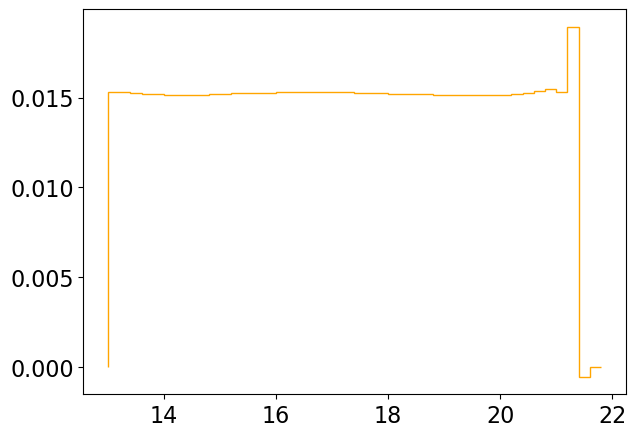

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
liestyle_list = ['-.', 'solid']

#ax.hist(bins[:-1], bins=bins, log=False, density=False, histtype='step', weights=pmra_error, color=colorlist[0]);
#ax.hist(bins[:-1], bins=bins, log=False, density=False, histtype='step', weights=pmra_eff_error, color=colorlist[1]);
#ax.hist(bins[:-1], bins=bins, log=False, density=False, histtype='step', weights=pmdec_eff_error, color=colorlist[2]);
ax.hist(bins[:-1], bins=bins, log=False, density=False, histtype='step', weights=pmradec_eff_error, color=colorlist[3]);

In [66]:
### Impact parameter and unit vector in the direction of the impact parameter
b_il = fn_angular_sep(df_back['ra'].to_numpy()*degree, df_back['dec'].to_numpy()*degree,
                      df_fore['ra'].to_numpy()*degree, df_fore['dec'].to_numpy()*degree)
b_il_norm = np.sqrt(b_il[:, 0]**2+b_il[:, 1]**2)/arcsec

In [67]:
bins = np.arange(0, 3, 0.01)
bil_counts = np.histogram(b_il_norm, bins=bins)[0]

pmra_error = np.histogram(b_il_norm, bins=bins, weights=df_back['pmra_error'].to_numpy())[0]
pmra_error = np.divide(pmra_error, bil_counts, out=np.zeros(len(bil_counts)), where=(bil_counts>0) )

pmra_eff_error = np.histogram(b_il_norm, bins=bins, weights=df_back['pmra_eff_error_new'].to_numpy())[0]
pmra_eff_error = np.divide(pmra_eff_error, bil_counts, out=np.zeros(len(bil_counts)), where=(bil_counts>0))

pmdec_eff_error = np.histogram(b_il_norm, bins=bins, weights=df_back['pmdec_eff_error_new'].to_numpy()**2)[0]
pmdec_eff_error = np.sqrt(np.divide(pmdec_eff_error, bil_counts, out=np.zeros(len(bil_counts)), where=(bil_counts>0) ))

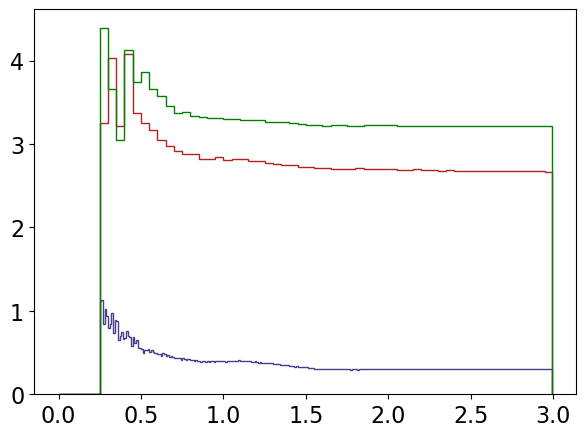

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']
liestyle_list = ['-.', 'solid']


ax.hist(bins[:-1], bins=bins, log=False, density=False, histtype='step', weights=pmra_error, color=colorlist[0]);
ax.hist(bins[:-1], bins=bins, log=False, density=False, histtype='step', weights=pmra_eff_error, color=colorlist[1]);
ax.hist(bins[:-1], bins=bins, log=False, density=False, histtype='step', weights=pmdec_eff_error, color=colorlist[2]);

#ax.axvline(0.3, 0, 1)
#ax.axvline(0.6, 0, 1)
#ax.axvline(0.9, 0, 1)
#ax.axvline(1.2, 0, 1)

## Old -- with weights

In [372]:
stats_array = np.zeros( (len(bil_bins)-1,5) )

for q in tqdm(range(len(bil_bins)-1)):
    
    sel_star = df_back[q_bil==q]
    
    pmra_avg = np.average(sel_star['pmra'].to_numpy(), weights=1/sel_star['pmra_error'].to_numpy()**2)
    pmdec_avg = np.average(sel_star['pmdec'].to_numpy(), weights=1/sel_star['pmdec_error'].to_numpy()**2)

    pmra_var = np.average((sel_star['pmra'].to_numpy() - pmra_avg)**2, weights=1/sel_star['pmra_error'].to_numpy()**2 )
    pmdec_var = np.average((sel_star['pmdec'].to_numpy() - pmdec_avg)**2, weights=1/sel_star['pmdec_error'].to_numpy()**2 )
    pmradec_cov = np.average((sel_star['pmra'].to_numpy() - pmra_avg)*(sel_star['pmdec'].to_numpy() - pmdec_avg), weights=1/(sel_star['pmra_error'].to_numpy()*sel_star['pmdec_error'].to_numpy() ) )
    
    stats_array[q] = [pmra_avg, pmdec_avg, pmra_var, pmdec_var, pmradec_cov] #pmradec_cov/np.sqrt(pmra_var*pmdec_var)]

100%|██████████| 56/56 [00:03<00:00, 16.53it/s]


In [373]:
stats_array[:, 4]

array([ -5.90595107,  -8.80960278,   5.50462276, 105.93132532,   5.1850626 ,   7.01871755,   8.94145286,   0.90878628,  -3.36216316,  -1.12872412,  14.8815465 ,   9.17964659, -12.91991616,
         9.06064457,  -5.58011644, -17.24478918,  -1.02238054,  -1.88381673,  -2.82507894, -24.23583259,   5.13118626,  -6.43272995,  -0.22429945,   0.58652607, -11.99254127,  -8.45388985,
         2.93257687,  -1.50187162,  -0.56219625,  -5.13988735,   9.80517568,   1.21132791,  -4.67647386,  11.6320651 , -10.32911522,  -5.72145495,  -3.31768943,  -0.52380825,  -7.4537351 ,
        -1.83133615,  -1.21661192,  -0.31917693,  -1.35714753,  -1.21901104,  -1.47493866,   4.11808348,  -1.67971808,  -1.44082131,  -0.97572725,  -2.65795605,  -1.44372074,  -1.1962366 ,
         0.53390525,   0.86273871,   5.3582367 ,  -0.69221061])

In [371]:
pmra_avg = np.histogram(b_il_norm, bins=bil_bins, weights=df_back['pmra'].to_numpy()/df_back['pmra_error'].to_numpy()**2)[0]
norm_hist = np.histogram(b_il_norm, bins=bil_bins, weights=1/df_back['pmra_error'].to_numpy()**2)[0]
pmra_avg = pmra_avg/norm_hist

pmdec_avg = np.histogram(b_il_norm, bins=bil_bins, weights=df_back['pmdec'].to_numpy()/df_back['pmdec_error'].to_numpy()**2)[0]
norm_hist = np.histogram(b_il_norm, bins=bil_bins, weights=1/df_back['pmdec_error'].to_numpy()**2)[0]
pmdec_avg = pmdec_avg/norm_hist

pmra_var = np.histogram(b_il_norm, bins=bil_bins, weights=(df_back['pmra'].to_numpy() - pmra_avg[q_bil])**2/df_back['pmra_error'].to_numpy()**2)[0]
norm_hist = np.histogram(b_il_norm, bins=bil_bins, weights=1/df_back['pmra_error'].to_numpy()**2)[0]
pmra_var = pmra_var/norm_hist

pmdec_var = np.histogram(b_il_norm, bins=bil_bins, weights=(df_back['pmdec'].to_numpy() - pmdec_avg[q_bil])**2/df_back['pmdec_error'].to_numpy()**2)[0]
norm_hist = np.histogram(b_il_norm, bins=bil_bins, weights=1/df_back['pmdec_error'].to_numpy()**2)[0]
pmdec_var = pmdec_var/norm_hist

pmradec_cov = np.histogram(b_il_norm, bins=bil_bins, weights=(df_back['pmra'].to_numpy() - pmra_avg[q_bil])*(df_back['pmdec'].to_numpy() - pmdec_avg[q_bil])/(df_back['pmra_error'].to_numpy()*df_back['pmdec_error'].to_numpy()) )[0]
norm_hist = np.histogram(b_il_norm, bins=bil_bins, weights=1/(df_back['pmra_error'].to_numpy()*df_back['pmdec_error'].to_numpy()) )[0]
pmradec_cov = pmradec_cov/norm_hist


pmradec_cov

array([ -5.90595107,  -8.80960278,   5.50462276, 105.93132532,   5.1850626 ,   7.01871755,   8.94145286,   0.90878628,  -3.36216316,  -1.12872412,  14.8815465 ,   9.17964659, -12.91991616,
         9.06064457,  -5.58011644, -17.24478918,  -1.02238054,  -1.88381673,  -2.82507894, -24.23583259,   5.13118626,  -6.43272995,  -0.22429945,   0.58652607, -11.99254127,  -8.45388985,
         2.93257687,  -1.50187162,  -0.56219625,  -5.13988735,   9.80517568,   1.21132791,  -4.67647386,  11.6320651 , -10.32911522,  -5.72145495,  -3.31768943,  -0.52380825,  -7.4537351 ,
        -1.83133615,  -1.21661192,  -0.31917693,  -1.35714753,  -1.21901104,  -1.47493866,   4.11808348,  -1.67971808,  -1.44082131,  -0.97572725,  -2.65795605,  -1.44372074,  -1.1962366 ,
         0.53390525,   0.86273871,   5.3582367 ,  -0.69221061])

In [364]:

pmdec_avg

array([-3.48902864, -4.38535304, -5.02888713, -4.98862085, -5.8189887 , -3.38400078, -4.17093346, -4.11392513, -3.95694606, -3.54891974, -3.62331   , -3.94698211, -3.60315015, -3.61714529,
       -3.25639845, -3.24808748, -3.44660981, -3.24223597, -3.07660323, -3.24361802, -3.06229716, -2.92949035, -2.98281933, -3.01007327, -2.88335582, -3.03633294, -3.01562582, -2.96644986,
       -2.9832669 , -3.05526339, -3.06714613, -3.07221974, -3.04600964, -3.02625881, -2.97290985, -3.09800206, -3.06623973, -3.08969201, -3.03552654, -3.0468195 , -3.0452262 , -3.00119132,
       -2.97126882, -2.98653147, -3.015401  , -2.93518462, -2.98154055, -2.97216354, -3.00276587, -2.96009643, -2.98519759, -2.96754197, -2.9291036 , -2.98757151, -2.98685243, -2.9573093 ])

In [335]:
sel_star = df_back[q_bil==13]

In [336]:
len(sel_star)

30072

In [337]:
np.cov(sel_star['pmra'].to_numpy(), sel_star['pmdec'].to_numpy(), bias=True, ddof=0, aweights=1/sel_star['pmra_error'].to_numpy()**2) #*(len(sel_star)-1)/len(sel_star)

array([[44.8826514 , 10.59587252],
       [10.59587252, 61.54033578]])

In [346]:
pmra_avg = np.average(sel_star['pmra'].to_numpy(), weights=1/sel_star['pmra_error'].to_numpy()**2)
pmdec_avg = np.average(sel_star['pmdec'].to_numpy(), weights=1/sel_star['pmra_error'].to_numpy()**2)

[np.average((sel_star['pmra'].to_numpy() - pmra_avg)**2, weights=1/sel_star['pmra_error'].to_numpy()**2 ), 
 np.average((sel_star['pmdec'].to_numpy() - pmdec_avg)**2, weights=1/sel_star['pmra_error'].to_numpy()**2 ),
 np.average((sel_star['pmra'].to_numpy() - pmra_avg)*(sel_star['pmdec'].to_numpy() - pmdec_avg), weights=1/(sel_star['pmra_error'].to_numpy()*sel_star['pmra_error'].to_numpy() ) )]

[44.88265139565149, 61.5403357846112, 10.595872522384985]

In [338]:
mu_avg = np.average(sel_star['pmra'].to_numpy(), weights=1/sel_star['pmra_error'].to_numpy()**2)
np.average((sel_star['pmra'].to_numpy() - mu_avg)**2, weights=1/sel_star['pmra_error'].to_numpy()**2 )

44.88265139565149

In [304]:
np.average(sel_star['pmra'].to_numpy(), weights=1/sel_star['pmra_error'].to_numpy()**2)

(-2.9502182830520076, -3.042185624501783)

In [347]:
np.histogram(b_il_norm, bins=bil_bins)[0]

array([     8,     45,     41,     57,    116,    417,   1380,   3329,   6118,   9598,  13928,  18882,  24109,  30072,  36298,  43028,  50810,  59427,  68746,  79727,  90973, 101714, 113552, 126272,
       142441, 164250, 184117, 200672, 212834, 221687, 228649, 236452, 244191, 250561, 258033, 266257, 276817, 286151, 296647, 306138, 313205, 319533, 325786, 331085, 338950, 346103, 352459, 358884,
       364879, 371672, 378312, 385166, 391425, 399108, 404904, 412121])